In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import ROOT, uproot


plt.rcParams["figure.figsize"] = (10, 8)


In [103]:
from scipy.optimize import curve_fit

def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def res_plot(a, fnc=gauss, bins=None, label=None, unit=" mm", legend=True, eb_args={}, fitcurve_args={}):
    a=np.array(a)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    eb=plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='', label=label,**eb_args)
    curve=None
    p0=[10,0, np.std(a[(a>=x[0])&(a<=x[-1])])]
    slc=h>0
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        print(f"fit: $\\sigma={coeff[2]:.1f}\\pm{np.sqrt(var_matrix[2][2]):.1f}${unit}")
        x=np.linspace(x[0], x[-1], 100)
        if coeff[2]< 1000 and var_matrix[2][2]<1000:
            curve=plt.plot(x, fnc(x,*coeff), label=f"fit: $\\sigma={abs(coeff[2]):.1f}\\pm {np.sqrt(var_matrix[2][2]):.1f}${unit}",
                          **fitcurve_args)
        if legend:
            plt.legend(loc='upper left', fontsize=20)
        return coeff[2],np.sqrt(var_matrix[2][2]), eb, curve
    except:
        return 0, 0, eb, None
    

In [ ]:
def res_calc(a, fnc=gauss, bins=None, label=None):
    a=np.array(a)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    #eb=plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='', label=label,**eb_args)
    #curve=None
    p0=[10,0, np.std(a[(a>=x[0])&(a<=x[-1])])]
    slc=h>0
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        return coeff[2],np.sqrt(var_matrix[2][2])
    except:
        return 0, 0

In [18]:
def get_xyzr_reco(arrays, event, w0=4, weight_by_granularity=True, prefix="ZDC"):
    x=arrays[f'{prefix}HitsReco.position.x'][event]
    y=arrays[f'{prefix}HitsReco.position.y'][event]
    z=arrays[f'{prefix}HitsReco.position.z'][event]
    E=arrays[f'{prefix}HitsReco.energy'][event]
    #lay=arrays['HcalEndcapPInsertHitsReco.layer'][event]
    sl=arrays[f'{prefix}HitsReco.dimension.x'][event]
    if w0 !=0:
        w=w0+np.log((E+.0000001)/sum(E))
        w=w*(w>0)
    else :
        w=E
    if weight_by_granularity:
        w=w/sl**2
    sumw=sum(w)
    x_reco=sum(x*w)/sumw
    y_reco=sum(y*w)/sumw
    z_reco=sum(z*w)/sumw
    r_reco=np.hypot(x_reco,y_reco)
    return [x_reco,y_reco,z_reco,r_reco]

In [19]:
def get_xyzr_truth(arrays, event, w0=4, weight_by_granularity=True, prefix="ZDC"):
    z=arrays[f'{prefix}HitsReco.position.z'][event]
    E=arrays[f'{prefix}HitsReco.energy'][event]
    #lay=arrays['HcalEndcapPInsertHitsReco.layer'][event]
    sl=arrays[f'{prefix}HitsReco.dimension.x'][event]
    if w0 !=0:
        w=w0+np.log((E+.0000001)/sum(E))
        w=w*(w>0)
    else :
        w=E
    if weight_by_granularity:
        w=w/sl**2
    z_reco=sum(z*w)/sum(w)
    
    px=arrays["MCParticles.momentum.x"][event,2]
    py=arrays["MCParticles.momentum.y"][event,2]
    pz=arrays["MCParticles.momentum.z"][event,2]

    x_truth=px/pz*z_reco
    y_truth=py/pz*z_reco
    z_truth=z_reco
    r_truth=np.hypot(x_truth,y_truth)
    
    return [x_truth,y_truth,z_truth,r_truth]

In [20]:
sqrt3=np.sqrt(3)
sqrt5=np.sqrt(5)

def mx(a,b):
    return a*(a>b)+b*(b>=a)
#with H3
def get_xyzr_reco_reweighted(arrays, event, w0=4, weight_by_granularity=True, b=3, prefix="ZDC"):
    x=arrays[f'{prefix}HitsReco.position.x'][event]
    y=arrays[f'{prefix}HitsReco.position.y'][event]
    z=arrays[f'{prefix}HitsReco.position.z'][event]
    E=arrays[f'{prefix}HitsReco.energy'][event]
    #lay=arrays['HcalEndcapPInsertHitsReco.layer'][event]
    sl=arrays[f'{prefix}HitsReco.dimension.x'][event]/2
    
    tmp=sorted(list(set(z)))
    dz=tmp[1]-tmp[0]
    
    Etot=sum(E)
    thresh=Etot*np.exp(-w0)
    
    
    xnew=[]
    ynew=[]
    znew=[]
    Enew=[]
    slnew=[]
    phi=np.linspace(0, np.pi*5/3, 6)
    cph=np.cos(phi)
    sph=np.sin(phi)
    for i in range(len(x)):
        if E[i]<thresh:
            continue
        Eneighbors=[0,0,0,0,0,0]
        for j in range(len(x)):
            if abs(z[i]-z[j])>dz*1.1 or  E[j]<thresh or  j == i :
                continue
            dx=(x[j]-x[i])/sl[i]
            dy=(y[j]-y[i])/sl[i]
            if abs(dx)>1.1 or abs(dy)>1.1:
                continue
            tol=0.01
            for k in range(6):
                if abs(dx-cph[k])<tol and abs(dy-sph[k])<tol:
                    #print("found neighbor")
                    Eneighbors[k]=E[j]
                    #print(Eneighbors, E[j])
                    break
        a=thresh*b
        Eneighbors=np.array(Eneighbors)
        #print(Eneighbors)
        reweight_energy=mx(Eneighbors,a)*mx(np.roll(Eneighbors,1),a)
        reweight_energy/=sum(reweight_energy)
        #print(reweight_energy)
        for k in range(6):
            xnew.append(x[i]+sl[i]*(cph[k]+cph[k-5])/3)
            ynew.append(y[i]+sl[i]*(sph[k]+sph[k-5])/3)
            znew.append(z[i])
            Enew.append(E[i]*reweight_energy[k])
            slnew.append(sl[i]/sqrt5)
            
    xnew=np.array(xnew)
    ynew=np.array(ynew)
    znew=np.array(znew)
    Enew=np.array(Enew)
    slnew=np.array(slnew)
    
    
    if w0 !=0:
        w=w0+np.log((Enew+.0000001)/Etot)
        w=w*(w>0)
    else :
        w=Enew
    if weight_by_granularity:
        w=w/slnew**2
    #print(w, Enew/Etot/thresh)
    sumw=sum(w)
    x_reco=sum(xnew*w)/sumw
    y_reco=sum(ynew*w)/sumw
    z_reco=sum(znew*w)/sumw
    r_reco=np.hypot(x_reco,y_reco)
    return [x_reco,y_reco,z_reco,r_reco]

In [ ]:
events = ur.open(f'cache/staggered_h3_zdc/zdc_reco_neutron_50GeV_theta_deg.edm4hep.root:events')
arrays = events.arrays()
#print(len(arrays))
#print(arrays.fields)
w0=5; b=0.05

drs=[]
dxs=[]
dys=[]
nevents=len(arrays)
for event in range(nevents):
    #print(len(arrays['ZDCHitsReco.position.x'][event]))
    try:
        x_reco, y_reco, _, r_reco=get_xyzr_reco_reweighted(arrays, event, w0=w0, weight_by_granularity=True,b=b, prefix='ZDC')
        x_truth, y_truth, _, r_truth=get_xyzr_truth(arrays, event, w0=w0, weight_by_granularity=True, prefix='ZDC')
        drs.append(r_reco-r_truth)
        dxs.append(x_reco-x_truth)
        dys.append(y_reco-y_truth)
    except:
        pass
    
    if event%10==0:
        print(f"done with event {event}/{nevents}")
    

In [ ]:
print("")
res_plot(dxs, bins=np.linspace(-20, 20, 25), label='ZDC simulation\nneutron, 50 GeV')
plt.xlabel("$x_{\\rm reco}-x_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.ylim(0, plt.gca().get_ylim()[1]*1.2)
#plt.sca(axs[1][i])
plt.show()
res_plot(dys, bins=np.linspace(-20, 20, 25), label="ZDC simulation\nneutron, 50 GeV")
plt.xlabel("$y_{\\rm reco}-y_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.ylim(0, plt.gca().get_ylim()[1]*1.2)
plt.show()

res,dres, eb, curve= res_plot(drs, bins=np.linspace(-20, 20, 25), label="ZDC simulation\nneutron, 50 GeV")
curve[0].set_label(curve[0].get_label()+f"\n({res/35:.3}$\pm$ {dres/35:.1} mrad)")
plt.xlabel("$r_{\\rm reco}-r_{\\rm truth}$ [mm]")
plt.ylabel("events")
plt.legend()
plt.ylim(0, plt.gca().get_ylim()[1]*1.2)
plt.show()

In [ ]:
events = ur.open(f'cache/staggered_h3_zdc/zdc_reco_neutron_50GeV_theta_deg.edm4hep.root:events')
arrays = events.arrays()
Es=[]
for event in range(len(arrays)):
    E=arrays[f'ZDCHitsReco.energy'][event]
    Es.append(sum(E))
res_plot(100*(np.array(Es)/np.mean(Es)-1),bins=np.linspace(-30, 30,30), label="ZDC simulation\nneutron, 50 GeV", unit="%")
plt.xlabel("$(E_{\\rm reco}-E_{\\rm truth})/E_{\\rm truth}$ [%]")
plt.ylabel("events")
plt.show()

a
1 GeV, done with event 0/100
1 GeV, done with event 10/100
1 GeV, done with event 20/100
1 GeV, done with event 30/100
1 GeV, done with event 40/100
1 GeV, done with event 50/100
1 GeV, done with event 60/100
1 GeV, done with event 70/100
1 GeV, done with event 80/100
1 GeV, done with event 90/100
fit: $\sigma=43.1\pm6.0$ mm


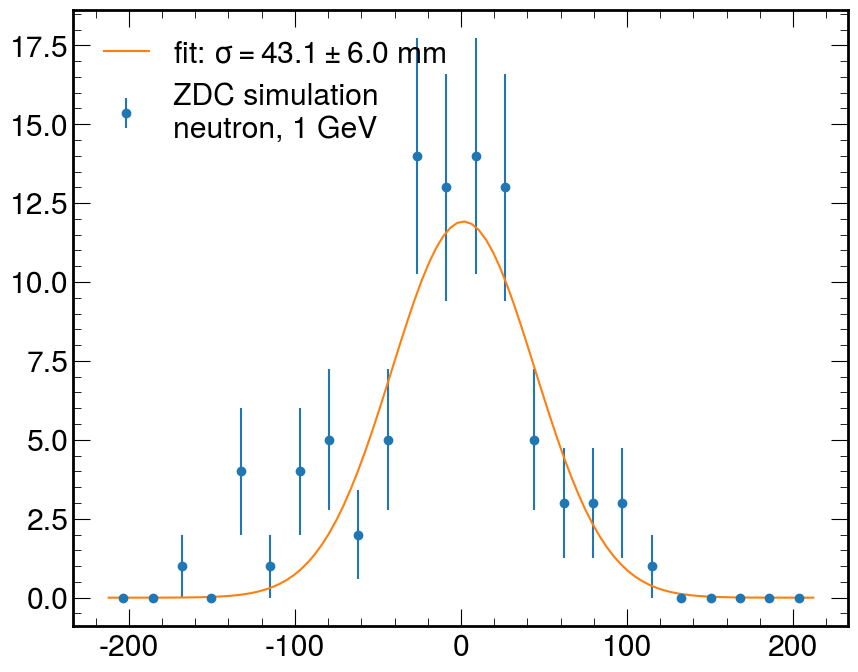

fit: $\sigma=61.2\pm18.7$%


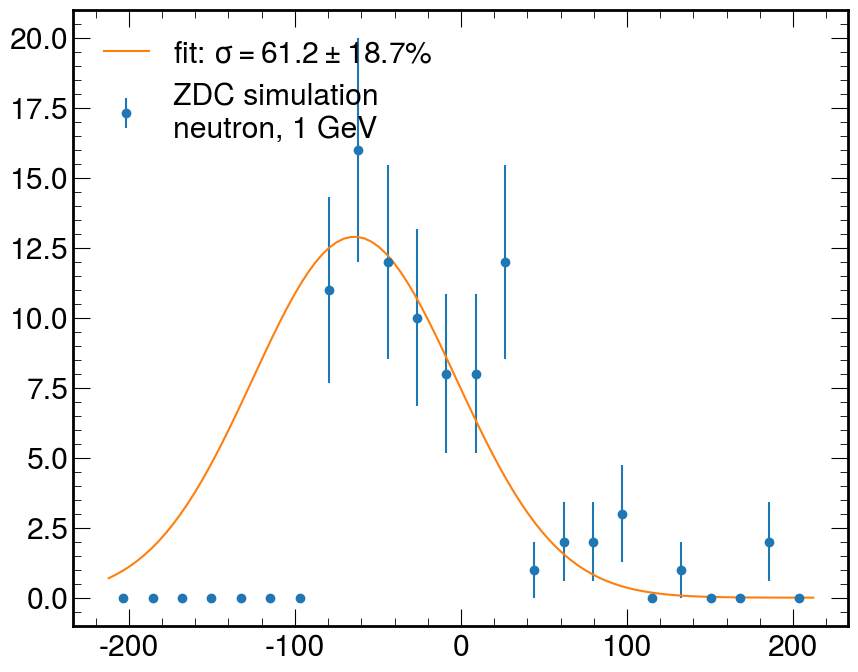

2 GeV, done with event 0/100
2 GeV, done with event 10/100
2 GeV, done with event 20/100
2 GeV, done with event 30/100
2 GeV, done with event 40/100
2 GeV, done with event 50/100
2 GeV, done with event 60/100
2 GeV, done with event 70/100
2 GeV, done with event 80/100
2 GeV, done with event 90/100
fit: $\sigma=42.3\pm3.1$ mm


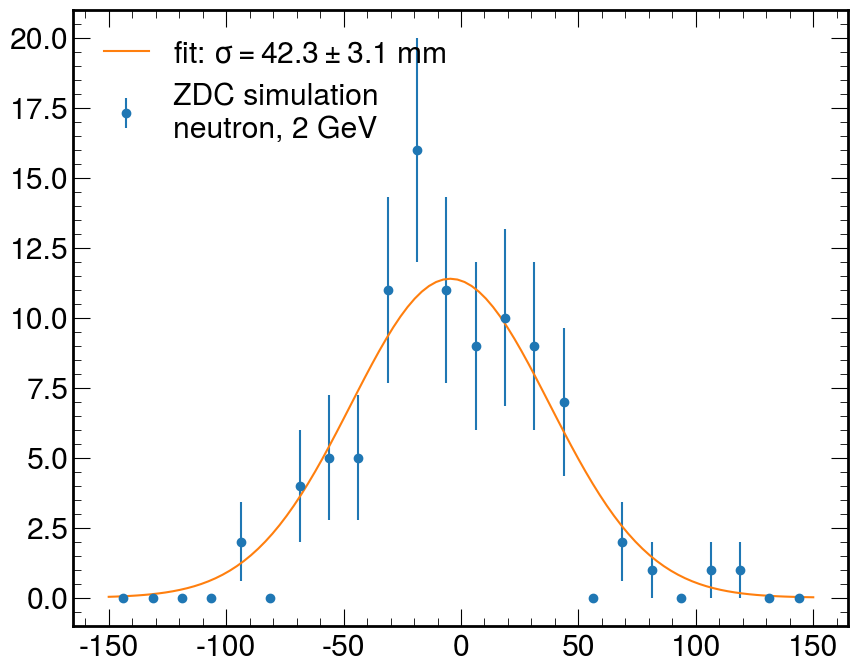

fit: $\sigma=43.0\pm4.3$%


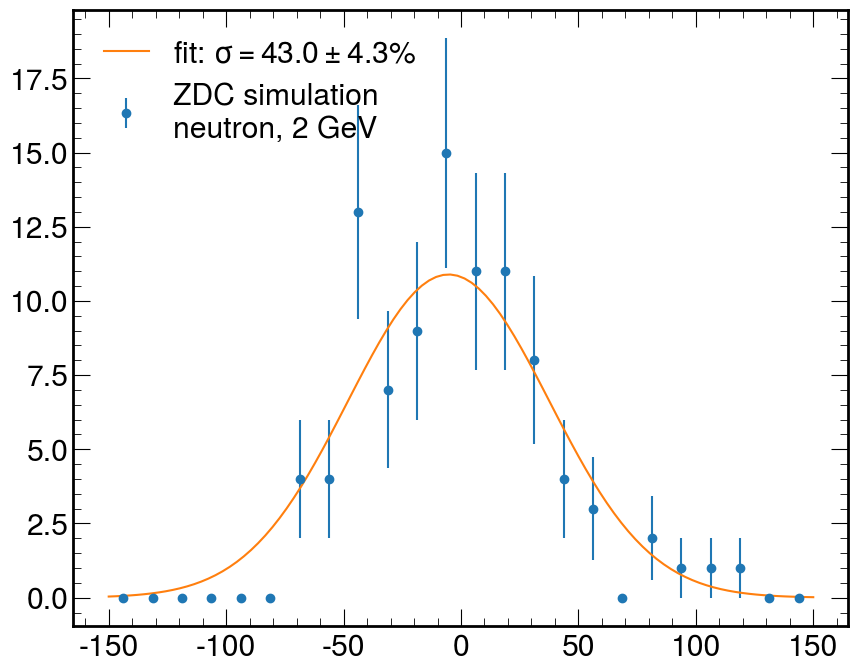

5 GeV, done with event 0/100
5 GeV, done with event 10/100
5 GeV, done with event 20/100
5 GeV, done with event 30/100
5 GeV, done with event 40/100
5 GeV, done with event 50/100
5 GeV, done with event 60/100
5 GeV, done with event 70/100
5 GeV, done with event 80/100
5 GeV, done with event 90/100
fit: $\sigma=22.4\pm2.6$ mm


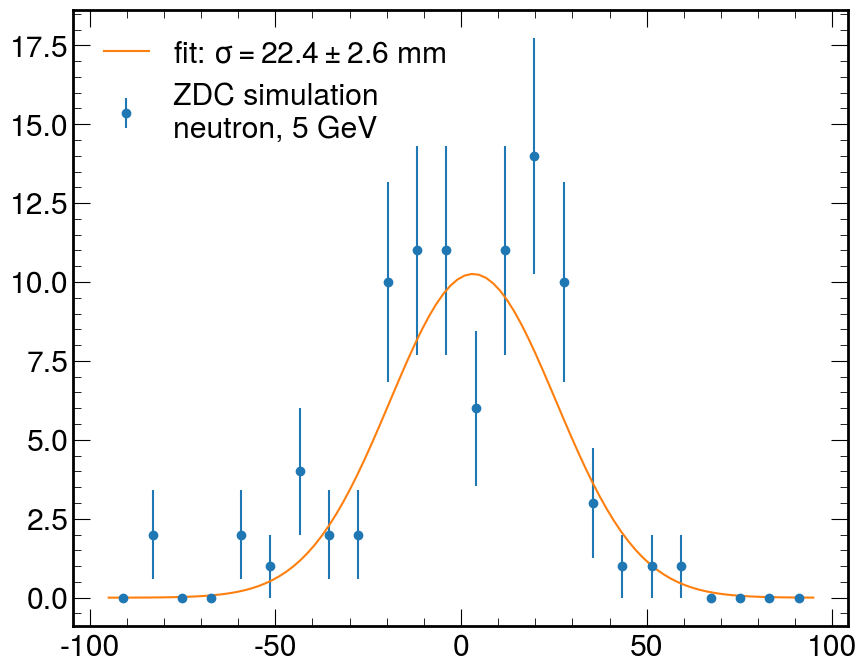

fit: $\sigma=25.8\pm3.8$%


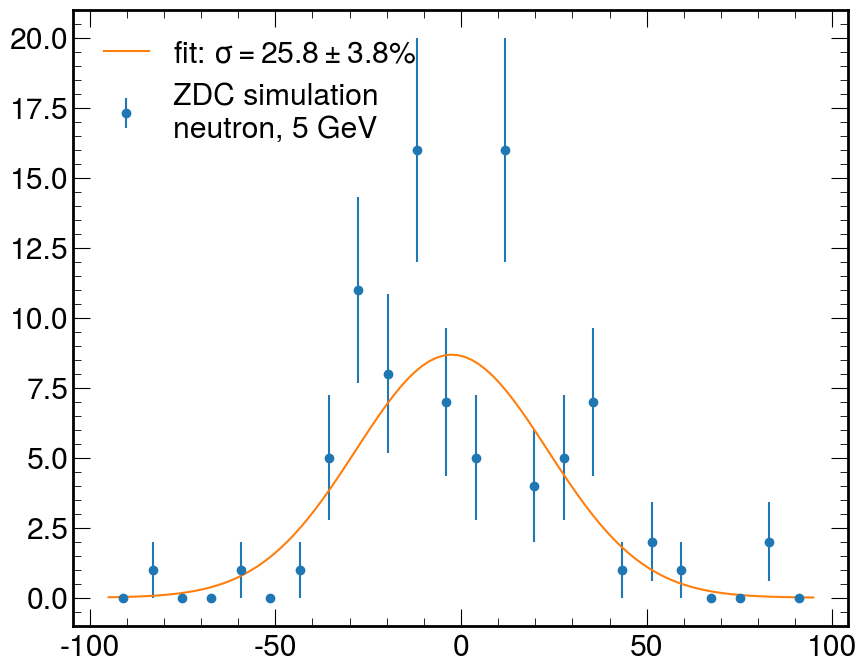

10 GeV, done with event 0/100
10 GeV, done with event 10/100
10 GeV, done with event 20/100
10 GeV, done with event 30/100
10 GeV, done with event 40/100
10 GeV, done with event 50/100
10 GeV, done with event 60/100
10 GeV, done with event 70/100
10 GeV, done with event 80/100
10 GeV, done with event 90/100
fit: $\sigma=17.9\pm2.1$ mm


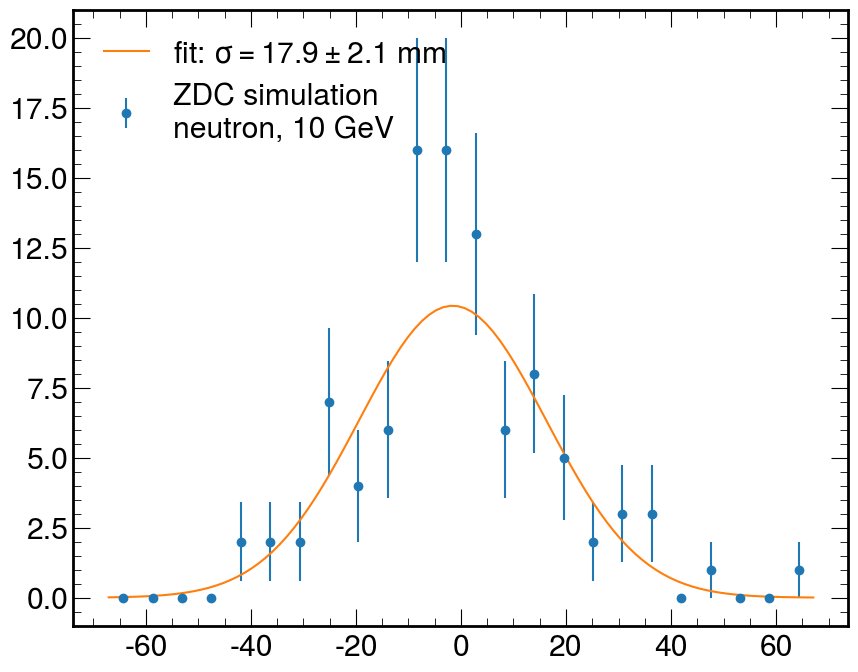

fit: $\sigma=15.1\pm1.3$%


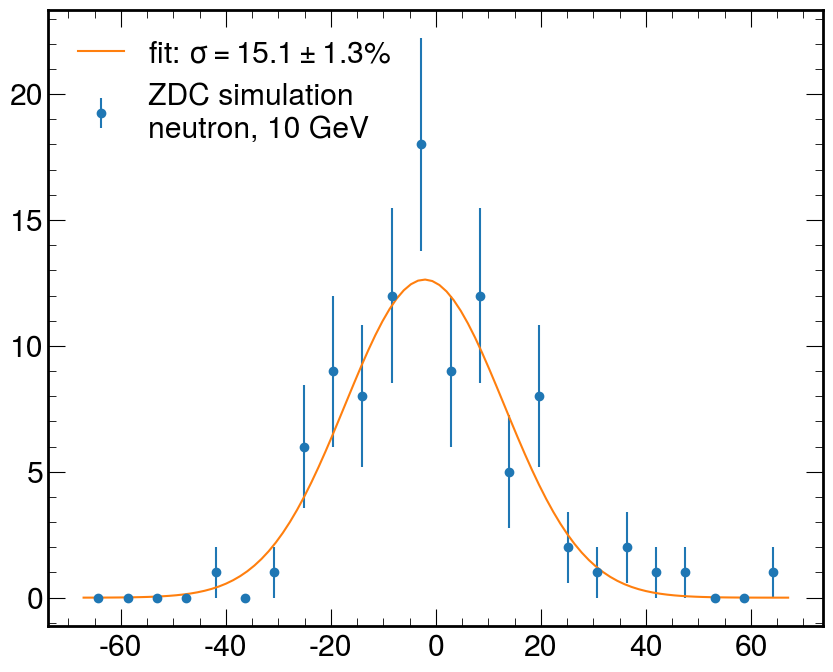

20 GeV, done with event 0/100
20 GeV, done with event 10/100
20 GeV, done with event 20/100
20 GeV, done with event 30/100
20 GeV, done with event 40/100
20 GeV, done with event 50/100
20 GeV, done with event 60/100
20 GeV, done with event 70/100
20 GeV, done with event 80/100
20 GeV, done with event 90/100
fit: $\sigma=8.6\pm0.8$ mm


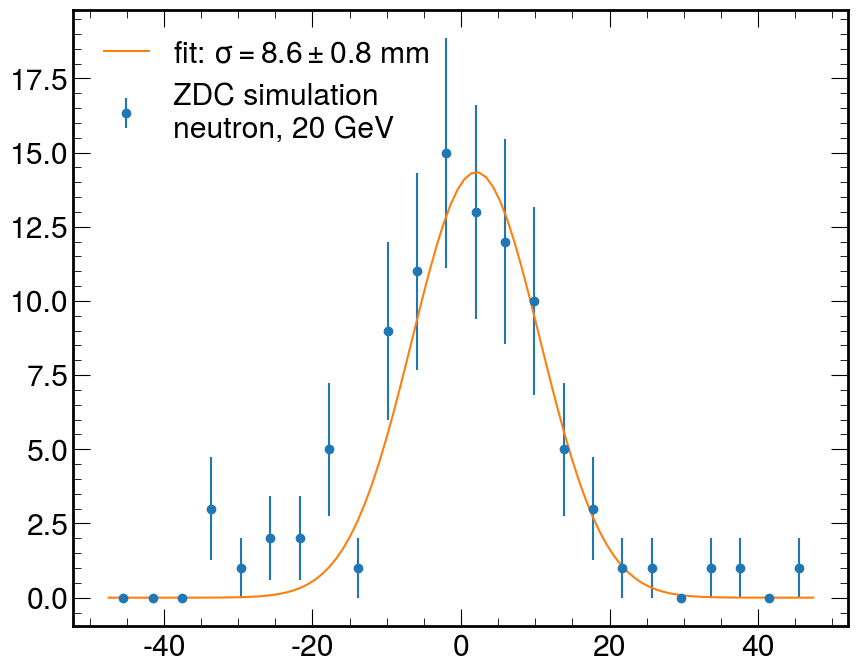

fit: $\sigma=11.0\pm0.9$%


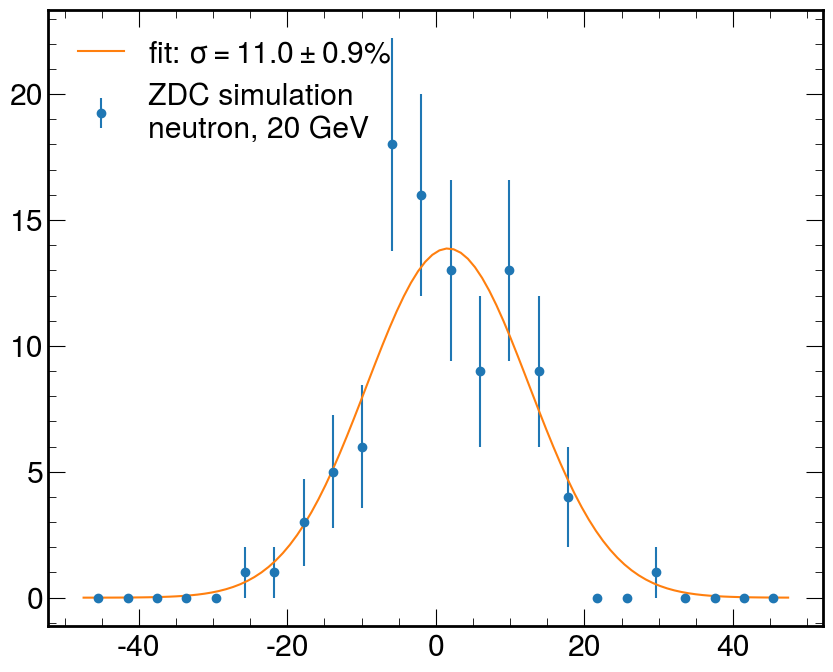

30 GeV, done with event 0/100
30 GeV, done with event 10/100
30 GeV, done with event 20/100
30 GeV, done with event 30/100
30 GeV, done with event 40/100
30 GeV, done with event 50/100
30 GeV, done with event 60/100
30 GeV, done with event 70/100
30 GeV, done with event 80/100
30 GeV, done with event 90/100
fit: $\sigma=9.9\pm0.9$ mm


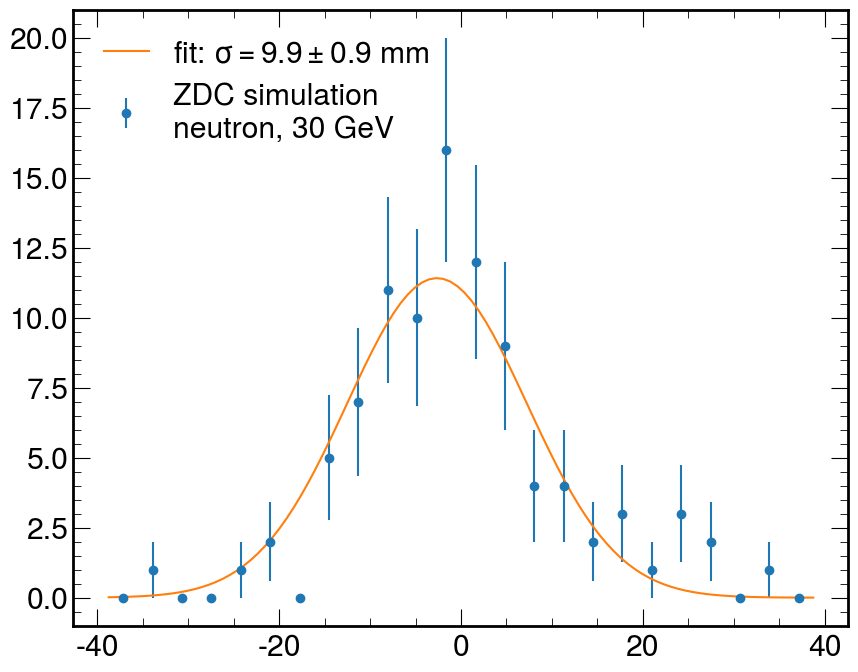

fit: $\sigma=9.6\pm0.9$%


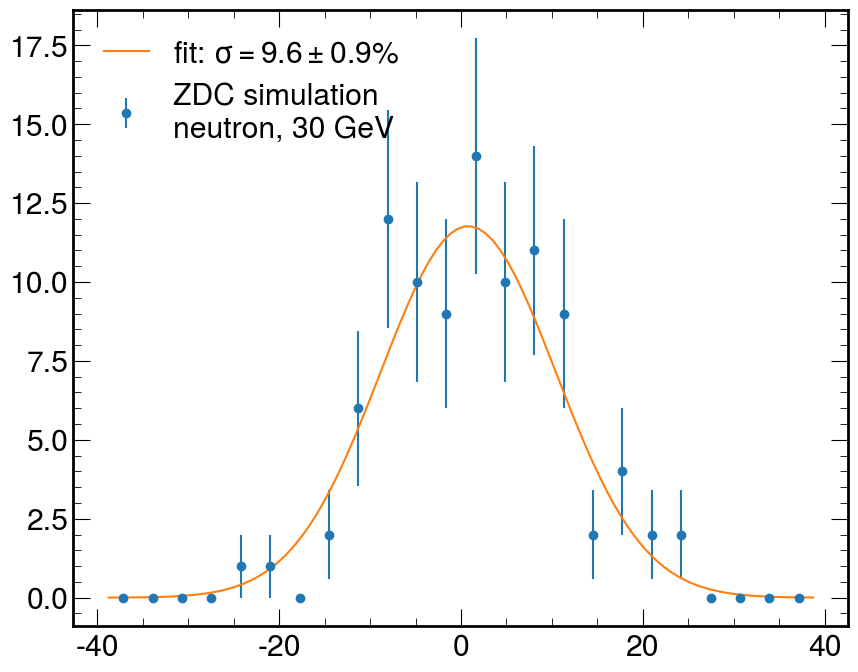

50 GeV, done with event 0/100
50 GeV, done with event 10/100
50 GeV, done with event 20/100
50 GeV, done with event 30/100
50 GeV, done with event 40/100
50 GeV, done with event 50/100
50 GeV, done with event 60/100
50 GeV, done with event 70/100
50 GeV, done with event 80/100
50 GeV, done with event 90/100
fit: $\sigma=6.6\pm0.7$ mm


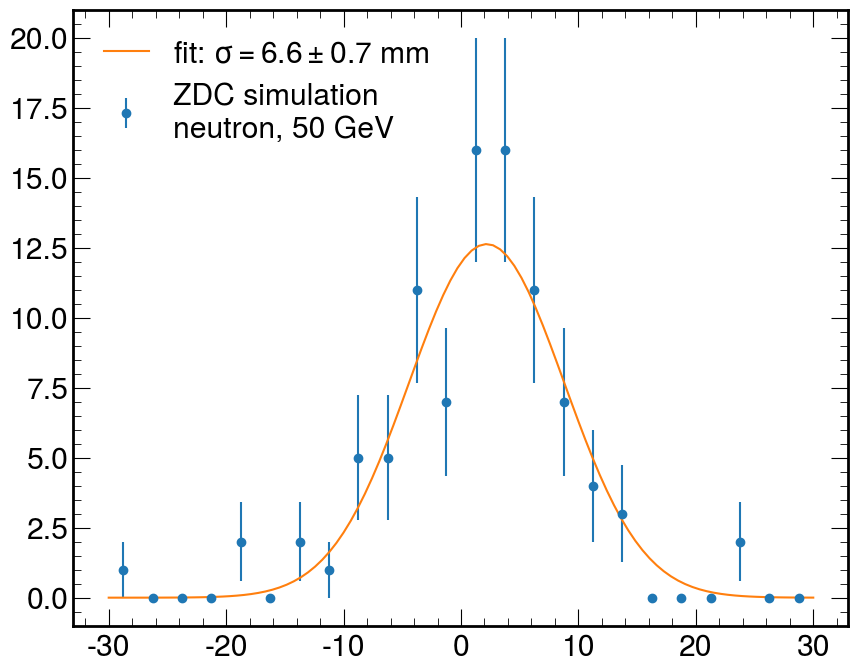

fit: $\sigma=6.7\pm0.5$%


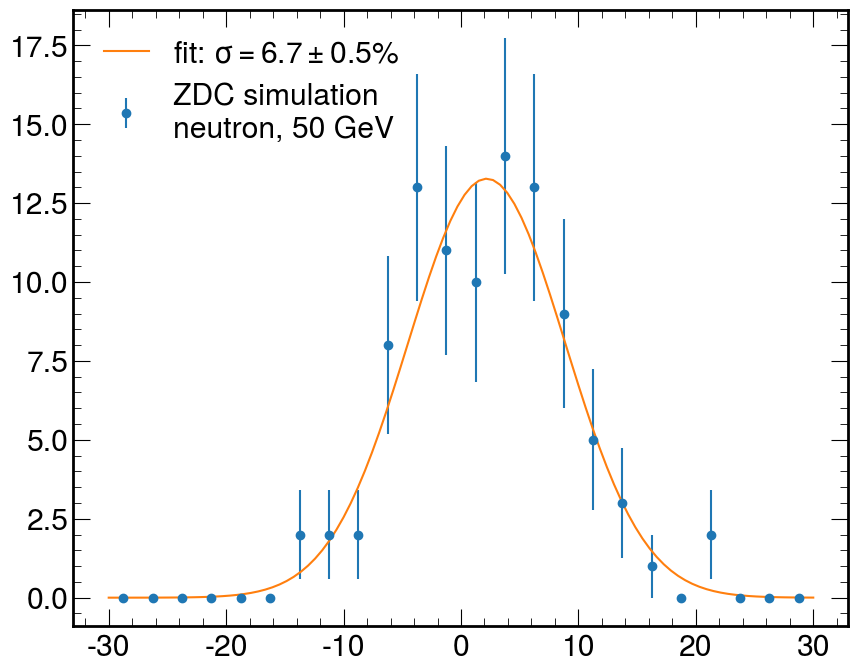

60 GeV, done with event 0/100
60 GeV, done with event 10/100
60 GeV, done with event 20/100
60 GeV, done with event 30/100
60 GeV, done with event 40/100
60 GeV, done with event 50/100
60 GeV, done with event 60/100
60 GeV, done with event 70/100
60 GeV, done with event 80/100
60 GeV, done with event 90/100
fit: $\sigma=6.4\pm0.8$ mm


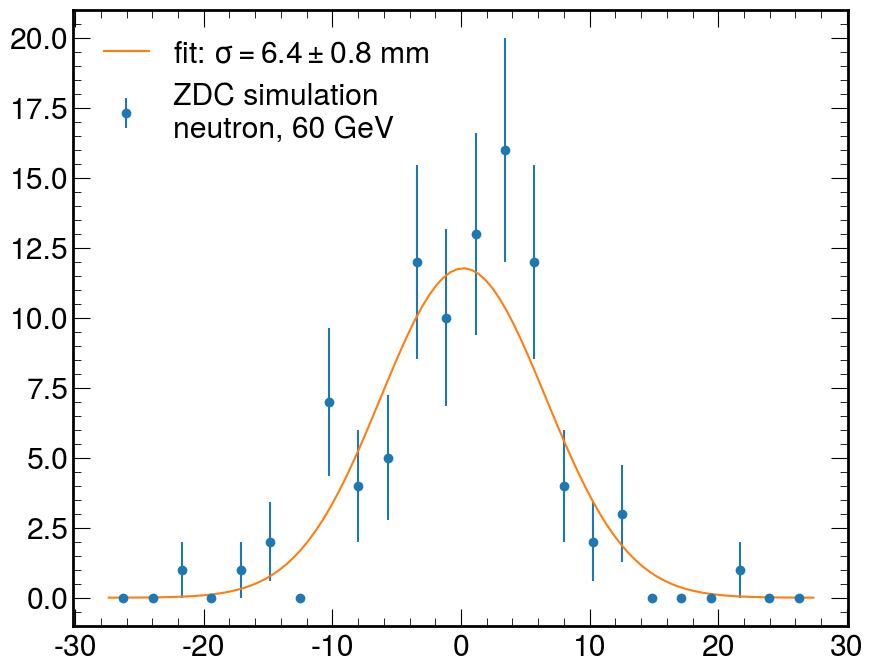

fit: $\sigma=6.1\pm0.5$%


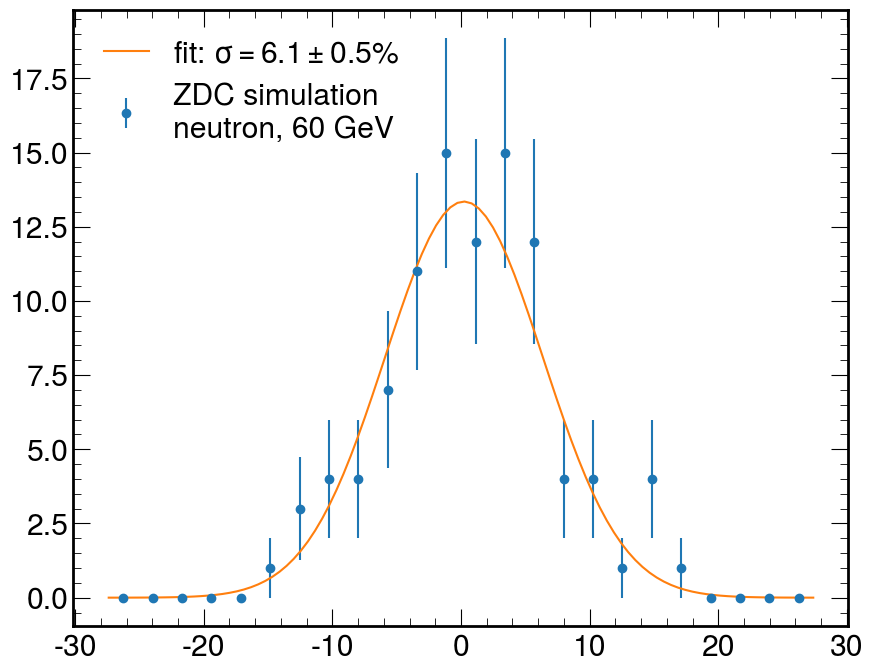

70 GeV, done with event 0/100
70 GeV, done with event 10/100
70 GeV, done with event 20/100
70 GeV, done with event 30/100
70 GeV, done with event 40/100
70 GeV, done with event 50/100
70 GeV, done with event 60/100
70 GeV, done with event 70/100
70 GeV, done with event 80/100
70 GeV, done with event 90/100
fit: $\sigma=4.6\pm0.4$ mm


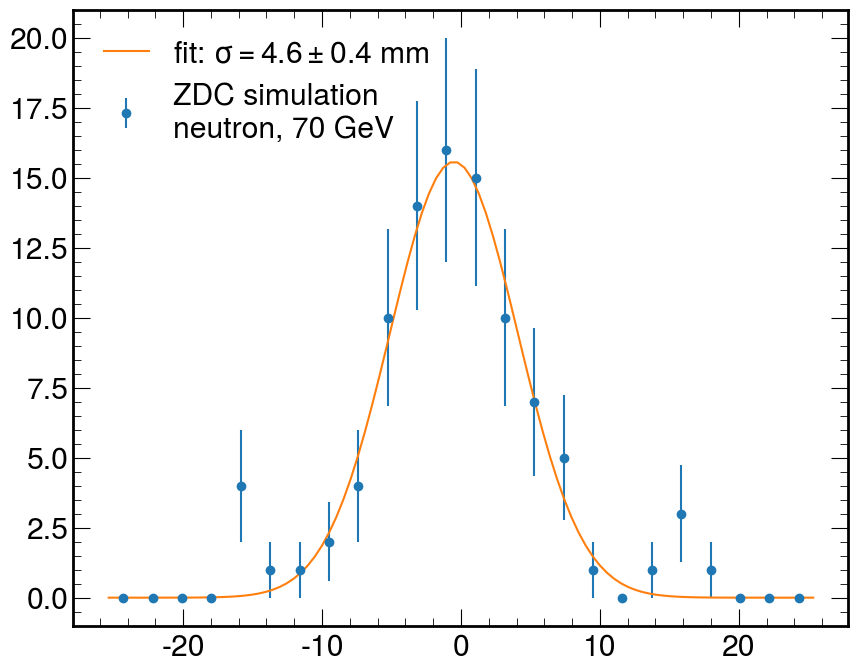

fit: $\sigma=7.9\pm1.0$%


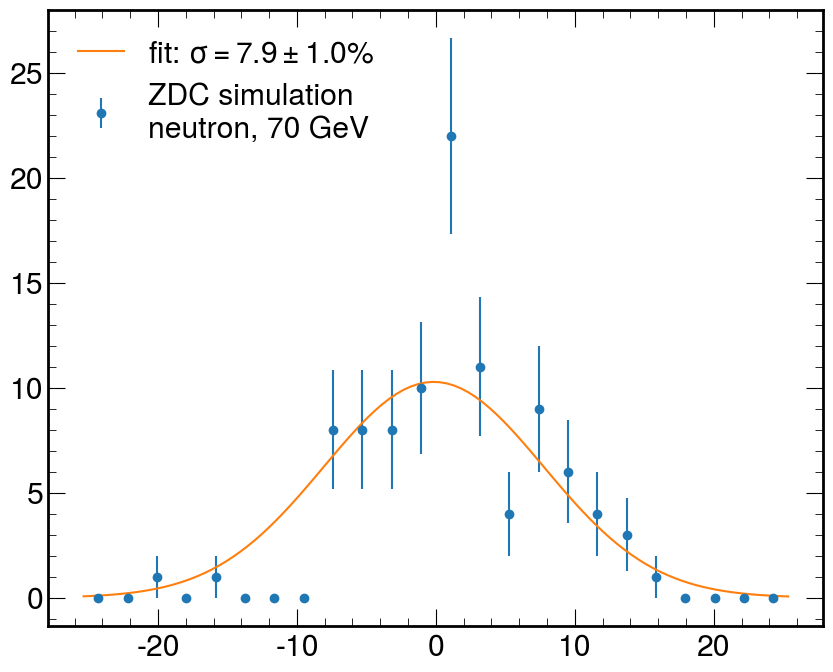

80 GeV, done with event 0/100
80 GeV, done with event 10/100
80 GeV, done with event 20/100
80 GeV, done with event 30/100
80 GeV, done with event 40/100
80 GeV, done with event 50/100
80 GeV, done with event 60/100
80 GeV, done with event 70/100
80 GeV, done with event 80/100
80 GeV, done with event 90/100
fit: $\sigma=5.9\pm0.7$ mm


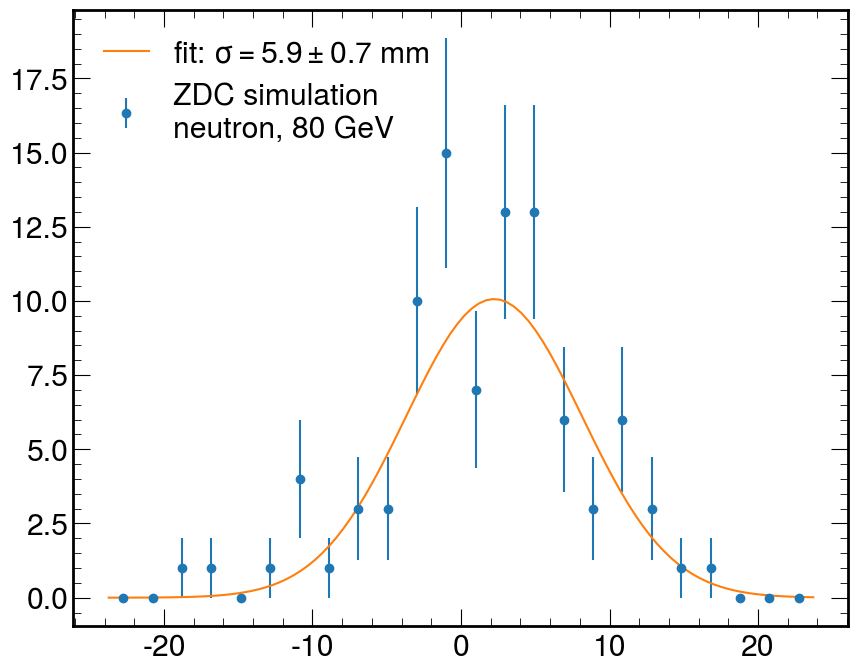

fit: $\sigma=4.3\pm0.5$%


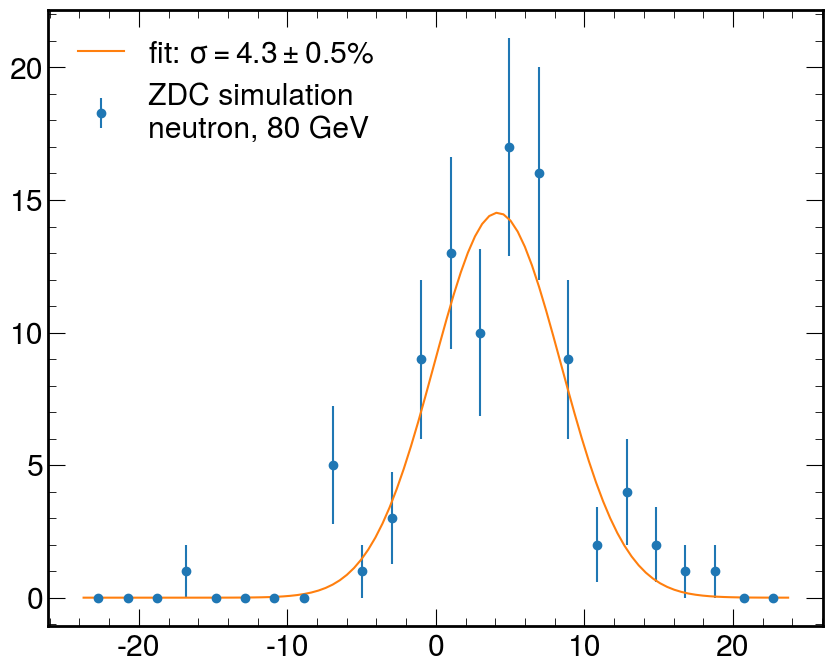

90 GeV, done with event 0/100
90 GeV, done with event 10/100
90 GeV, done with event 20/100
90 GeV, done with event 30/100
90 GeV, done with event 40/100
90 GeV, done with event 50/100
90 GeV, done with event 60/100
90 GeV, done with event 70/100
90 GeV, done with event 80/100
90 GeV, done with event 90/100
fit: $\sigma=5.7\pm0.4$ mm


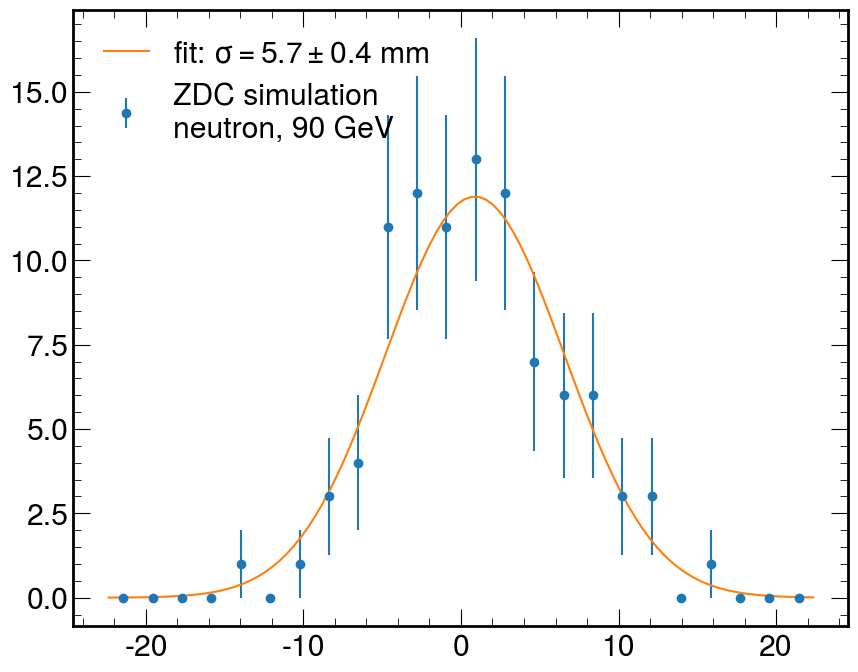

fit: $\sigma=5.6\pm0.6$%


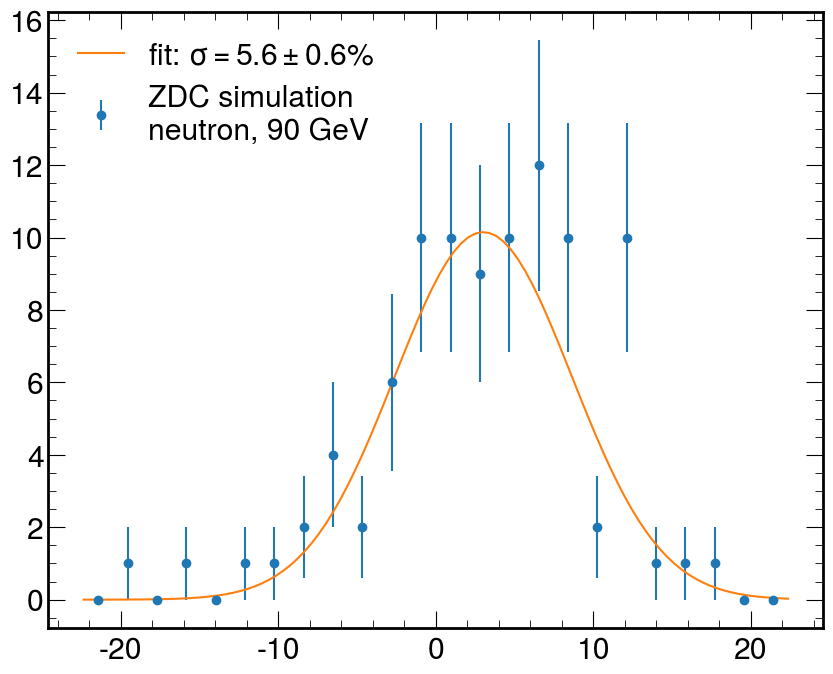

100 GeV, done with event 0/100
100 GeV, done with event 10/100
100 GeV, done with event 20/100
100 GeV, done with event 30/100
100 GeV, done with event 40/100
100 GeV, done with event 50/100
100 GeV, done with event 60/100
100 GeV, done with event 70/100
100 GeV, done with event 80/100
100 GeV, done with event 90/100
fit: $\sigma=3.9\pm0.4$ mm


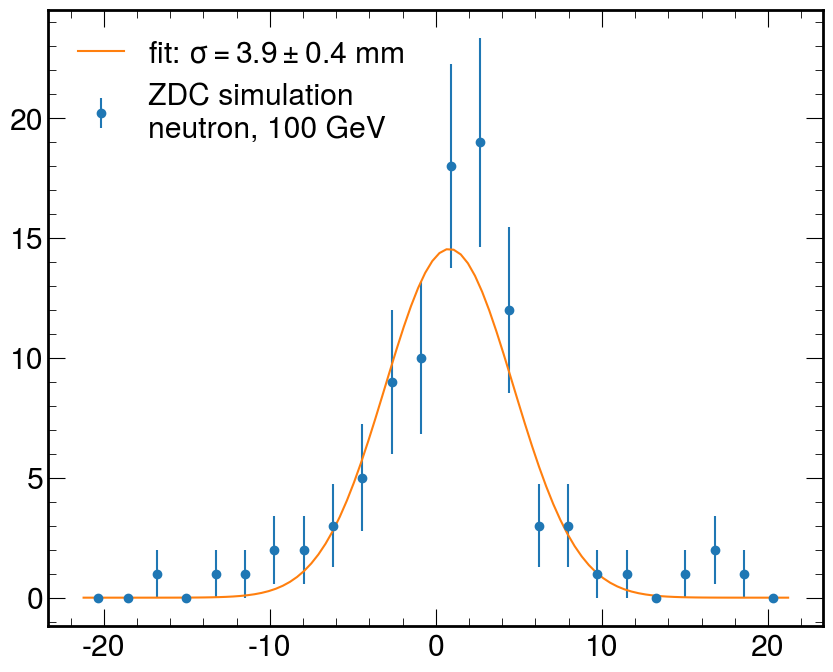

fit: $\sigma=4.8\pm0.4$%


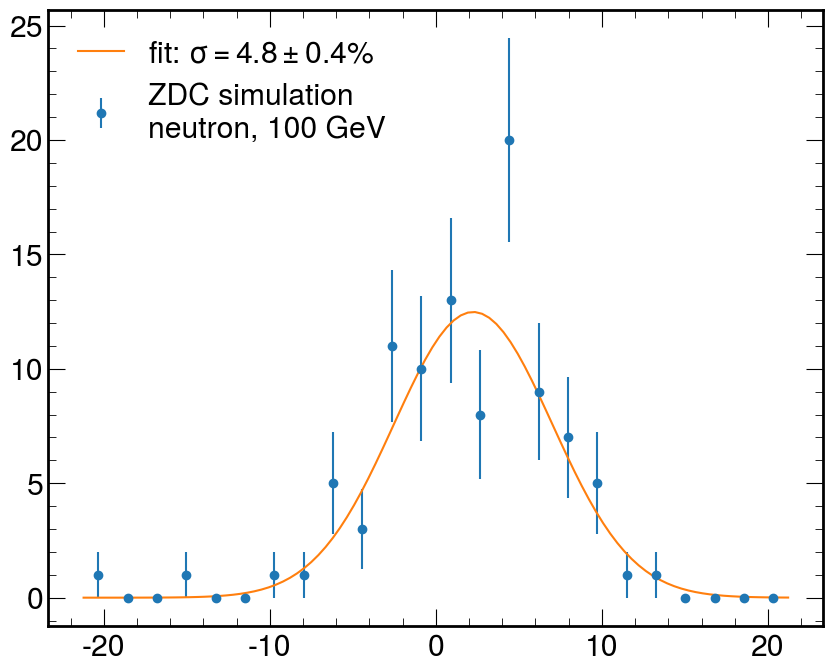

In [6]:
import uproot as ur
print("a")
r_res_vals=[]
r_res_errs=[]
E_res_vals=[]
E_res_errs=[]
Ebeams=(1,2,5, 10, 20, 30, 50, 60, 70, 80, 90, 100)
for Ebeam in Ebeams:
    events = ur.open(f'cache/staggered_h3_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root:events')
    arrays = events.arrays()
    #print(len(arrays))
    #print(arrays.fields)
    w0=5; b=0.05

    drs=[]
    dxs=[]
    dys=[]
    Es=[]
    nevents=100
    for event in range(nevents):
        #print(len(arrays['ZDCHitsReco.position.x'][event]))
        try:
            x_reco, y_reco, _, r_reco=get_xyzr_reco_reweighted(arrays, event, w0=w0, weight_by_granularity=True,b=b, prefix='ZDC')
            x_truth, y_truth, _, r_truth=get_xyzr_truth(arrays, event, w0=w0, weight_by_granularity=True, prefix='ZDC')
            drs.append(r_reco-r_truth)
            Es.append(sum(arrays[f'ZDCHitsReco.energy'][event]))

        except:
            pass

        if event%10==0:
            print(f"{Ebeam} GeV, done with event {event}/{nevents}")
    res,dres, eb, curve= res_plot(drs, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.show()
    r_res_vals.append(res)
    r_res_errs.append(dres)
    
    res,dres, eb, curve= res_plot(100*(np.array(Es)/np.mean(Es)-1), bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), 
                                  label=f"ZDC simulation\nneutron, {Ebeam} GeV", unit="%")
    plt.show()
    E_res_vals.append(res)
    E_res_errs.append(dres)
    
    

b
1 GeV, done with event 0/100
1 GeV, done with event 10/100
1 GeV, done with event 20/100
1 GeV, done with event 30/100
1 GeV, done with event 40/100
1 GeV, done with event 50/100
1 GeV, done with event 60/100
1 GeV, done with event 70/100
1 GeV, done with event 80/100
1 GeV, done with event 90/100
fit: $\sigma=49.7\pm3.9$ mm


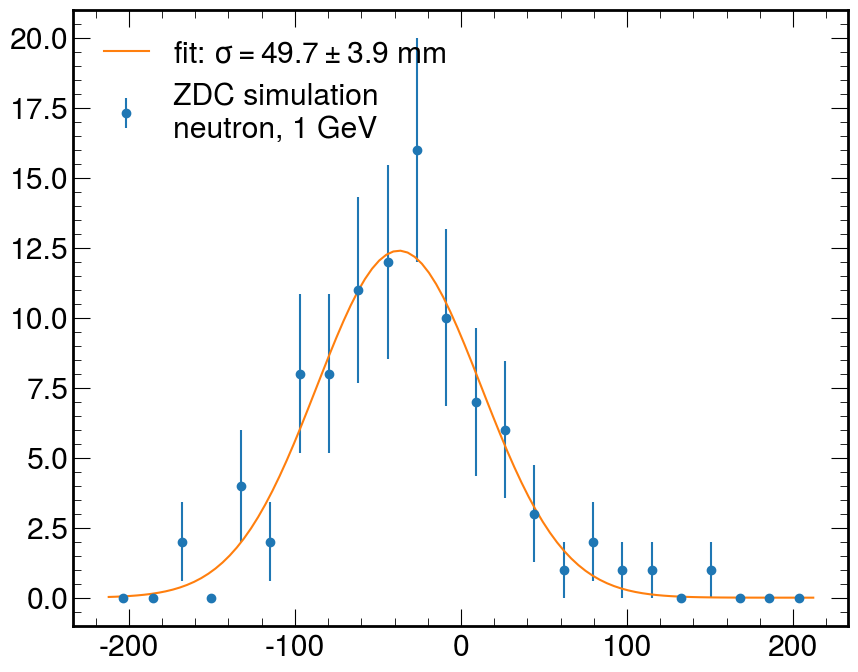

fit: $\sigma=117.6\pm39.0$%


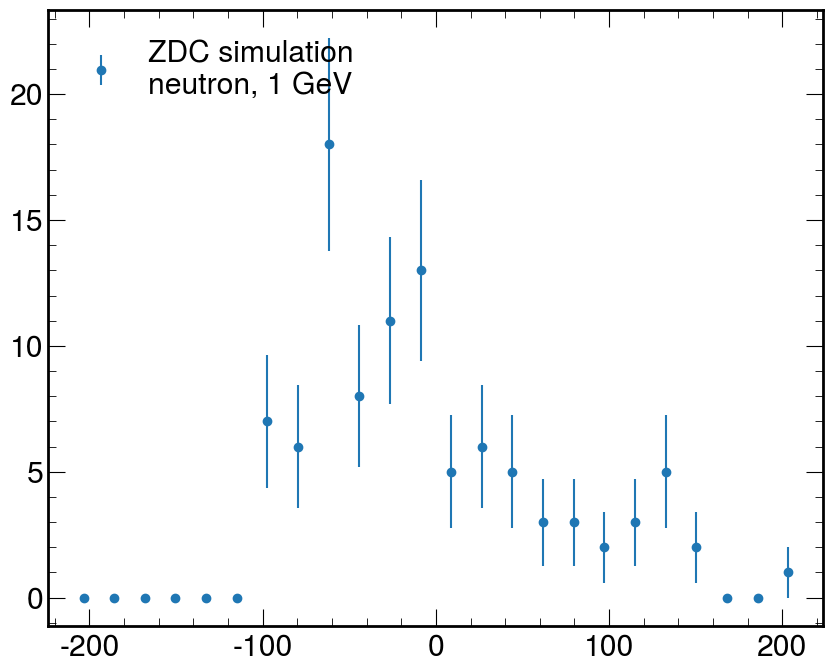

2 GeV, done with event 0/100
2 GeV, done with event 10/100
2 GeV, done with event 20/100
2 GeV, done with event 30/100
2 GeV, done with event 40/100
2 GeV, done with event 50/100
2 GeV, done with event 60/100
2 GeV, done with event 70/100
2 GeV, done with event 80/100
2 GeV, done with event 90/100
fit: $\sigma=30.9\pm3.1$ mm


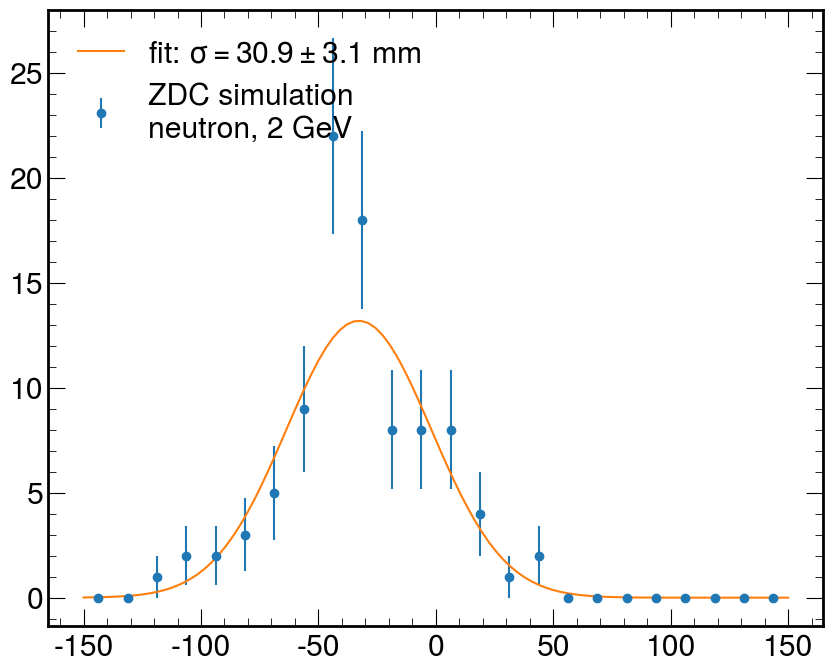

fit: $\sigma=50.7\pm5.4$%


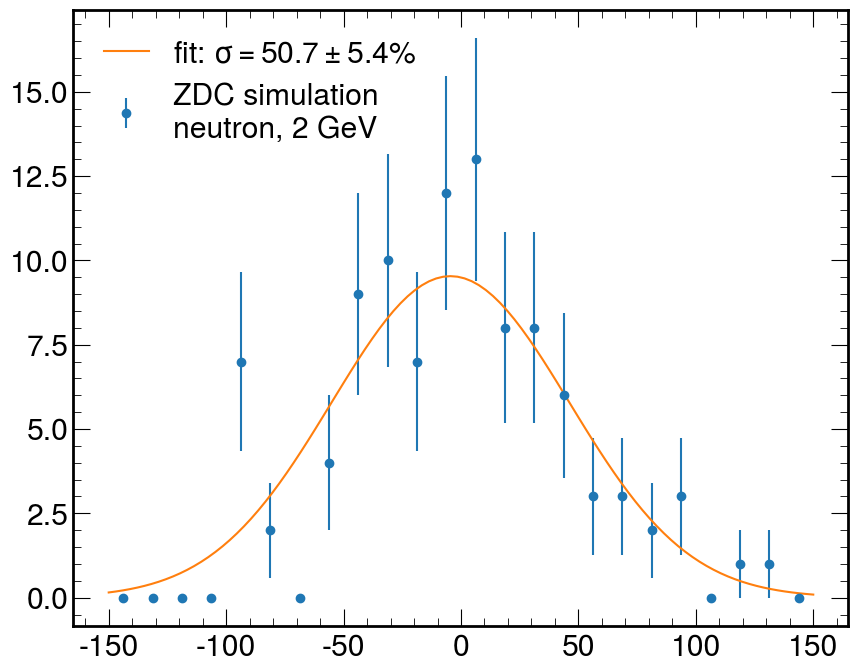

5 GeV, done with event 0/100
5 GeV, done with event 10/100
5 GeV, done with event 20/100
5 GeV, done with event 30/100
5 GeV, done with event 40/100
5 GeV, done with event 50/100
5 GeV, done with event 60/100
5 GeV, done with event 70/100
5 GeV, done with event 80/100
5 GeV, done with event 90/100
fit: $\sigma=30.0\pm2.7$ mm


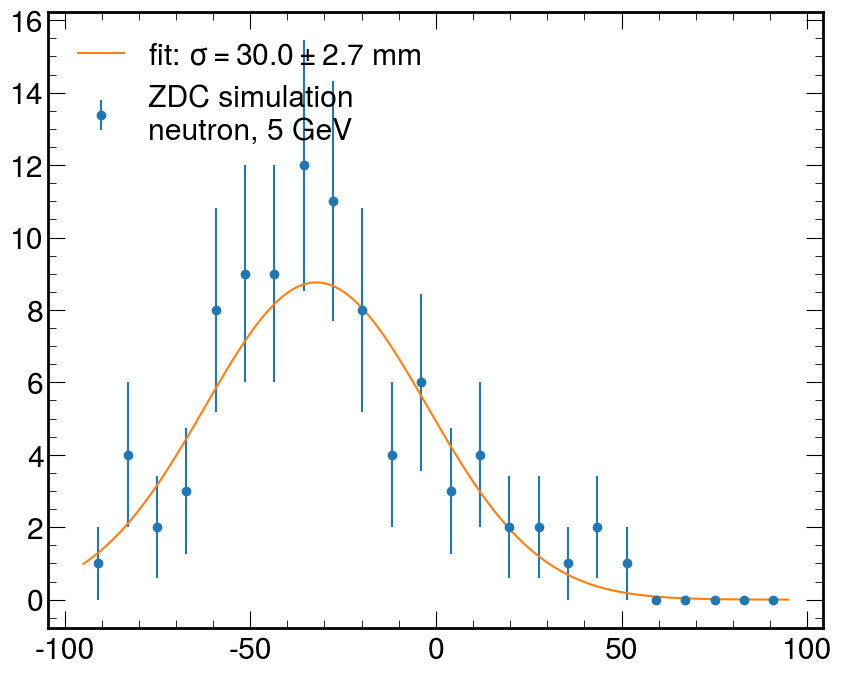

fit: $\sigma=26.0\pm2.4$%


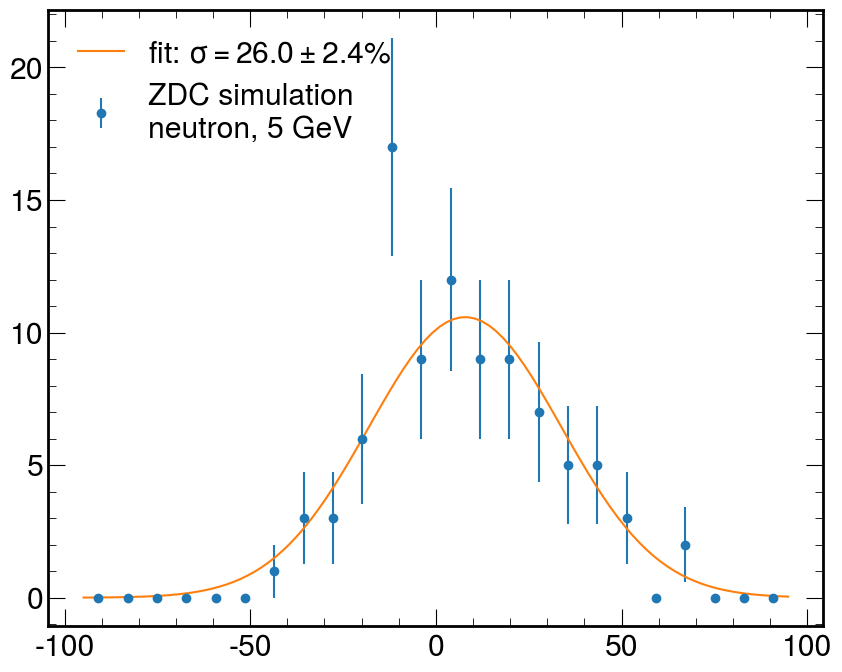

10 GeV, done with event 0/100
10 GeV, done with event 10/100
10 GeV, done with event 20/100
10 GeV, done with event 30/100
10 GeV, done with event 40/100
10 GeV, done with event 50/100
10 GeV, done with event 60/100
10 GeV, done with event 70/100
10 GeV, done with event 80/100
10 GeV, done with event 90/100
fit: $\sigma=21.7\pm4.0$ mm


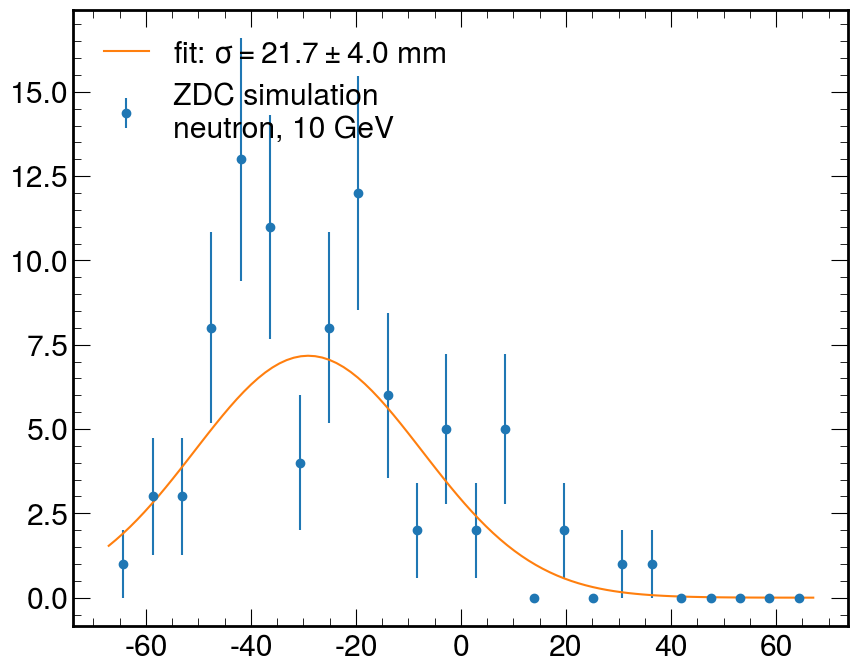

fit: $\sigma=19.0\pm2.1$%


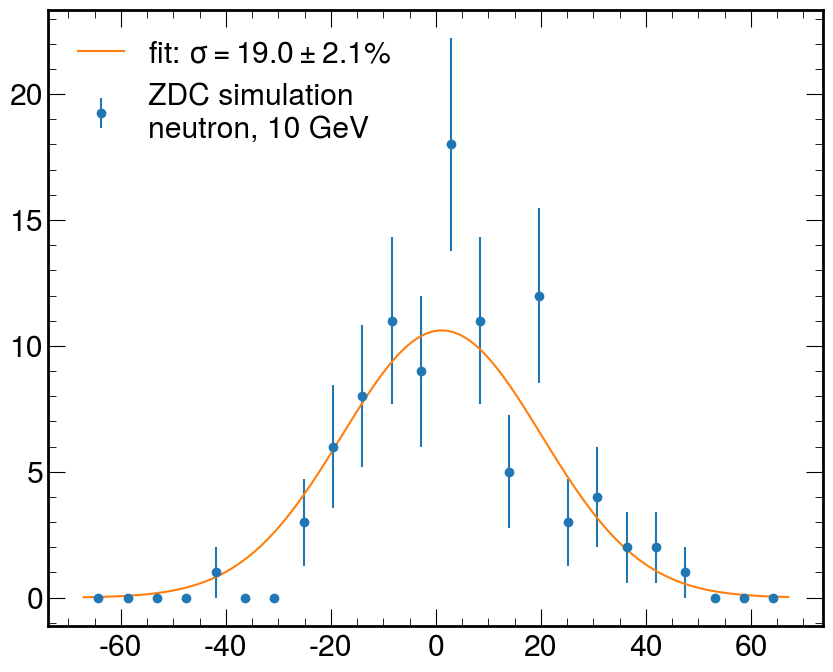

20 GeV, done with event 0/100
20 GeV, done with event 10/100
20 GeV, done with event 20/100
20 GeV, done with event 30/100
20 GeV, done with event 40/100
20 GeV, done with event 50/100
20 GeV, done with event 60/100
20 GeV, done with event 70/100
20 GeV, done with event 80/100
20 GeV, done with event 90/100
fit: $\sigma=31.4\pm9.7$ mm


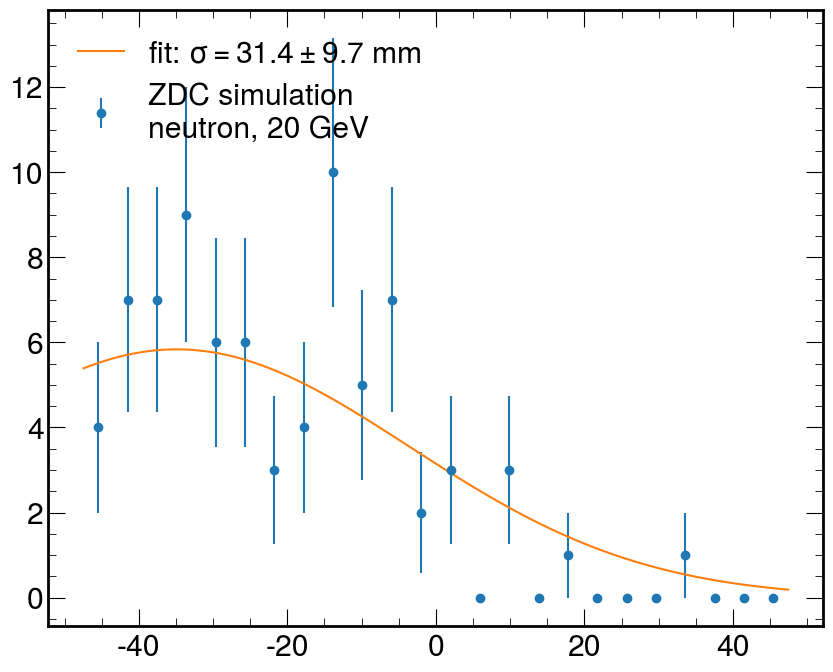

fit: $\sigma=13.6\pm0.9$%


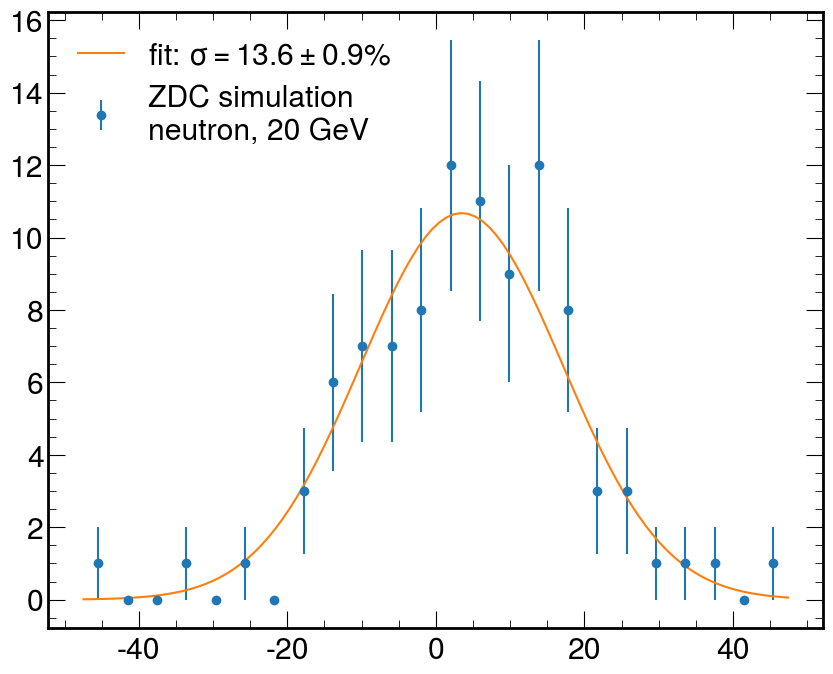

30 GeV, done with event 0/100
30 GeV, done with event 10/100
30 GeV, done with event 20/100
30 GeV, done with event 30/100
30 GeV, done with event 40/100
30 GeV, done with event 50/100
30 GeV, done with event 60/100
30 GeV, done with event 70/100
30 GeV, done with event 80/100
30 GeV, done with event 90/100
fit: $\sigma=27.2\pm6.4$ mm


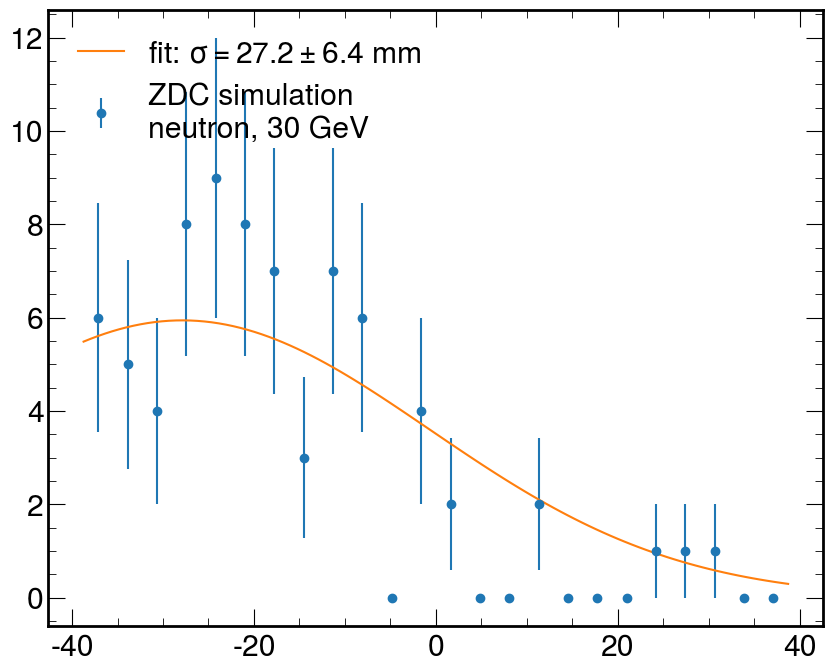

fit: $\sigma=9.2\pm1.5$%


KeyboardInterrupt: 

In [6]:
import uproot as ur
print("b")
r_res_vals_h1=[]
r_res_errs_h1=[]
E_res_vals_h1=[]
E_res_errs_h1=[]
Ebeams=(1,2, 5, 10, 20, 30,40,50, 60, 70)
for Ebeam in Ebeams:
    events = ur.open(f'cache/unstaggered_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root:events')
    arrays = events.arrays()
    #print(len(arrays))
    #print(arrays.fields)
    w0=4

    drs=[]
    dxs=[]
    dys=[]
    Es=[]
    nevents=100
    for event in range(nevents):
        #print(arrays['ZDCHitsReco.energy'][event])
        #print(len(arrays['ZDCHitsReco.position.x'][event]))
        try:
            Es.append(sum(arrays[f'ZDCHitsReco.energy'][event]))
            x_reco, y_reco, _, r_reco=get_xyzr_reco(arrays, event, w0=w0, weight_by_granularity=True, prefix='ZDC')
            x_truth, y_truth, _, r_truth=get_xyzr_truth(arrays, event, w0=w0, weight_by_granularity=True, prefix='ZDC')
            drs.append(r_reco-r_truth)

        except:
            pass

        if event%10==0:
            print(f"{Ebeam} GeV, done with event {event}/{nevents}")
    res,dres, eb, curve= res_plot(drs, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.show()
    r_res_vals_h1.append(res)
    r_res_errs_h1.append(dres)
    
    res,dres, eb, curve= res_plot(100*(np.array(Es)/np.mean(Es)-1), bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), 
                                  label=f"ZDC simulation\nneutron, {Ebeam} GeV", unit="%")
    plt.show()
    E_res_vals_h1.append(res)
    E_res_errs_h1.append(dres)
    

In [ ]:
y=np.array(r_res_vals)/35
dy=np.array(r_res_errs)/35
Ebeams=(1,2,5, 10, 20, 30, 50, 60, 70, 80, 90, 100)
plt.errorbar(Ebeams, y, dy, marker='o', label='ZDC simulation\nneutrons', ls='')

fnc=lambda x, a: a/np.sqrt(x)
p0=[3]
coeff, var_matrix = curve_fit(fnc, Ebeams[:len(y)], y, p0=p0,
                             sigma=dy)

label=f"fit:  $\\frac{{{coeff[0]:.1f}\pm {np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}$ mrad"
        #+ f" \\oplus {coeff[1]:.1f}\pm {np.sqrt(var_matrix[1][1]):.1f}$ mm" 

x=np.linspace(1, 100, 200)
plt.plot(x, fnc(x, *coeff), label=label)

plt.ylabel("$\\theta$ resolution [mrad]")
plt.xlabel("$E$ [GeV]")
plt.ylim(0,2)

plt.plot(x, 3/np.sqrt(x), label="YR requirement: $\\frac{3.0}{\\sqrt{E}}$ mrad", ls='-')
plt.legend()
plt.show()

In [ ]:
y=np.array(E_res_vals)
dy=np.array(E_res_errs)
plt.errorbar(Ebeams, y, dy, marker='o', label='ZDC simulation\nneutrons', ls='')

fnc=lambda x, a: a/np.sqrt(x)
p0=[3]
coeff, var_matrix = curve_fit(fnc, Ebeams, y, p0=p0,
                             sigma=dy)

label=f"fit:  $\\frac{{{coeff[0]:.1f}\pm {np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}$ %"
        #+ f" \\oplus {coeff[1]:.1f}\pm {np.sqrt(var_matrix[1][1]):.1f}$ mm" 

x=np.linspace(1, 100, 200)
plt.plot(x, fnc(x, *coeff), label=label)

plt.ylabel("E resolution [%]")
plt.xlabel("$E$ [GeV]")

plt.plot(x, 50/np.sqrt(x), label="YR requirement: $\\frac{50}{\\sqrt{E}}$ %", ls='-')
plt.legend()
plt.show()

In [13]:
# new version of code:  use pre-processed files

fit: $\sigma=56.4\pm4.0$ mm


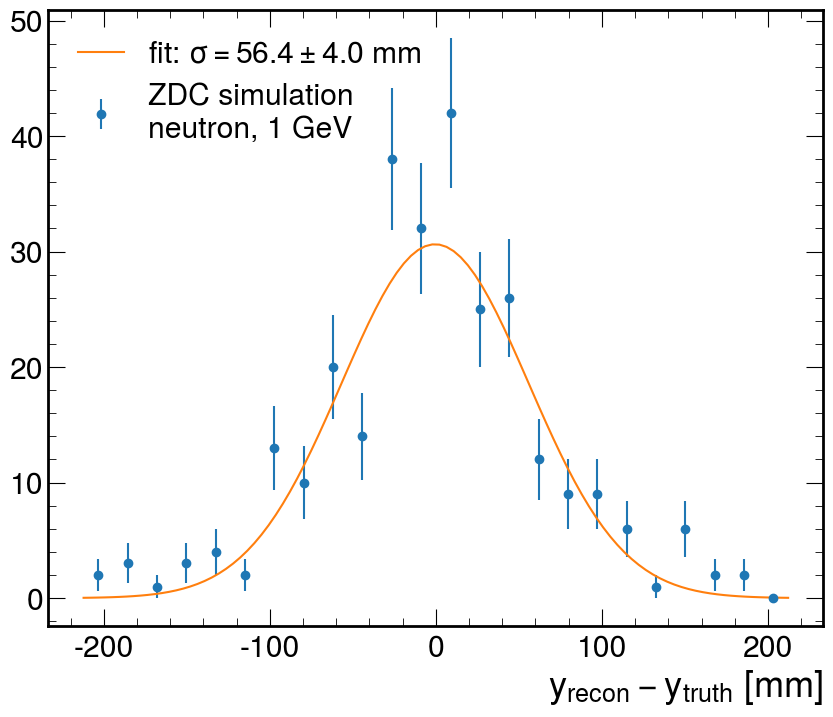

fit: $\sigma=72.6\pm9.7$%


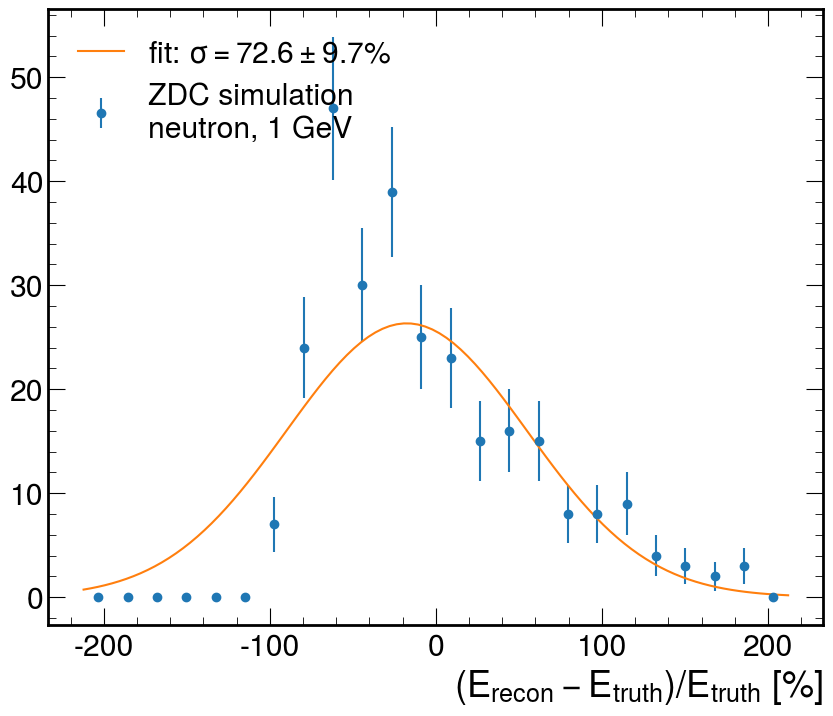

fit: $\sigma=34.4\pm2.7$ mm


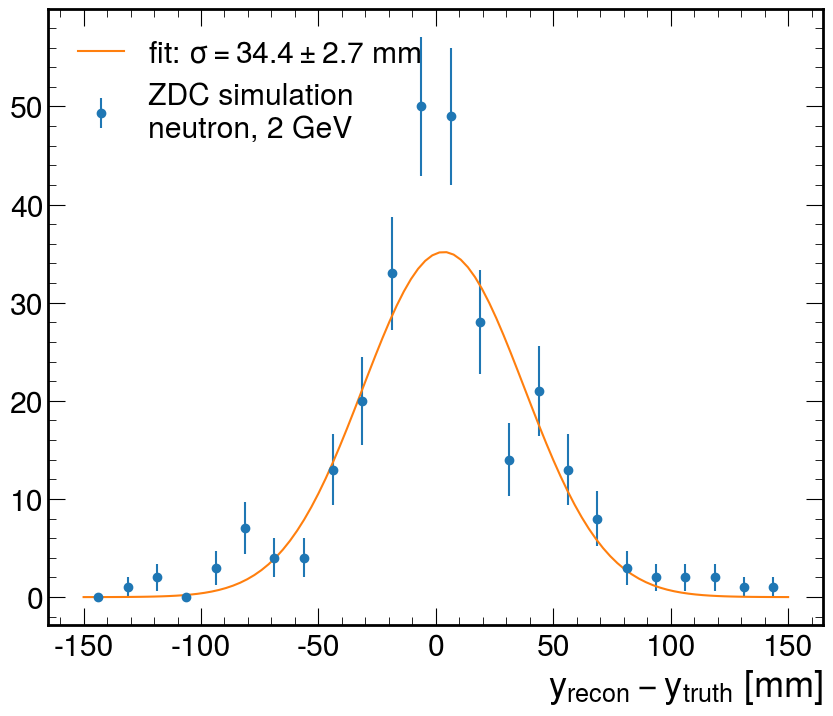

fit: $\sigma=33.8\pm1.9$%


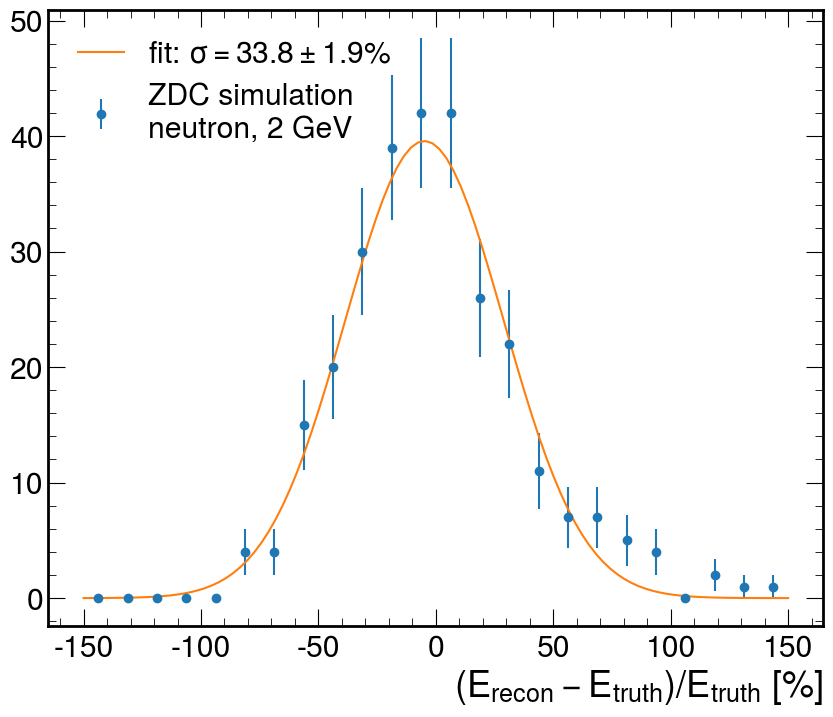

fit: $\sigma=28.7\pm1.3$ mm


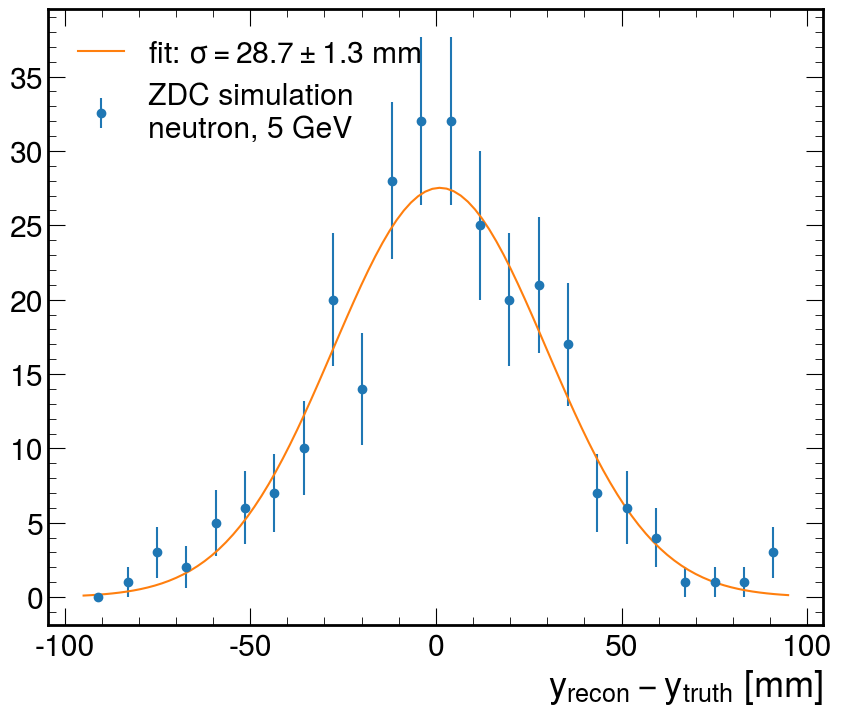

fit: $\sigma=23.2\pm1.3$%


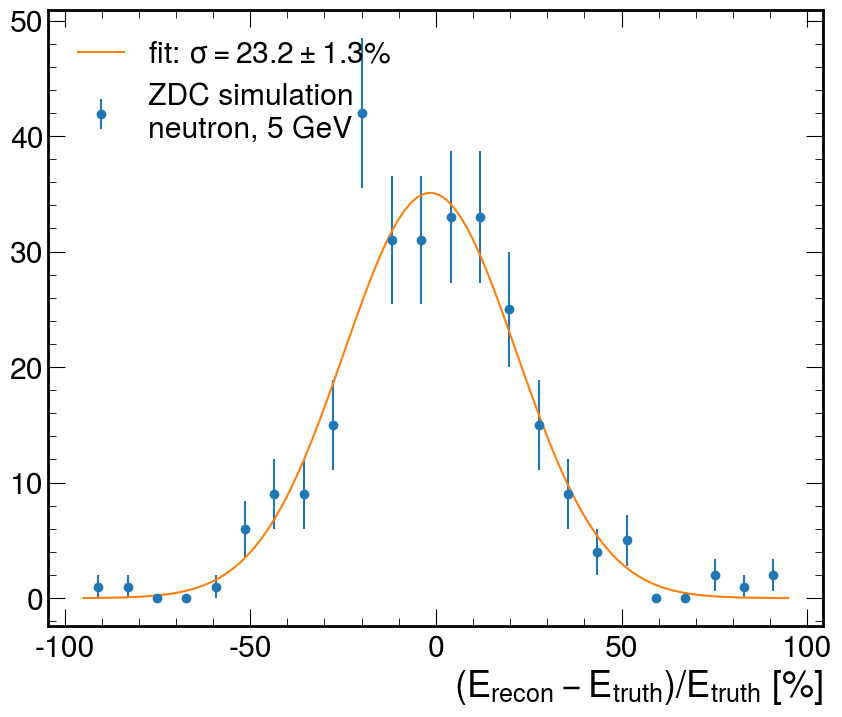

fit: $\sigma=22.0\pm0.8$ mm


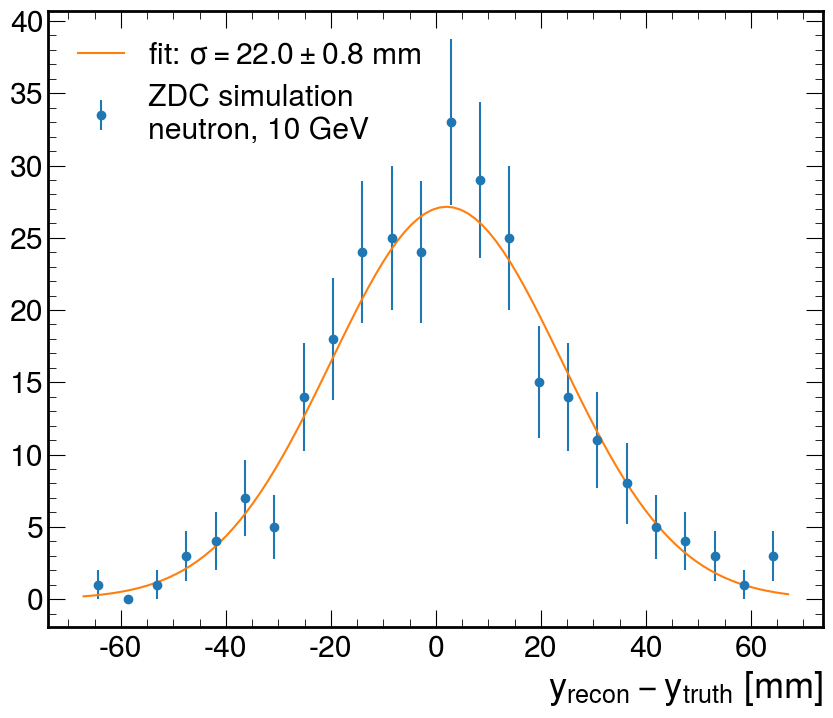

fit: $\sigma=15.6\pm0.8$%


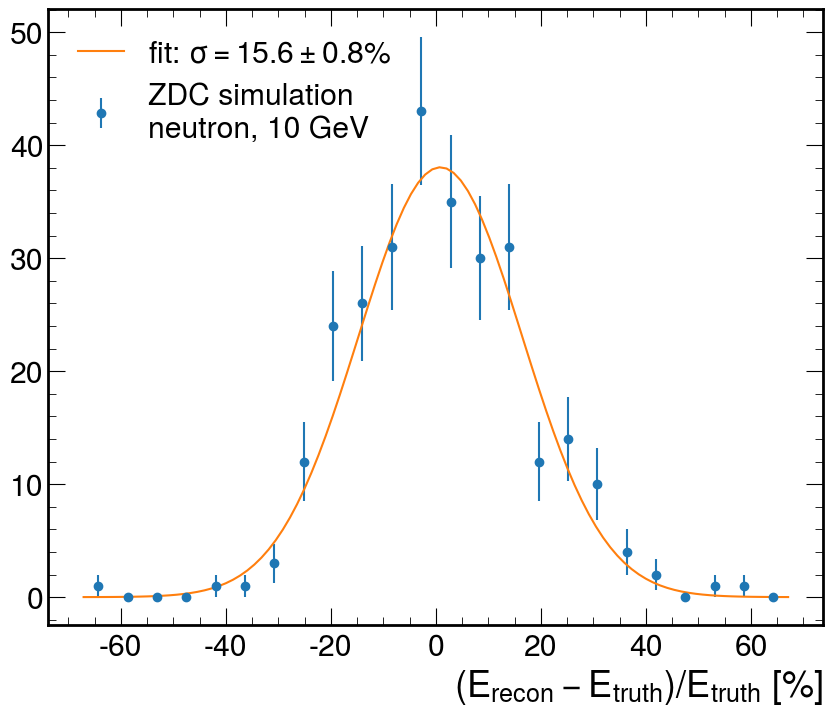

fit: $\sigma=15.8\pm1.0$ mm


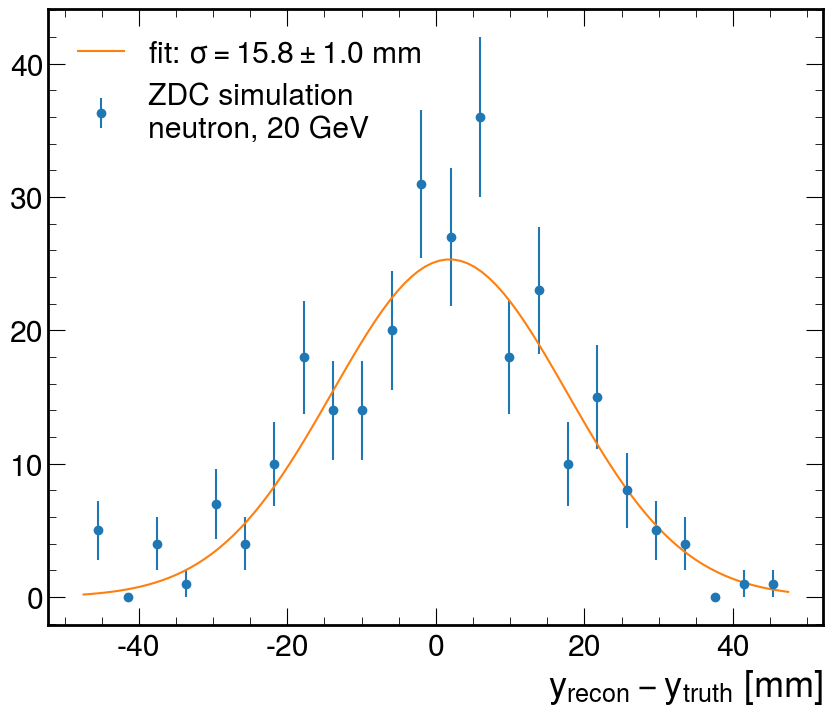

fit: $\sigma=11.2\pm0.4$%


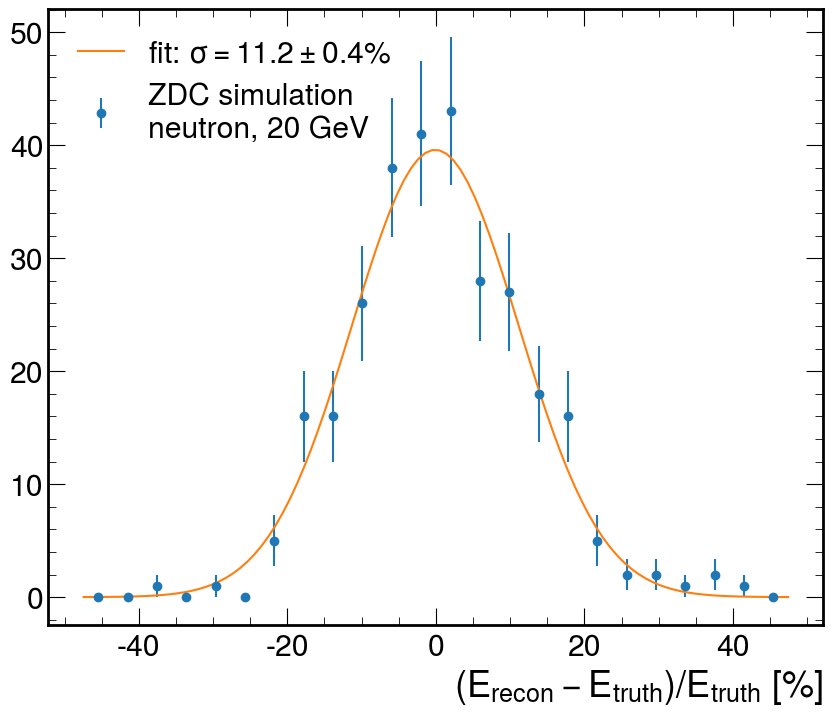

fit: $\sigma=12.4\pm0.4$ mm


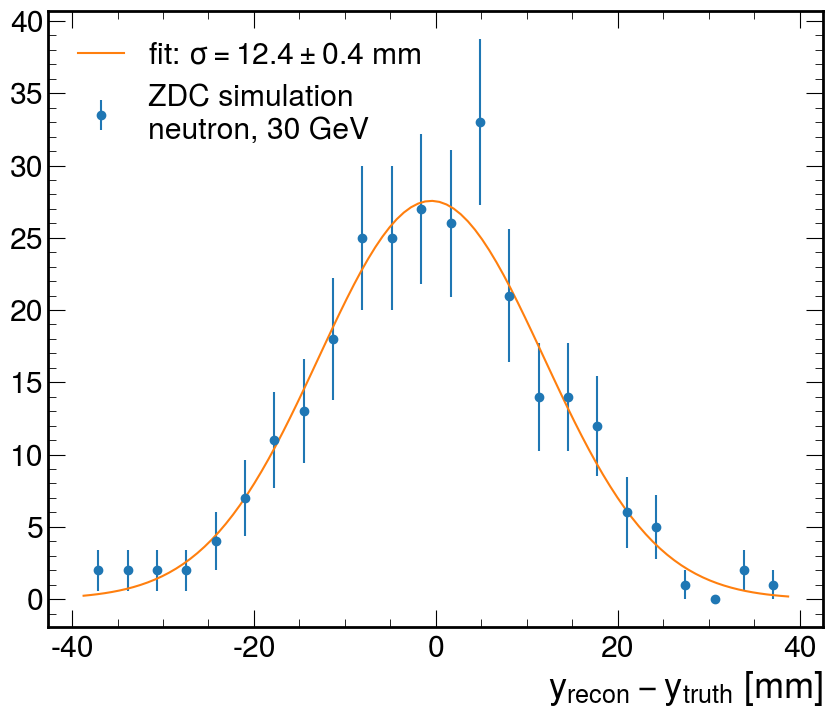

fit: $\sigma=7.9\pm0.3$%


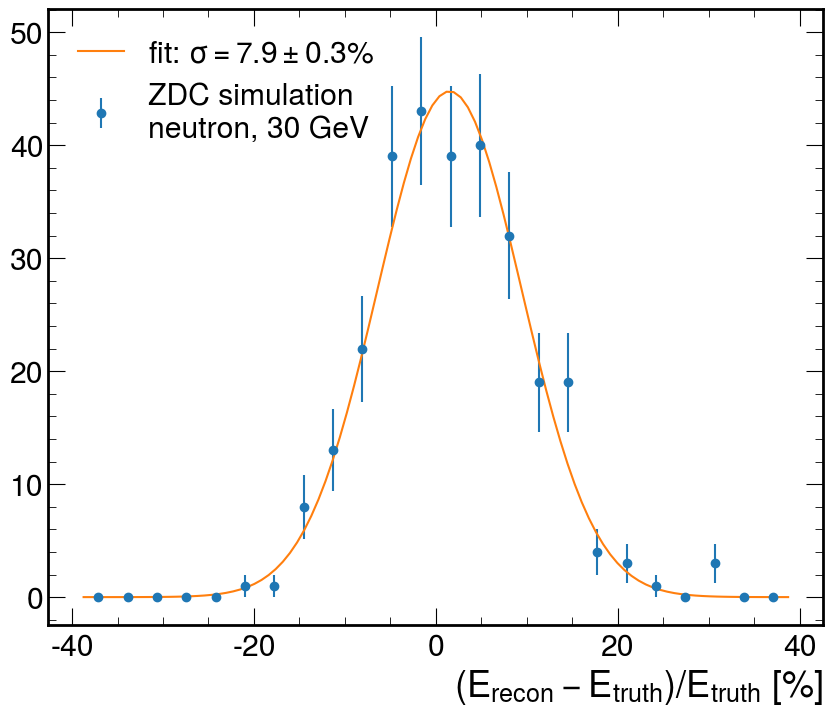

fit: $\sigma=12.2\pm0.9$ mm


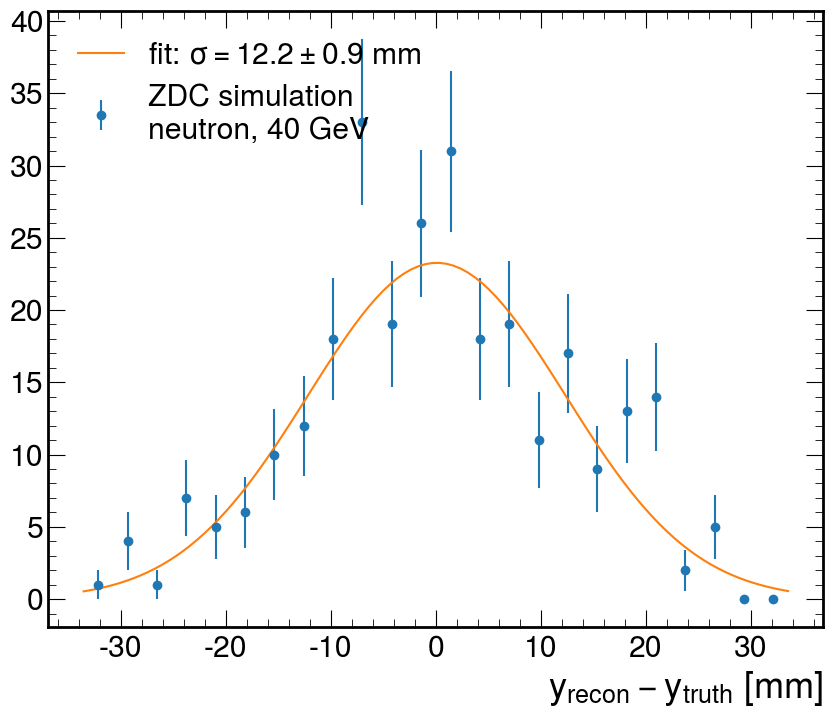

fit: $\sigma=7.6\pm0.3$%


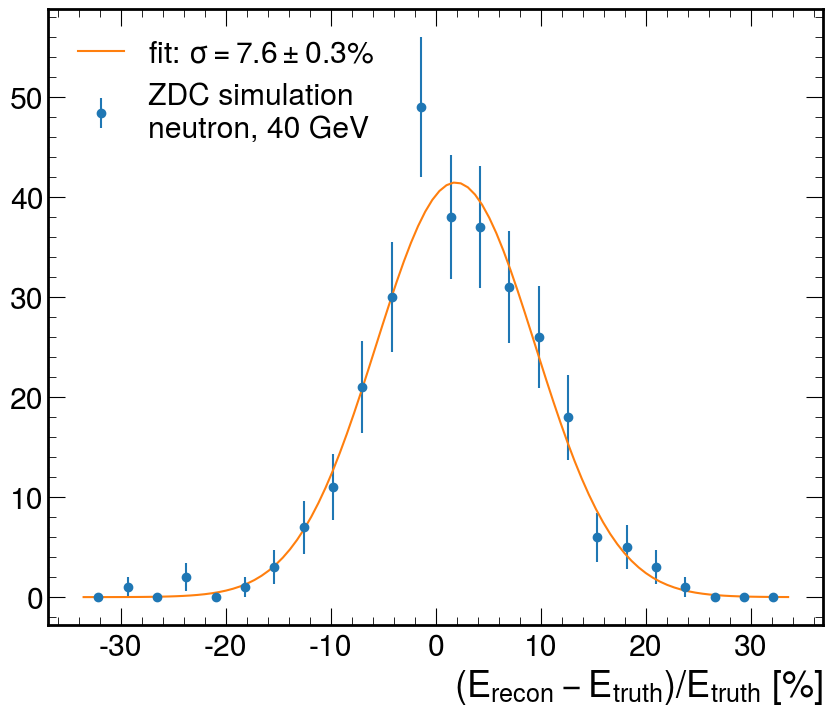

fit: $\sigma=11.8\pm0.7$ mm


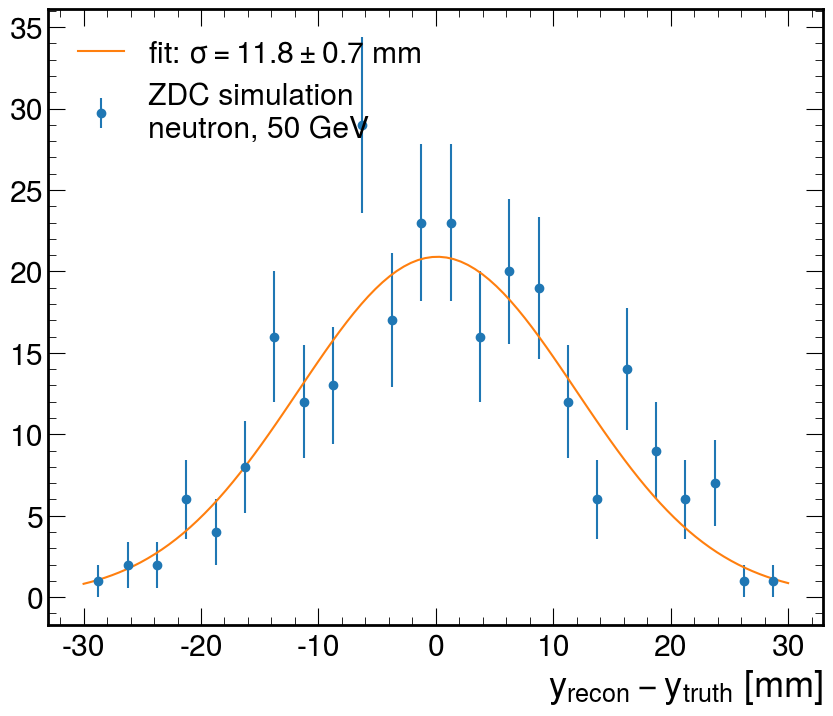

fit: $\sigma=7.1\pm0.3$%


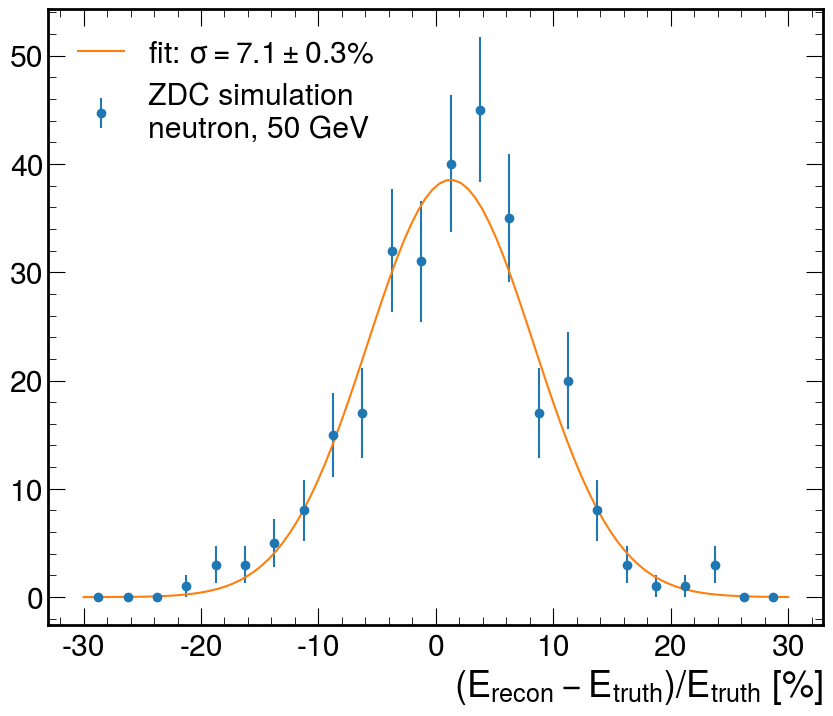

fit: $\sigma=12.1\pm1.0$ mm


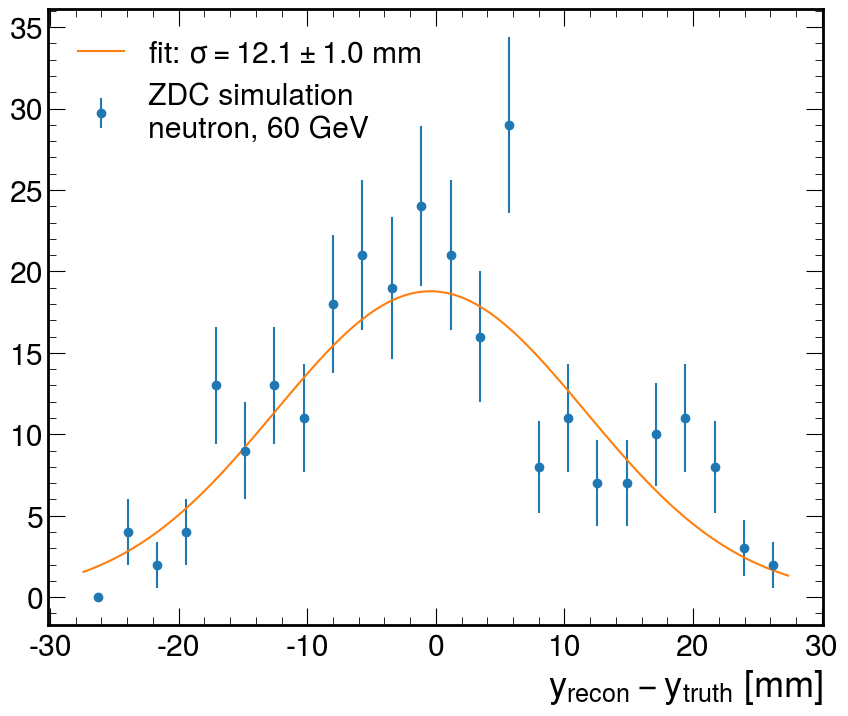

fit: $\sigma=6.8\pm0.3$%


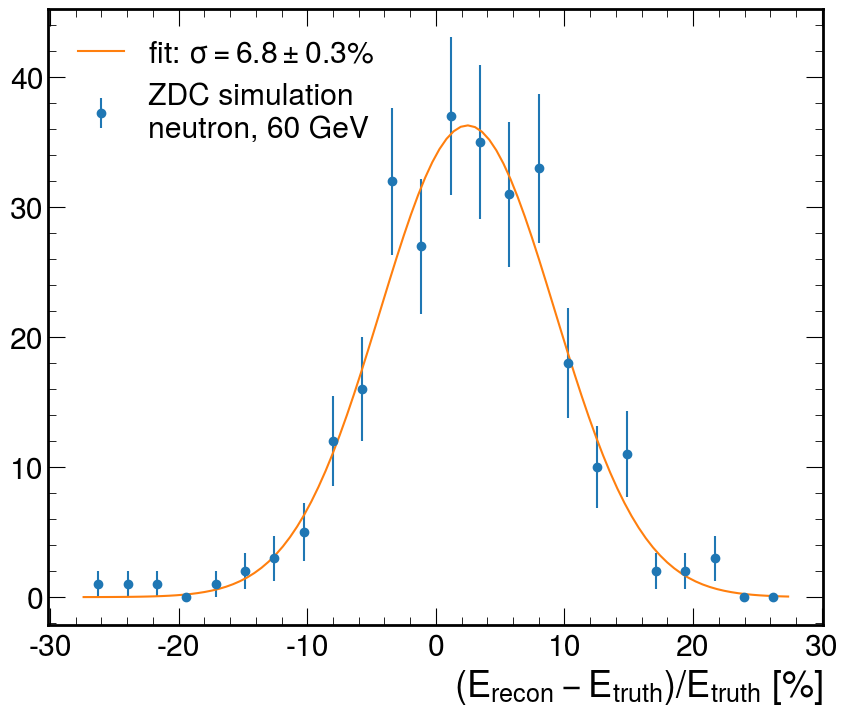

fit: $\sigma=12.6\pm1.2$ mm


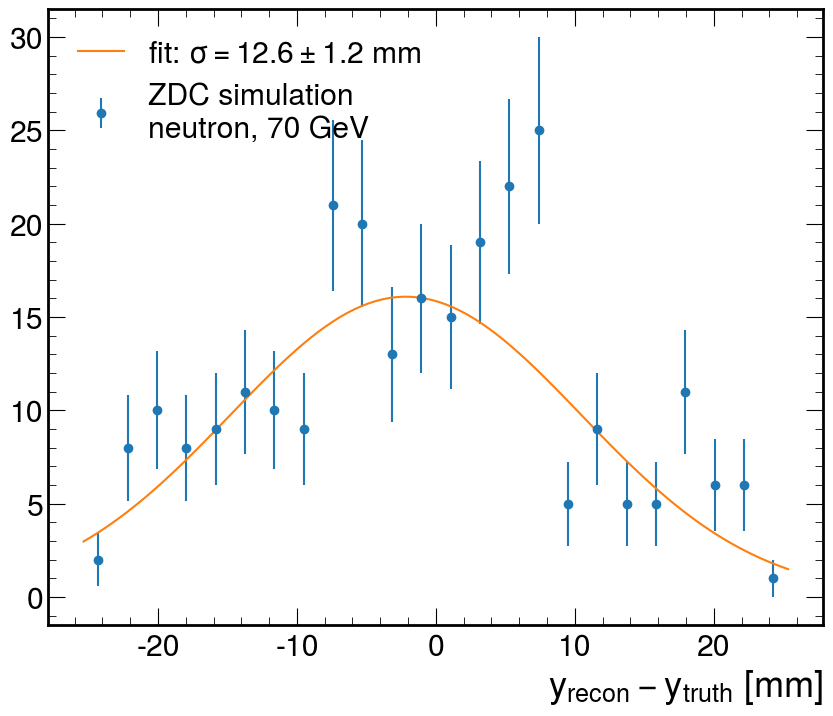

fit: $\sigma=5.8\pm0.2$%


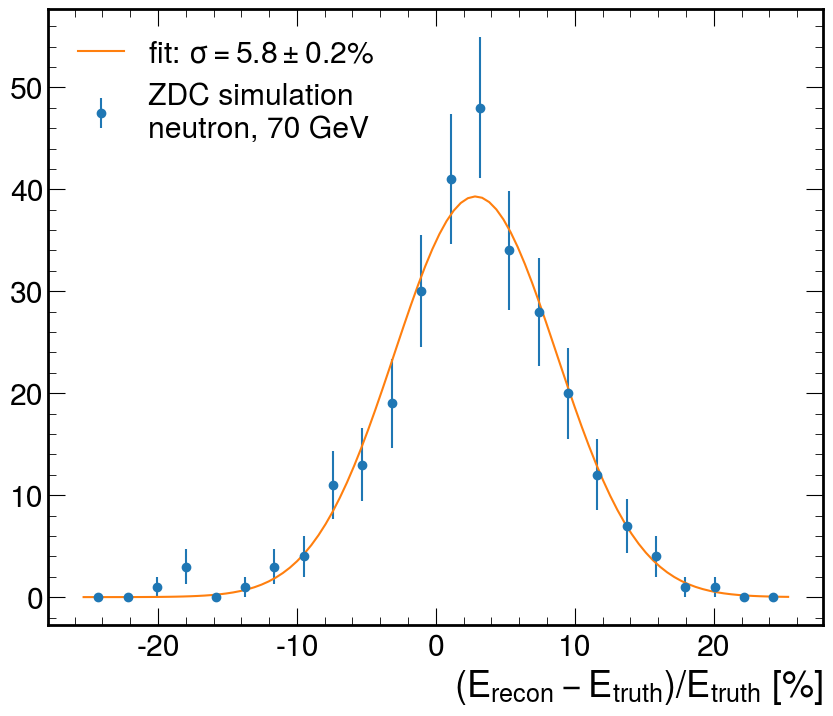

fit: $\sigma=11.3\pm1.0$ mm


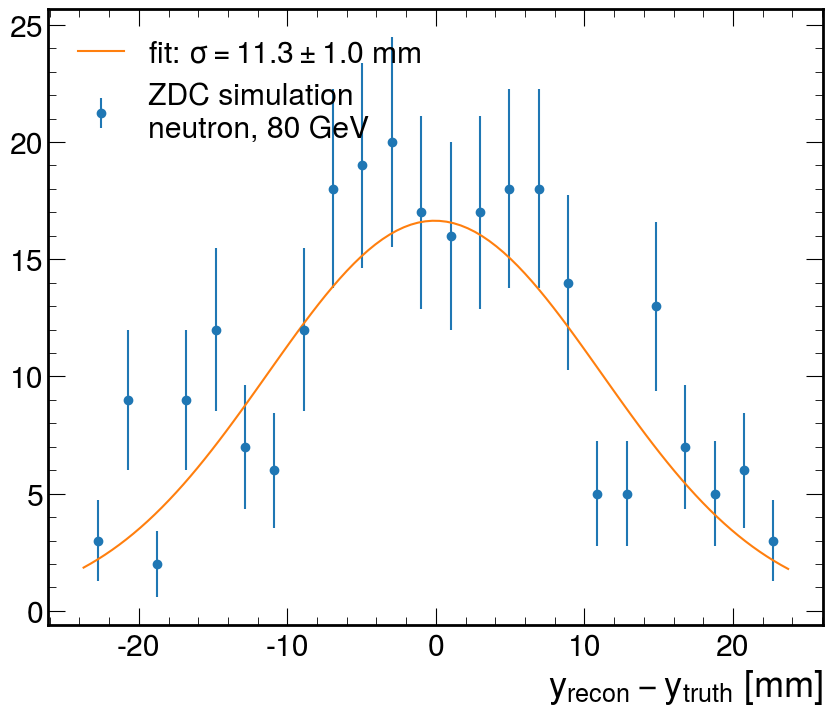

fit: $\sigma=5.1\pm0.3$%


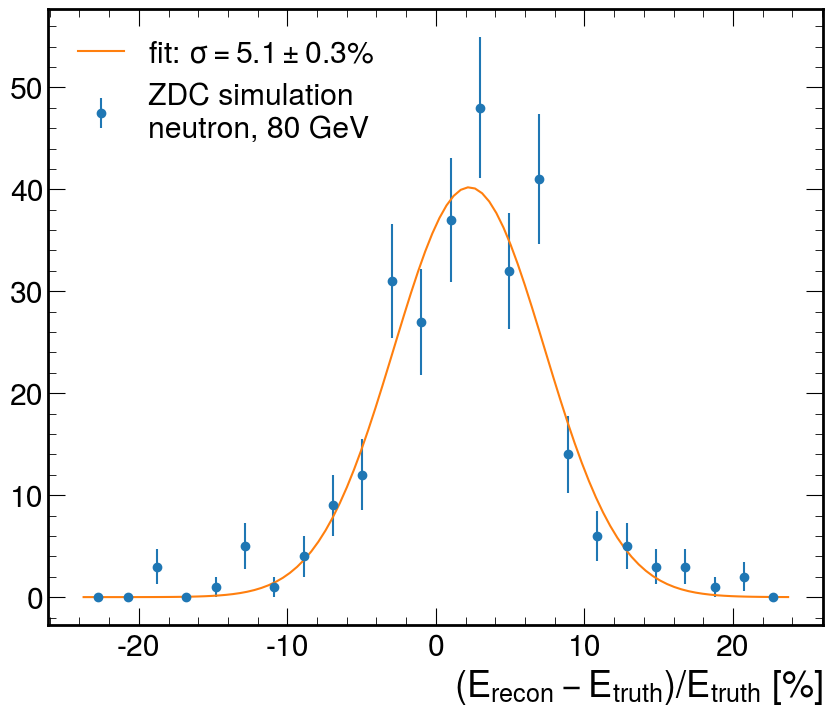

fit: $\sigma=13.6\pm1.6$ mm


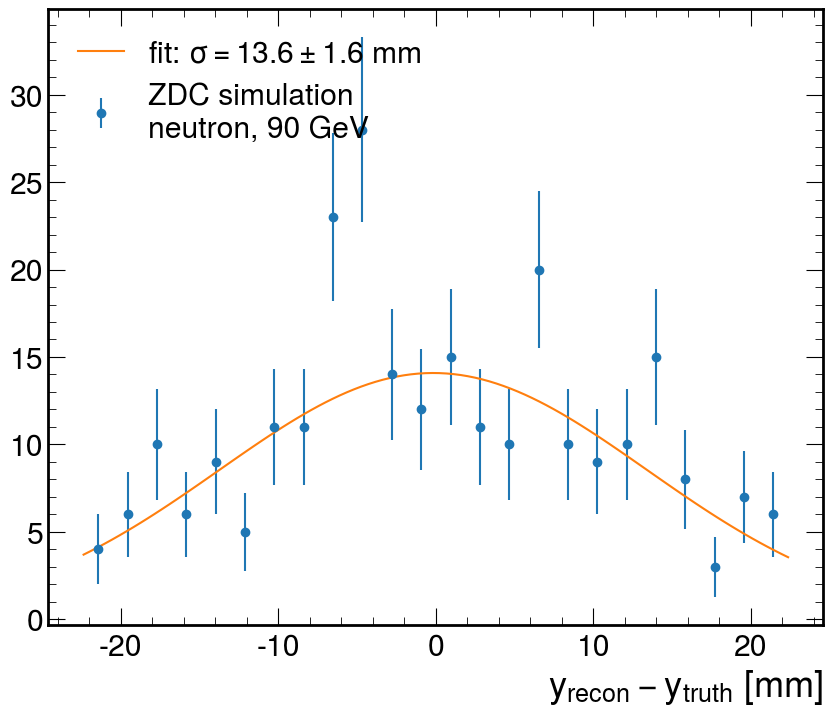

fit: $\sigma=6.0\pm0.2$%


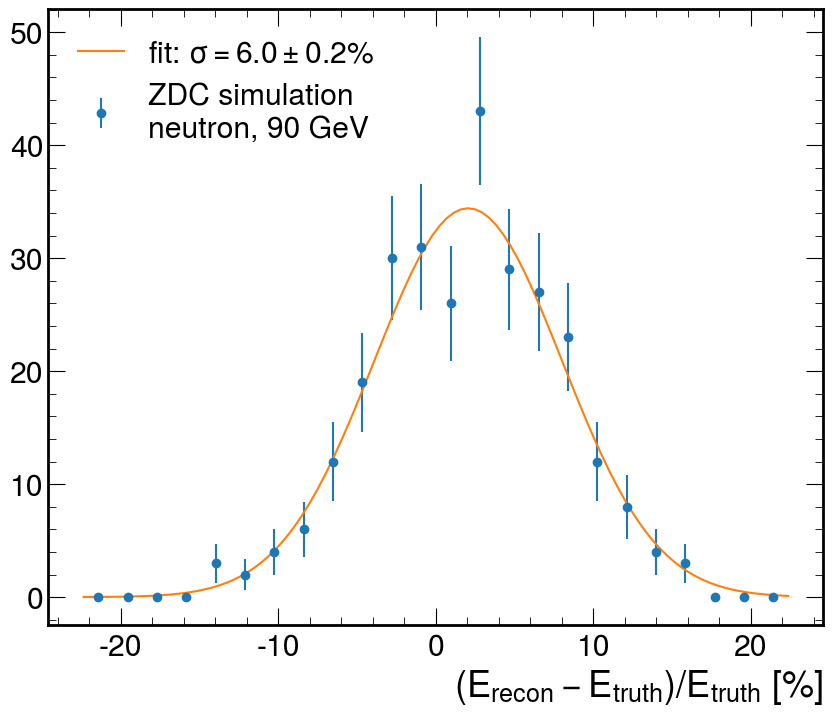

fit: $\sigma=11.5\pm1.2$ mm


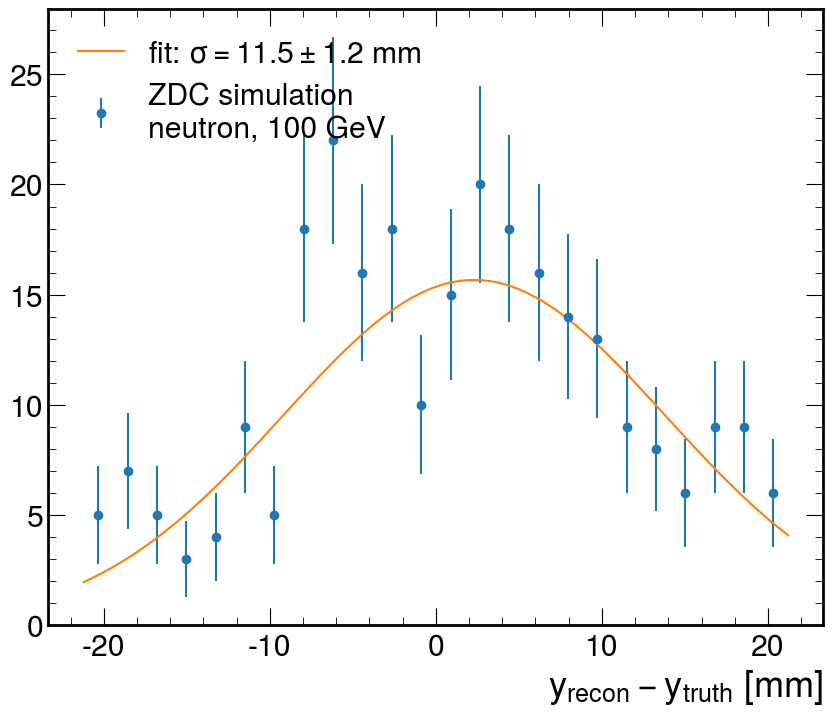

fit: $\sigma=5.5\pm0.3$%


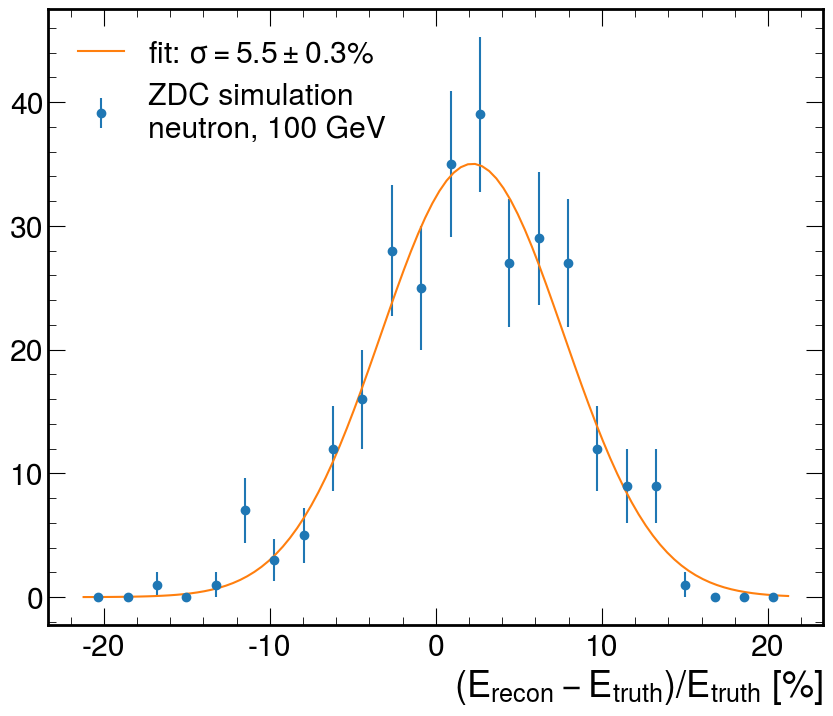

In [21]:
Ebeams=(1,2, 5, 10, 20, 30,40,50, 60, 70, 80, 90, 100)
r_res_vals_h1=[]
r_res_errs_h1=[]
E_res_vals_h1=[]
E_res_errs_h1=[]
for Ebeam in Ebeams:
    df = pd.read_csv(f'cache/unstaggered_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb, curve= res_plot(df.dy, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.xlabel("$y_{\\rm recon}-y_{\\rm truth}$ [mm]")
    plt.show()
    r_res_vals_h1.append(res)
    r_res_errs_h1.append(dres)
    
    res,dres, eb, curve= res_plot(100*(np.array(df.E)/np.mean(df.E)-1), bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), 
                                  label=f"ZDC simulation\nneutron, {Ebeam} GeV", unit="%")
    plt.xlabel("$(E_{\\rm recon}-E_{\\rm truth})/E_{\\rm truth}$ [%]")
    E_res_vals_h1.append(res)
    E_res_errs_h1.append(dres)
    plt.show()


fit: $\sigma=52.5\pm2.6$ mm


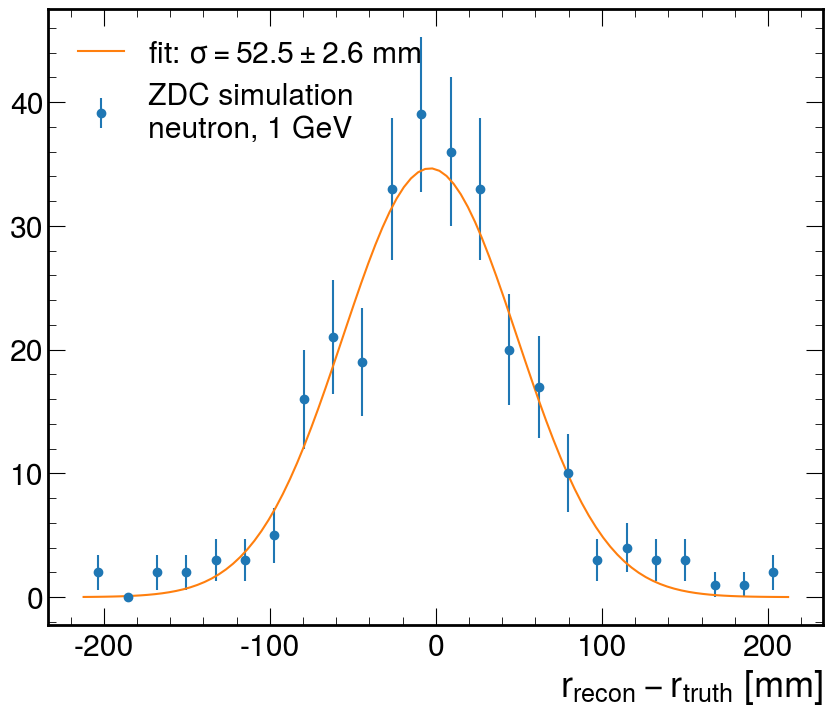

fit: $\sigma=48.3\pm3.1$ mm


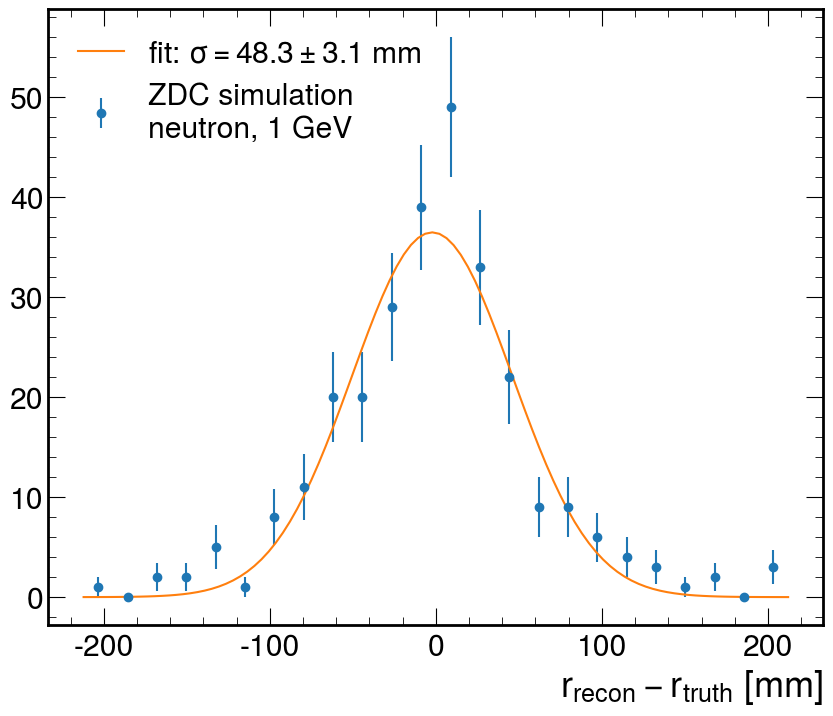

fit: $\sigma=58.8\pm6.3$%


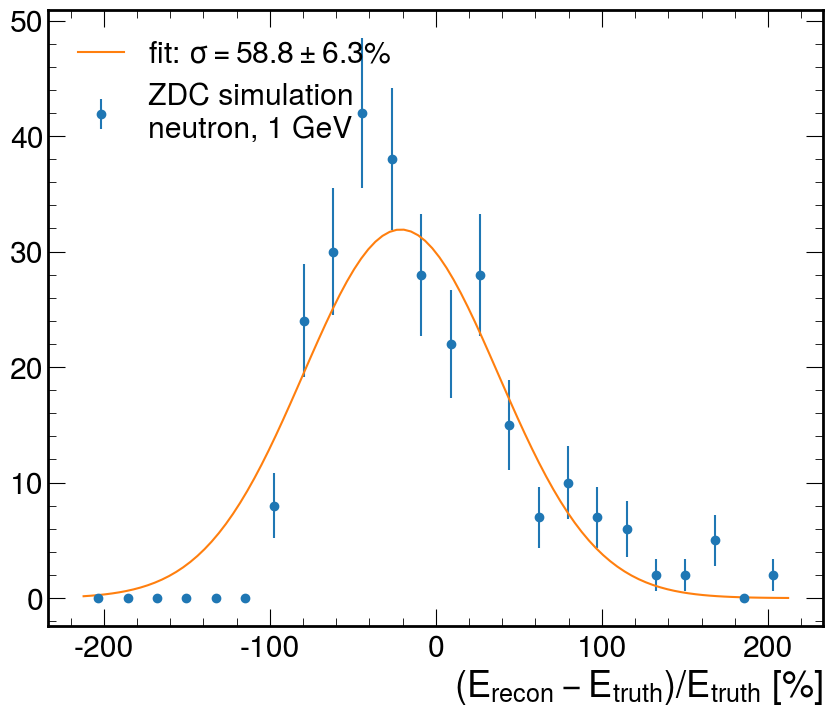

fit: $\sigma=38.8\pm3.1$ mm


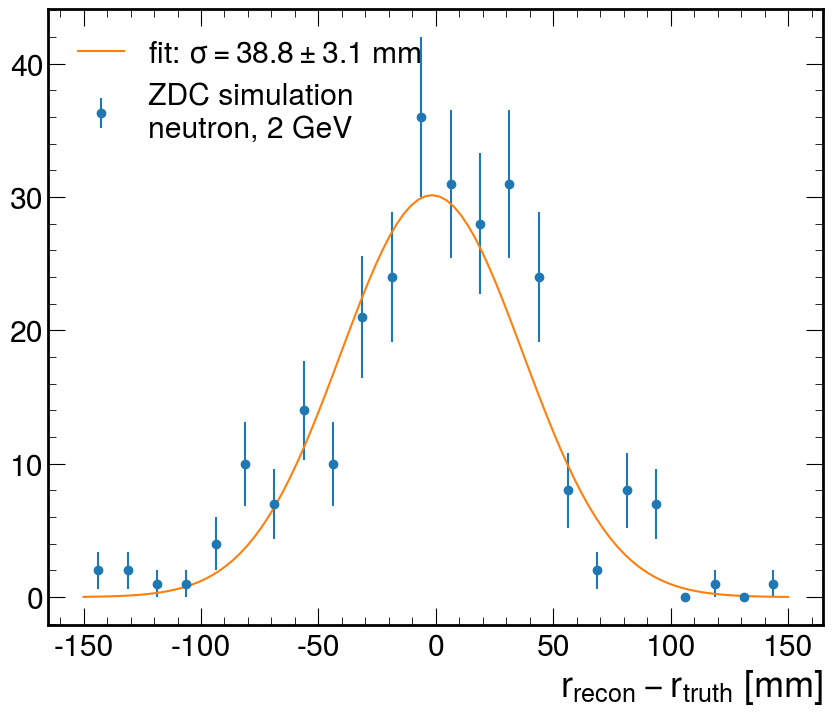

fit: $\sigma=40.2\pm2.3$ mm


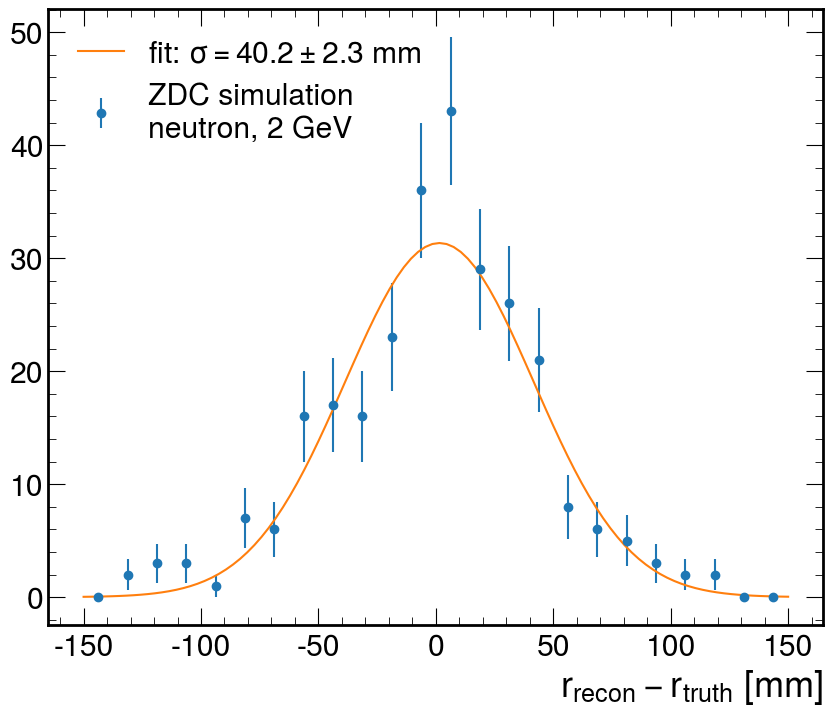

fit: $\sigma=34.2\pm1.9$%


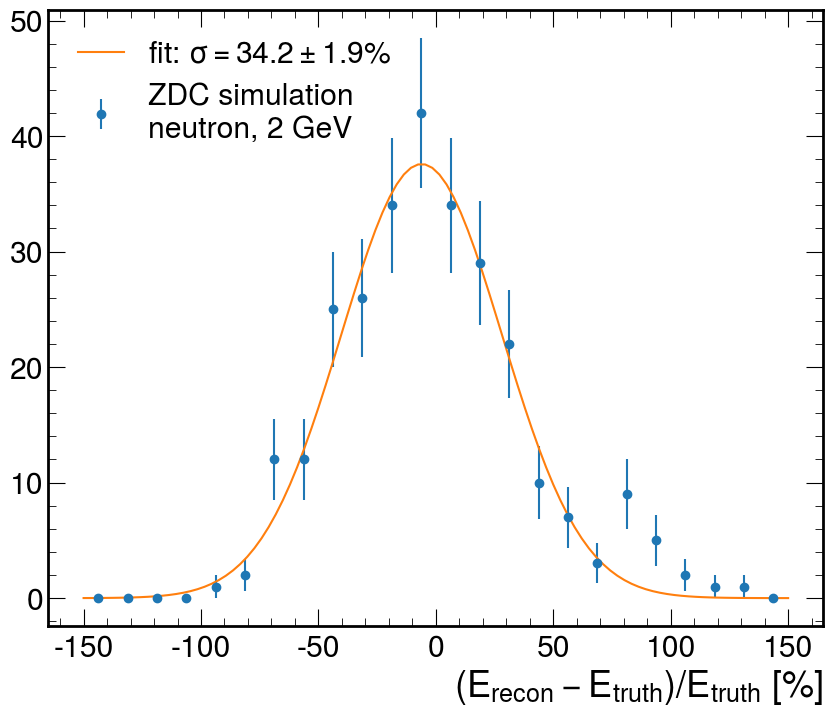

fit: $\sigma=24.9\pm1.9$ mm


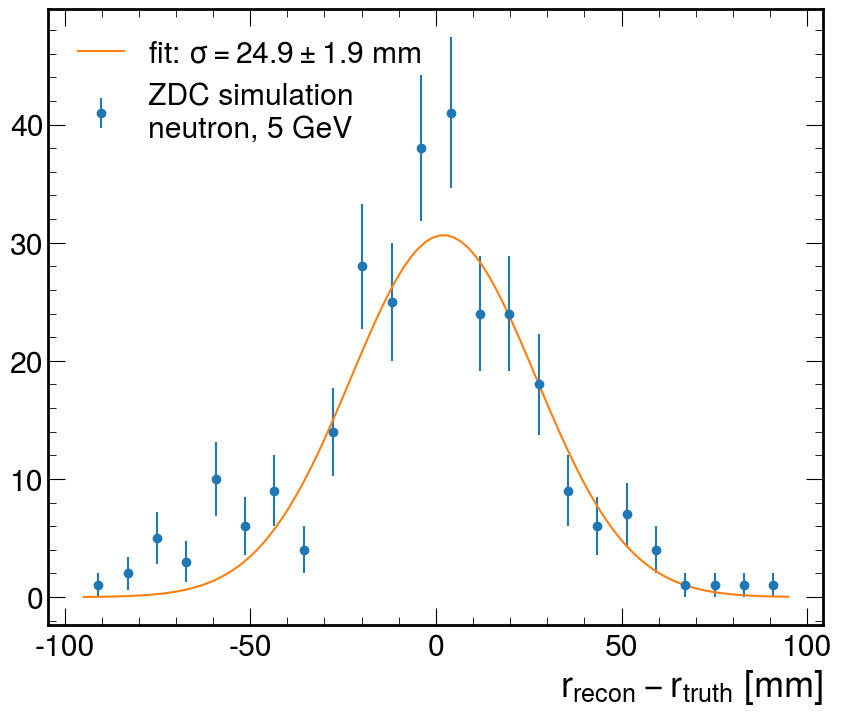

fit: $\sigma=27.4\pm1.8$ mm


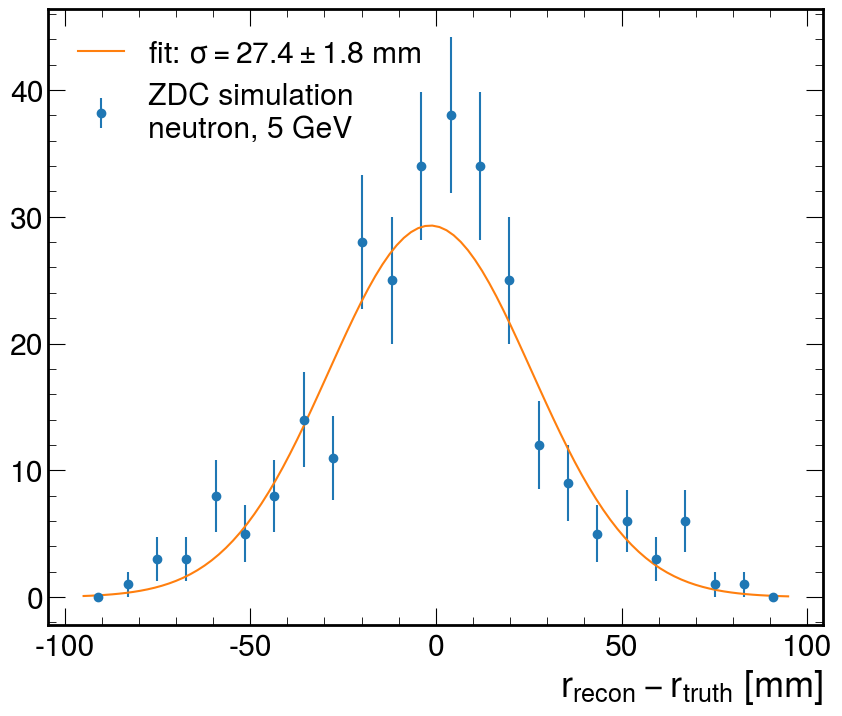

fit: $\sigma=24.9\pm1.1$%


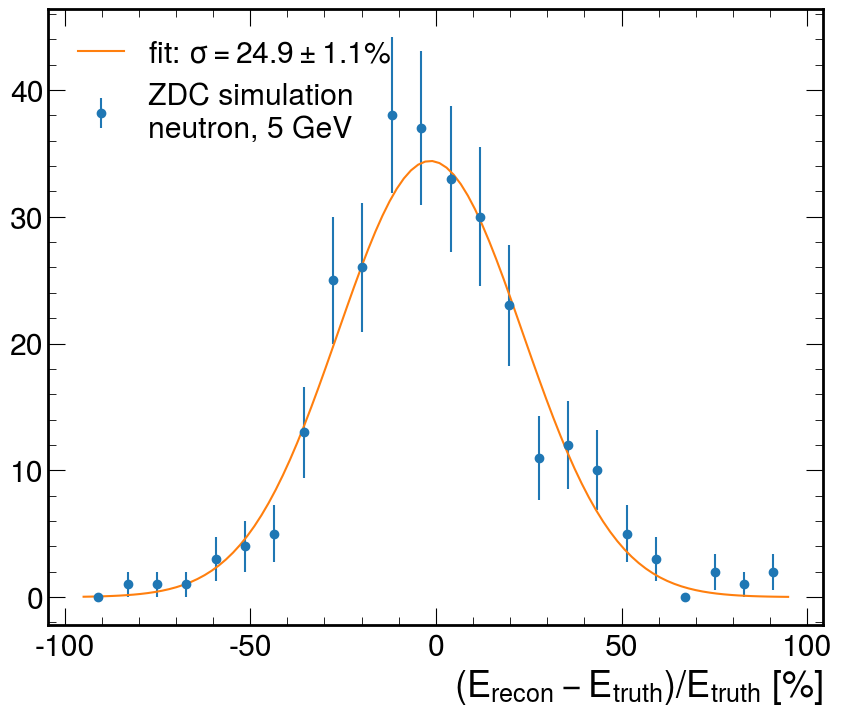

fit: $\sigma=18.4\pm1.2$ mm


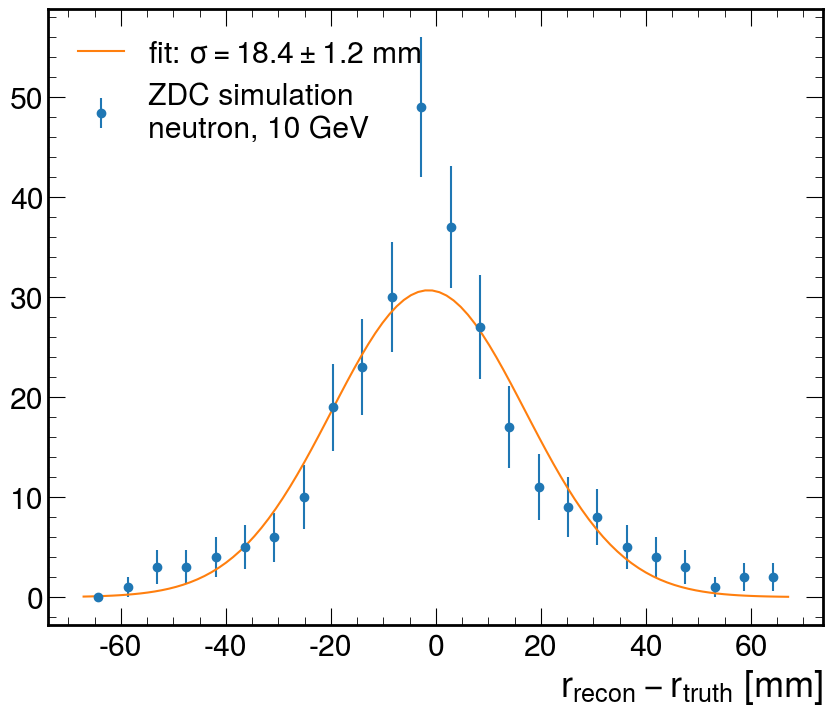

fit: $\sigma=19.5\pm1.2$ mm


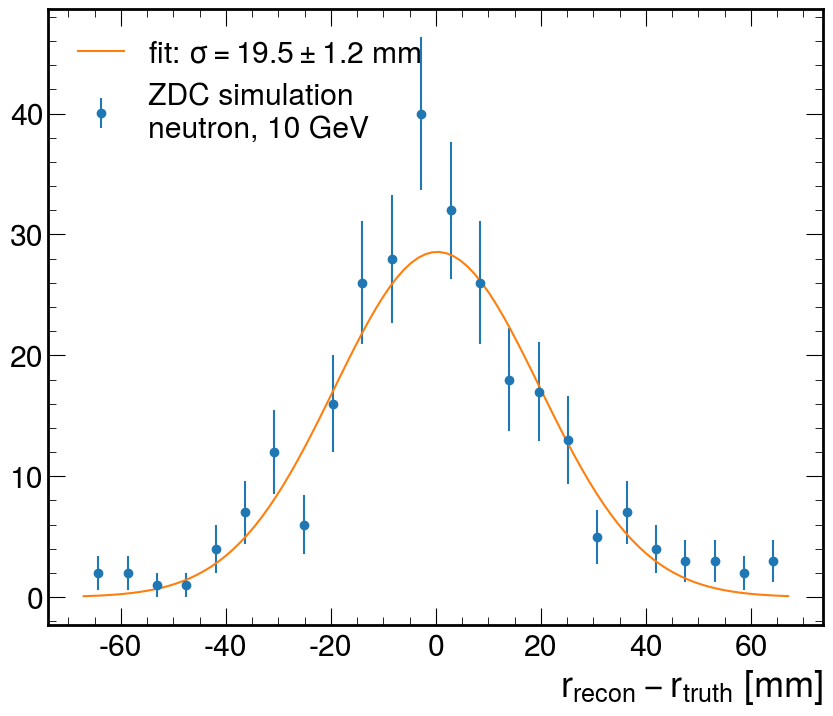

fit: $\sigma=16.9\pm0.7$%


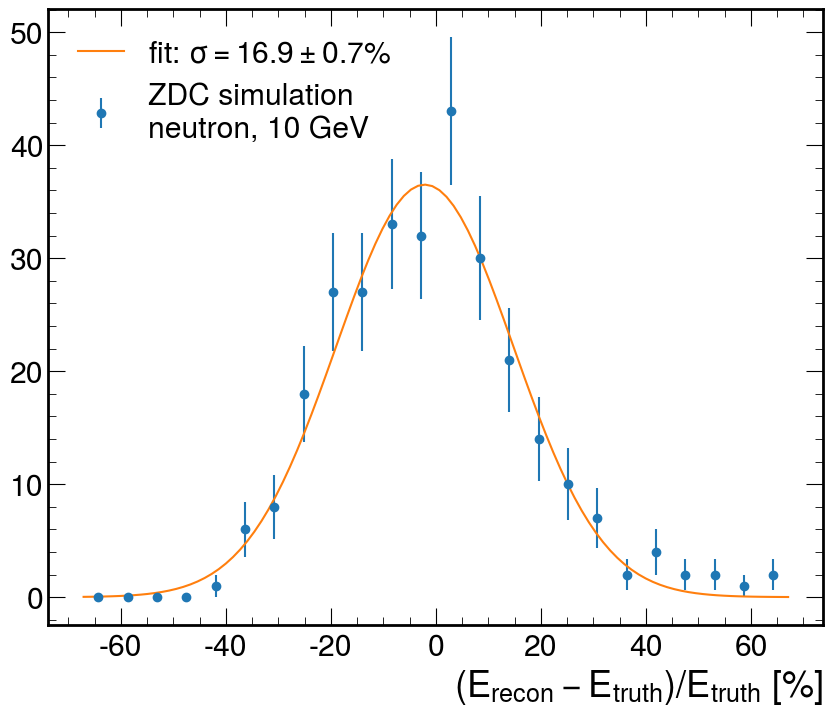

fit: $\sigma=10.0\pm0.6$ mm


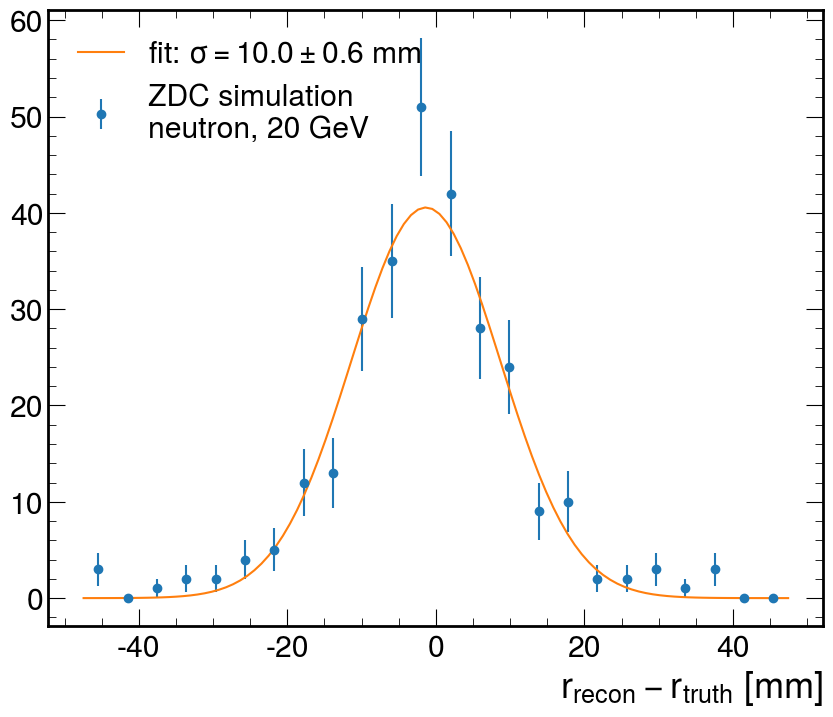

fit: $\sigma=10.6\pm0.8$ mm


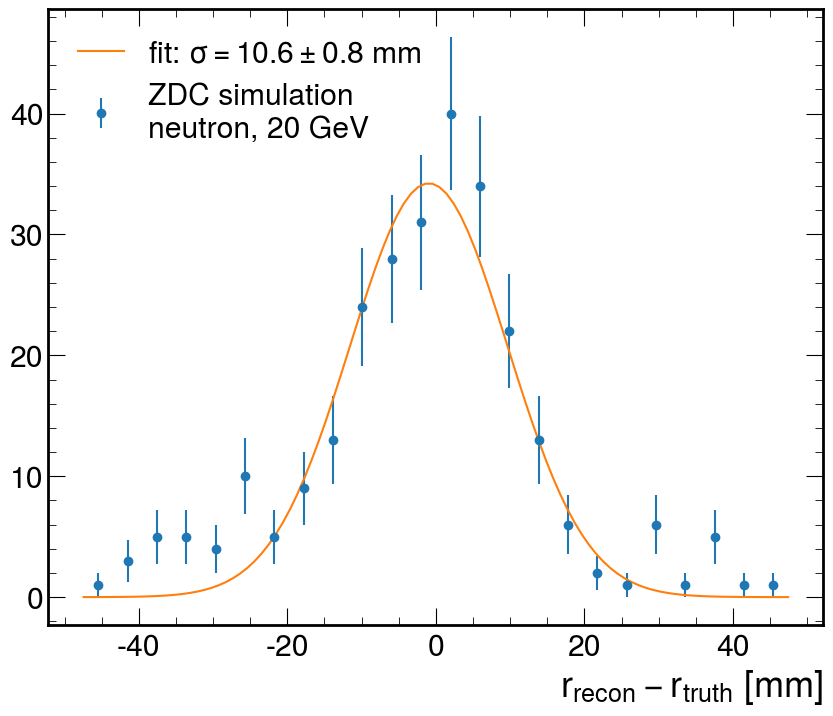

fit: $\sigma=10.0\pm0.4$%


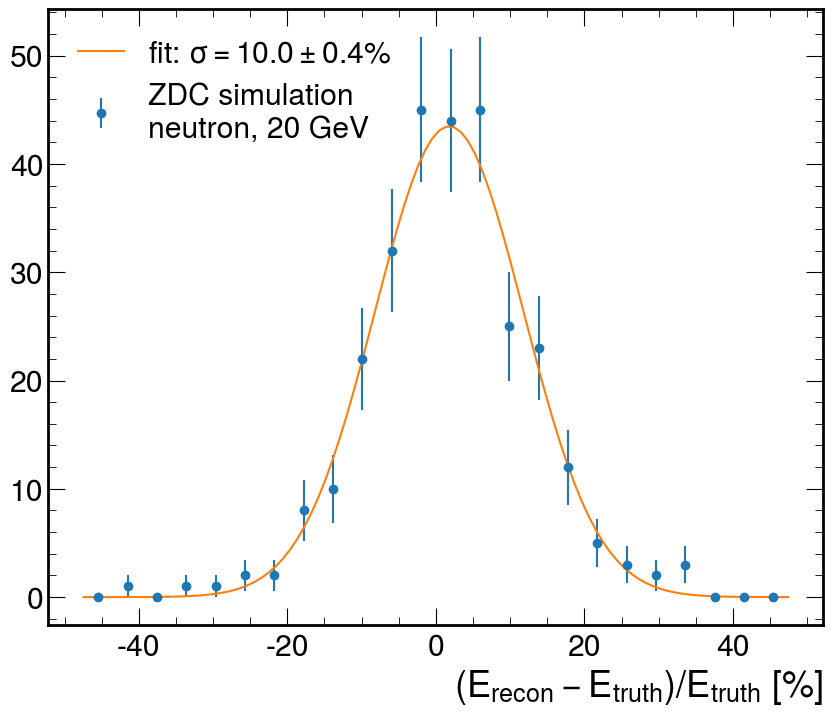

fit: $\sigma=7.9\pm0.4$ mm


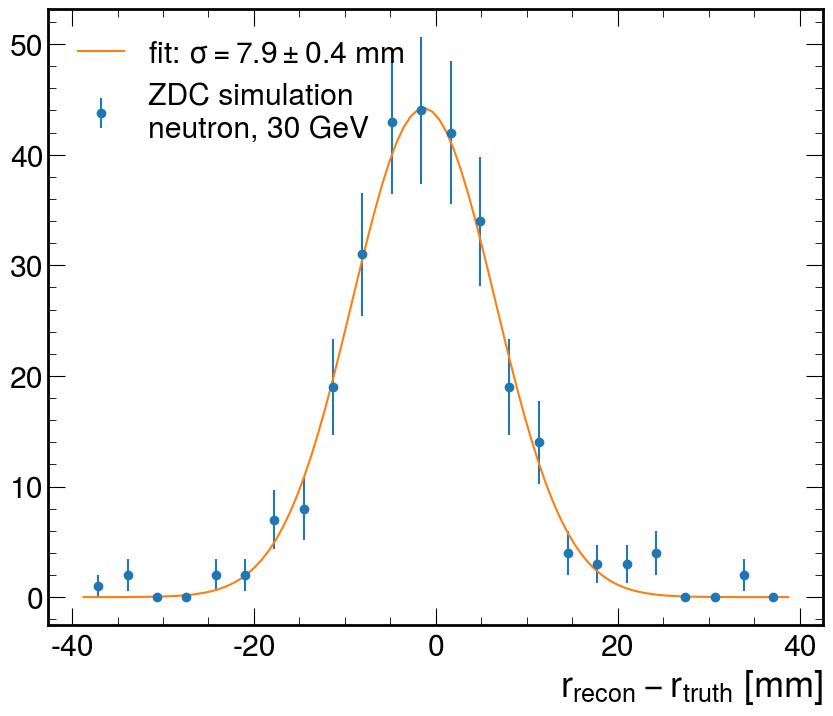

fit: $\sigma=7.7\pm0.6$ mm


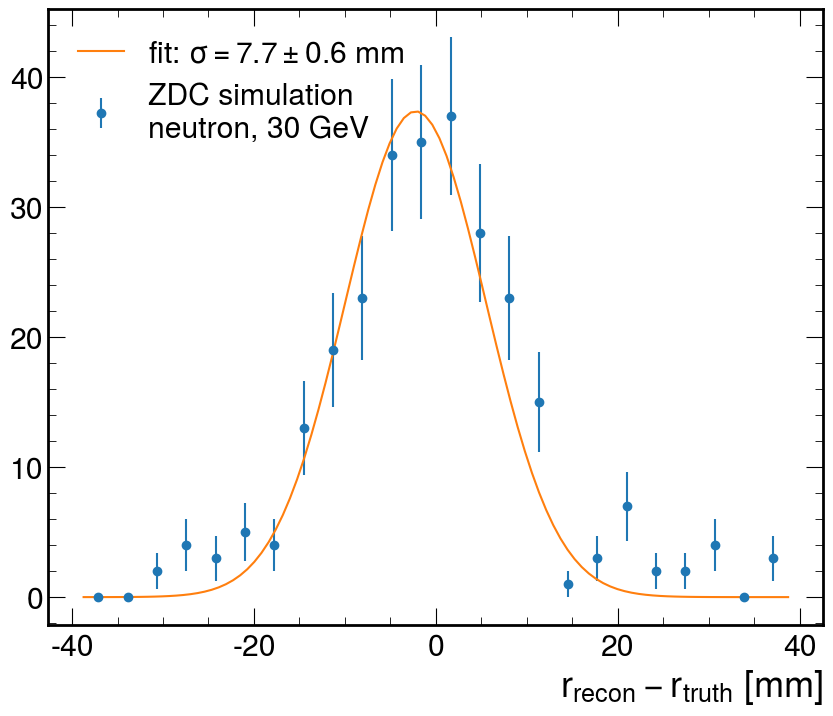

fit: $\sigma=8.5\pm0.3$%


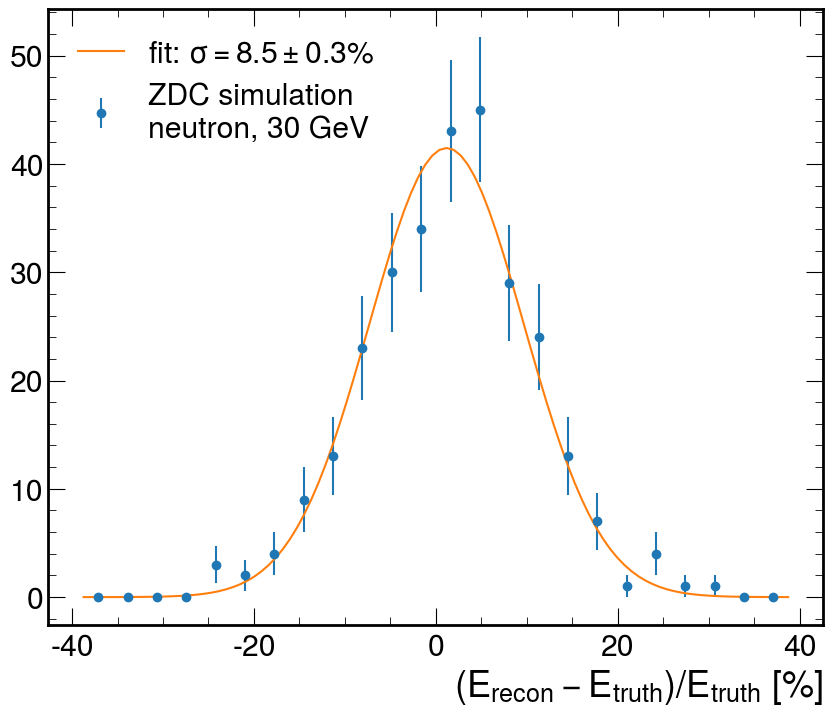

fit: $\sigma=5.9\pm0.3$ mm


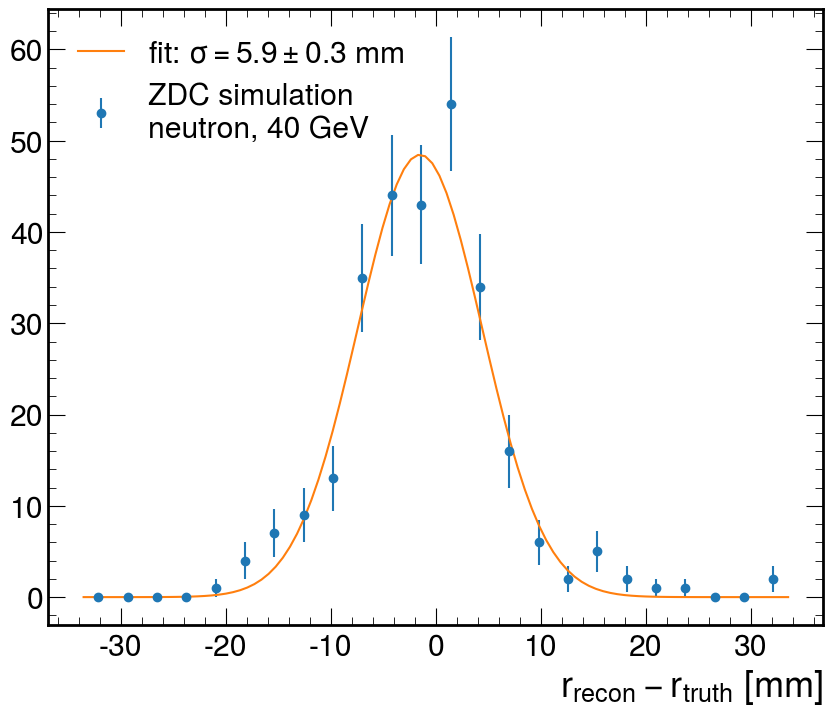

fit: $\sigma=7.1\pm0.5$ mm


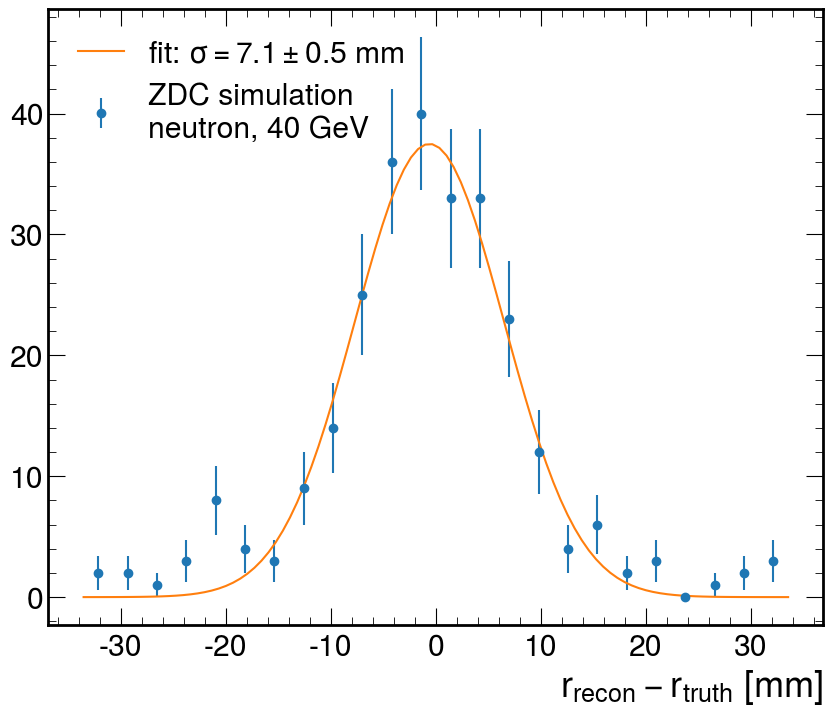

fit: $\sigma=7.5\pm0.3$%


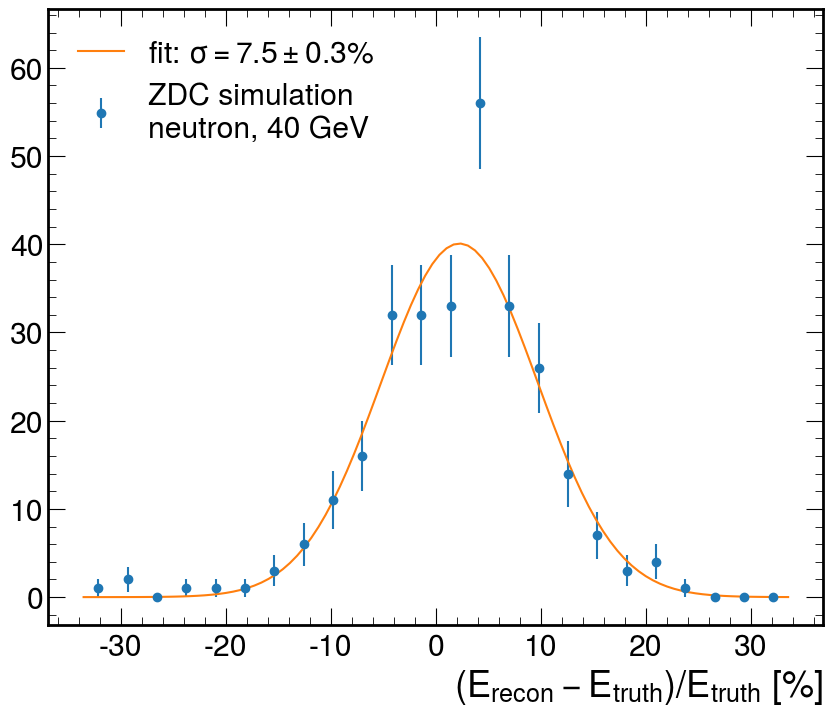

fit: $\sigma=5.5\pm0.4$ mm


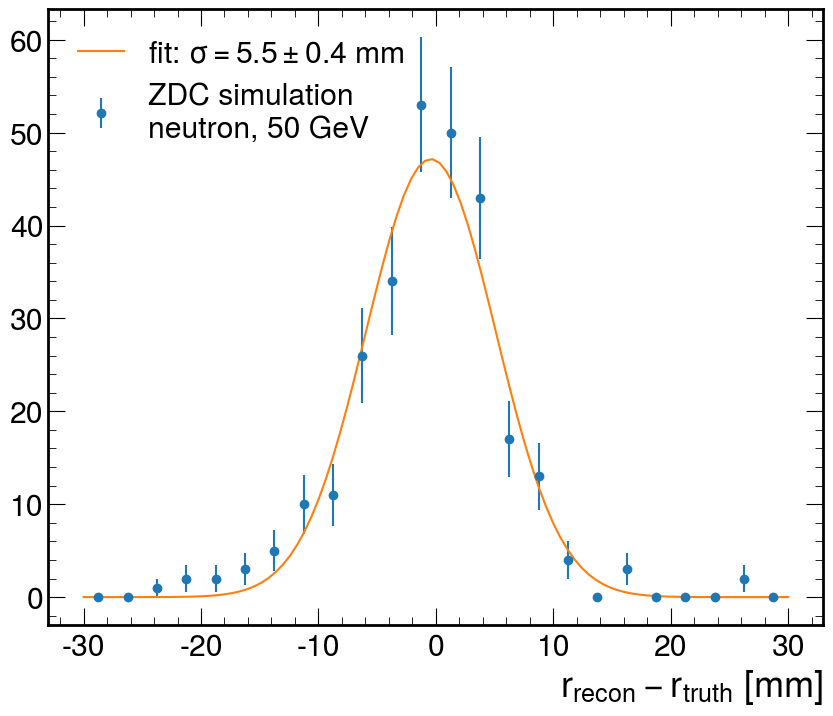

fit: $\sigma=6.9\pm0.5$ mm


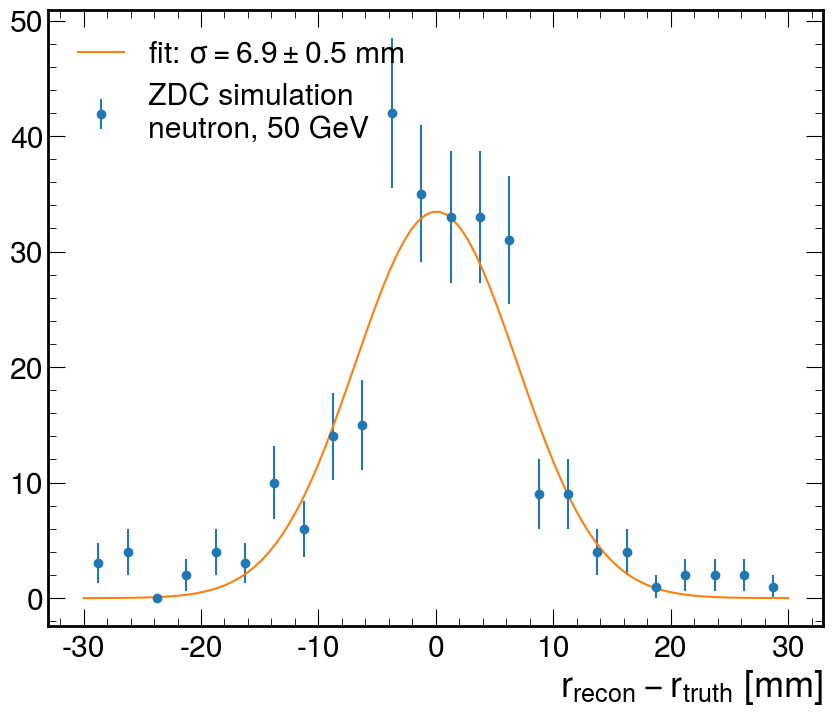

fit: $\sigma=7.5\pm0.4$%


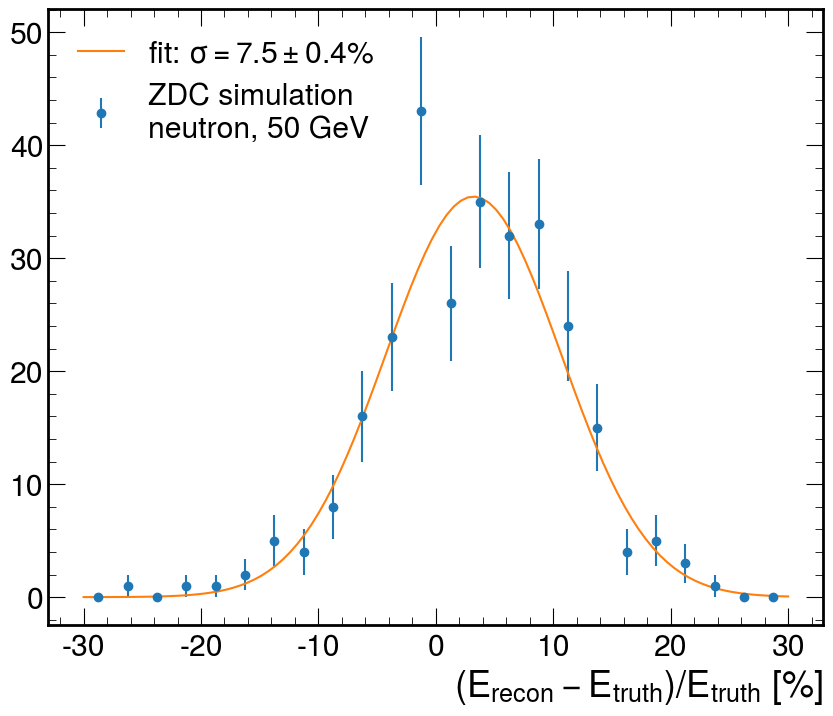

fit: $\sigma=4.8\pm0.3$ mm


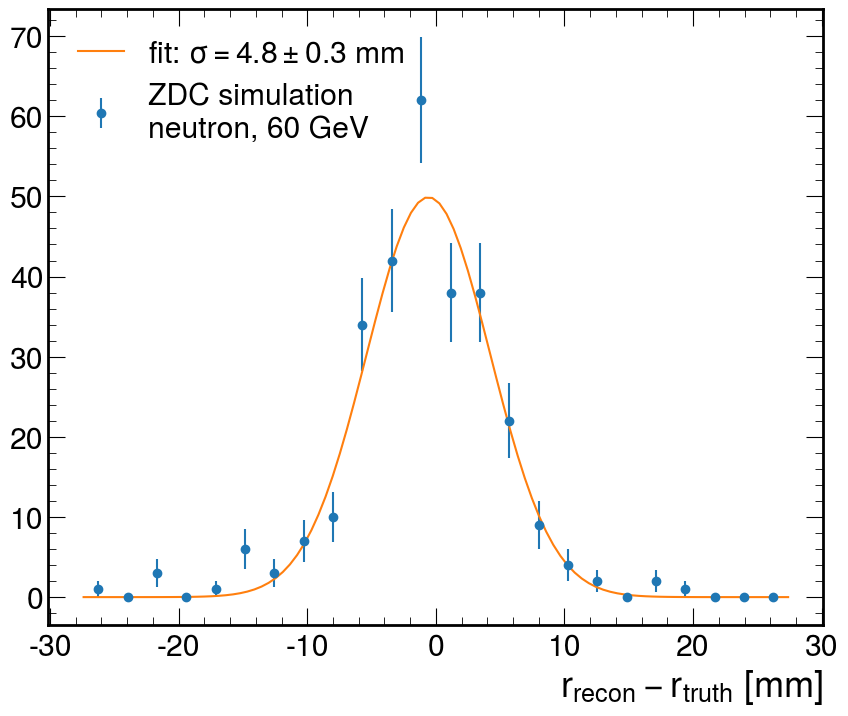

fit: $\sigma=6.5\pm0.4$ mm


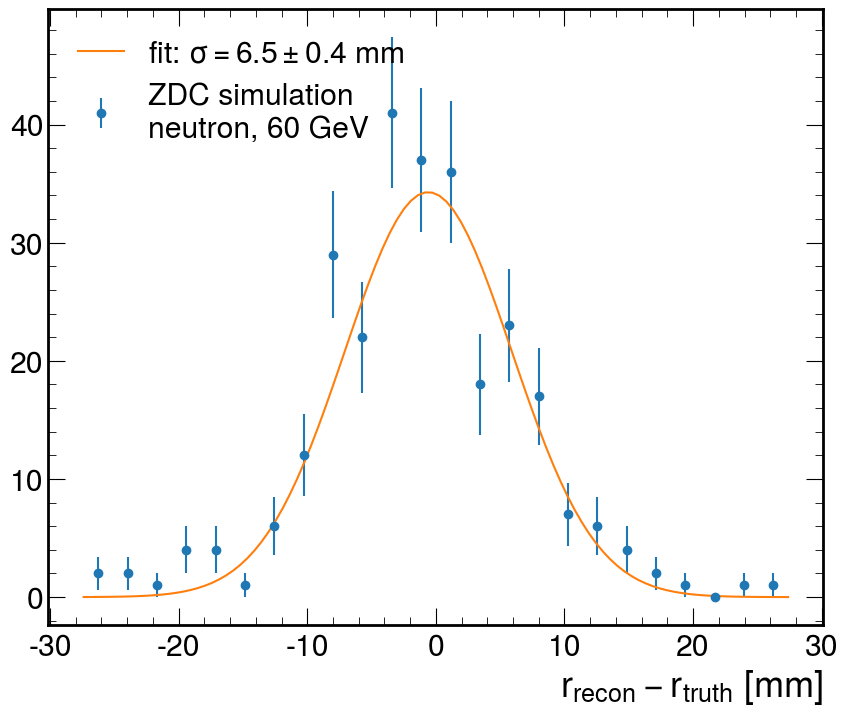

fit: $\sigma=7.0\pm0.3$%


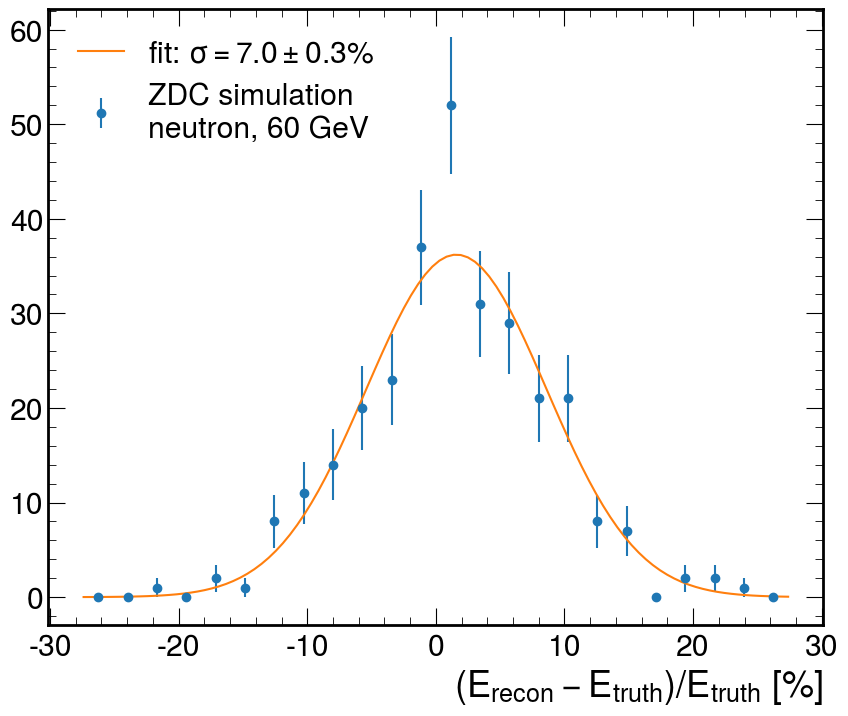

fit: $\sigma=4.6\pm0.3$ mm


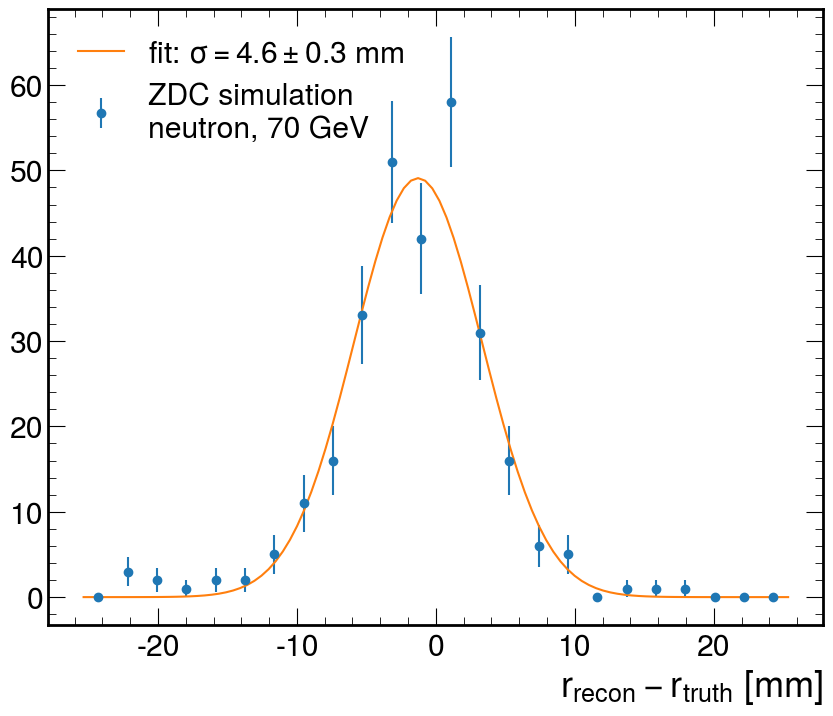

fit: $\sigma=5.9\pm0.4$ mm


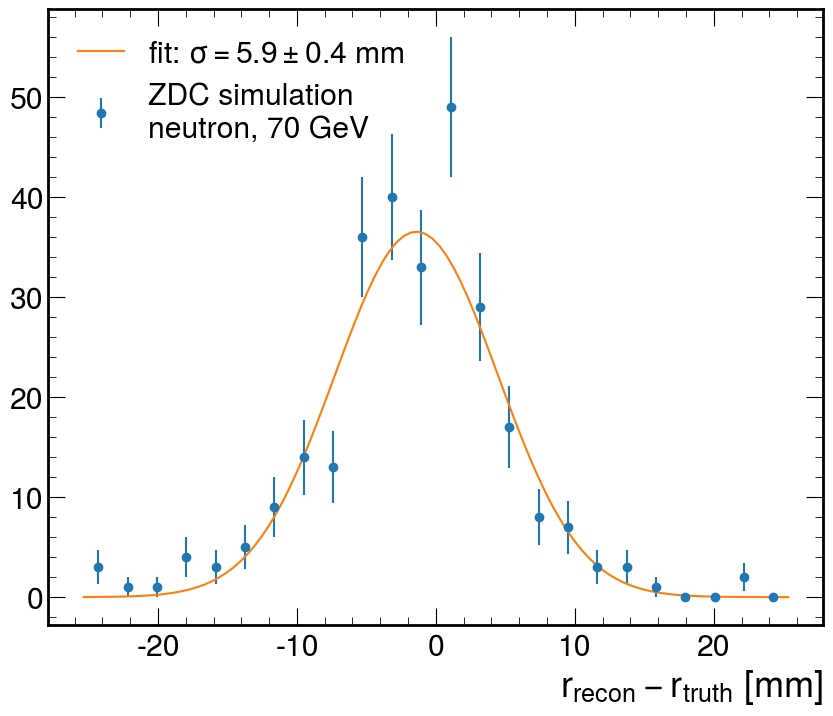

fit: $\sigma=5.5\pm0.3$%


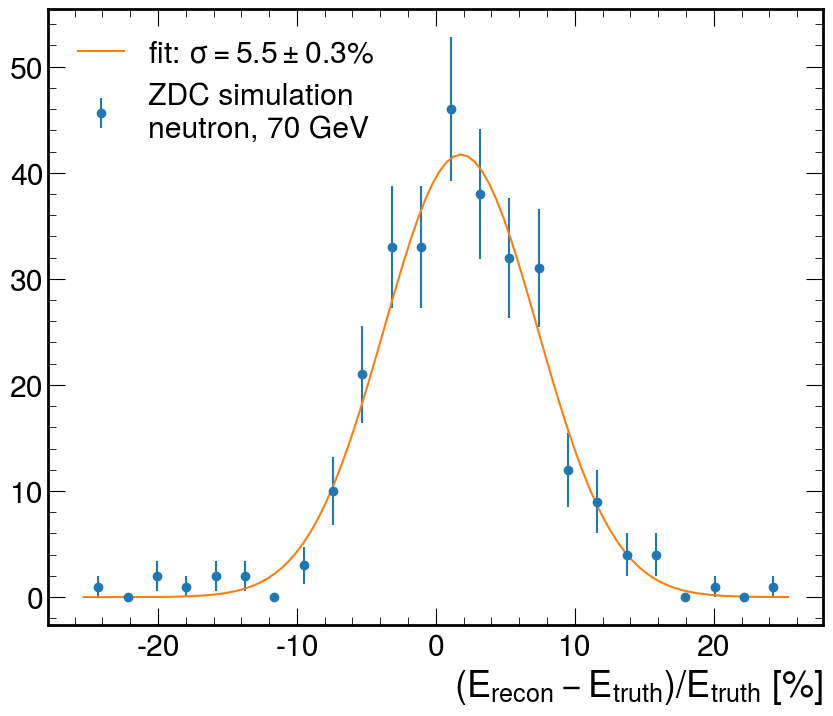

fit: $\sigma=4.6\pm0.1$ mm


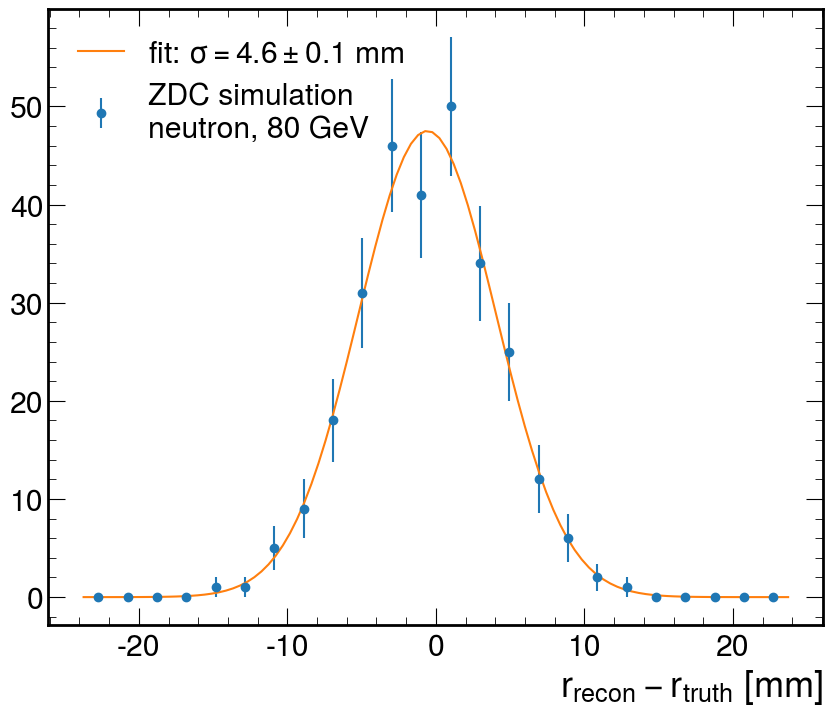

fit: $\sigma=5.7\pm0.3$ mm


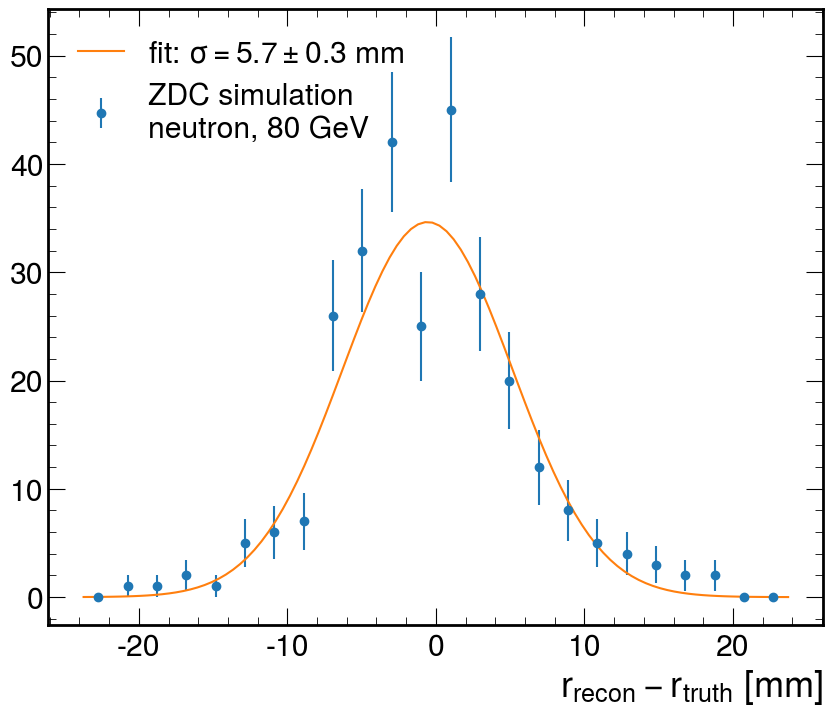

fit: $\sigma=5.2\pm0.2$%


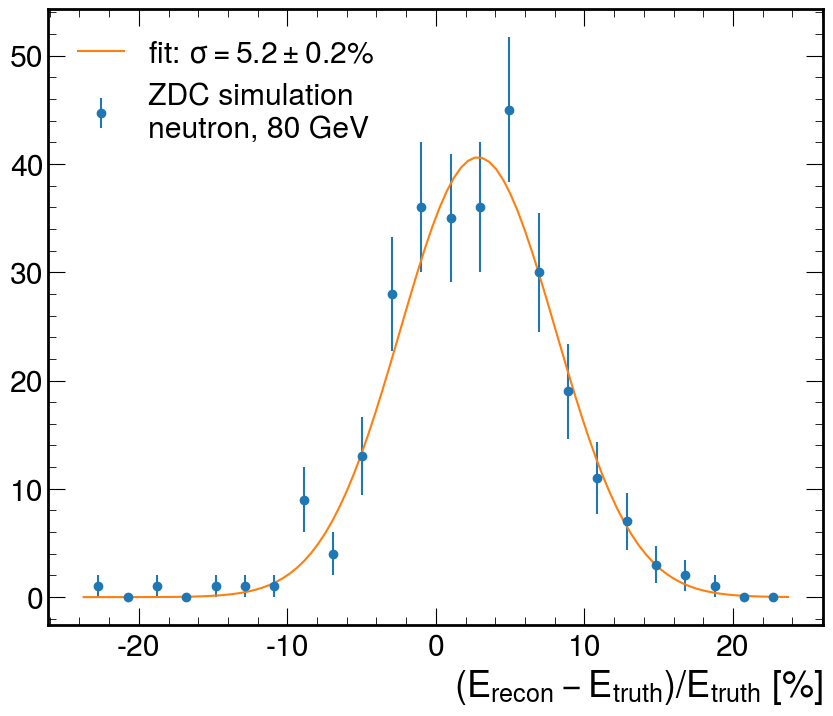

fit: $\sigma=4.3\pm0.2$ mm


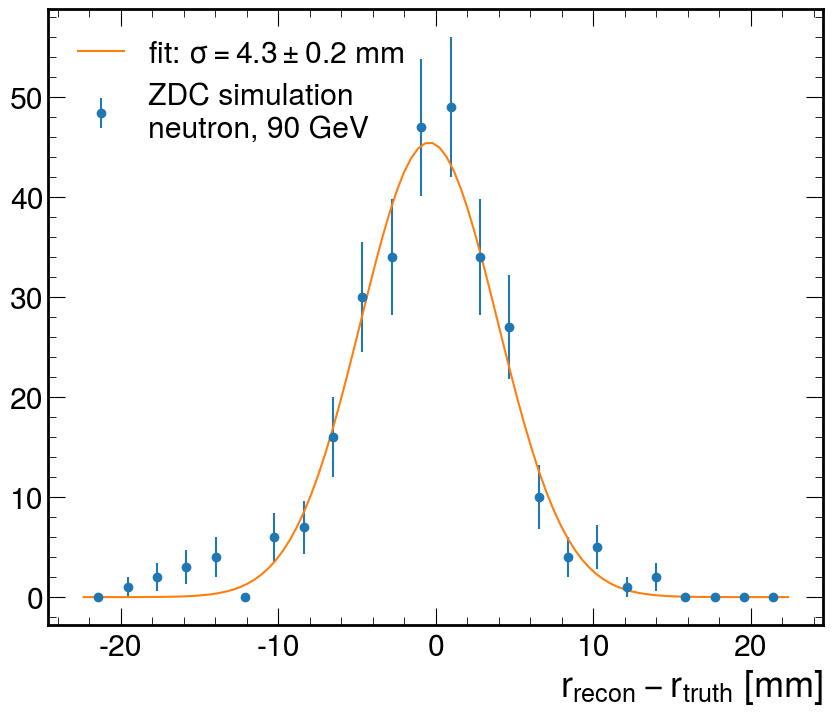

fit: $\sigma=5.5\pm0.2$ mm


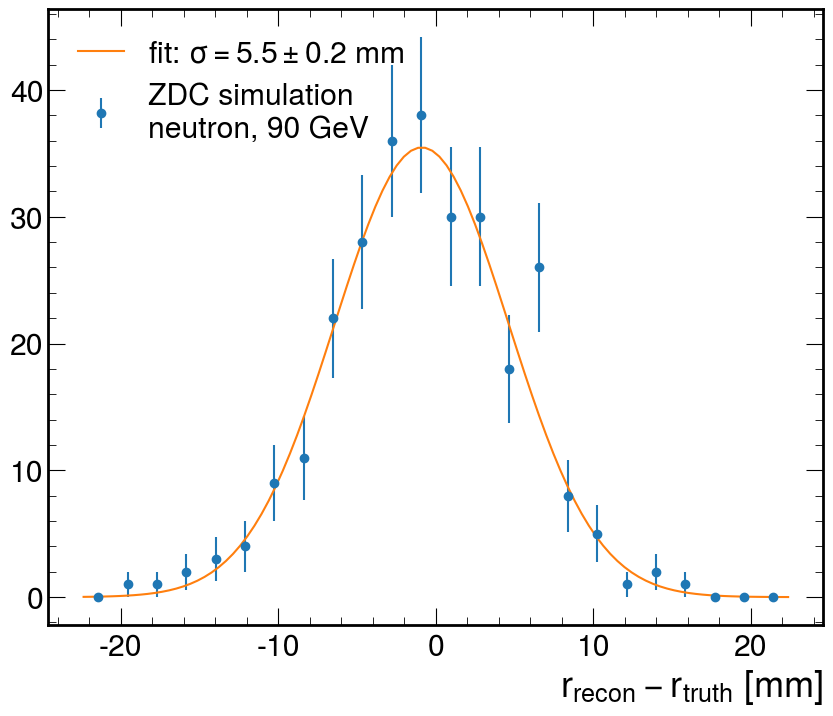

fit: $\sigma=5.9\pm0.3$%


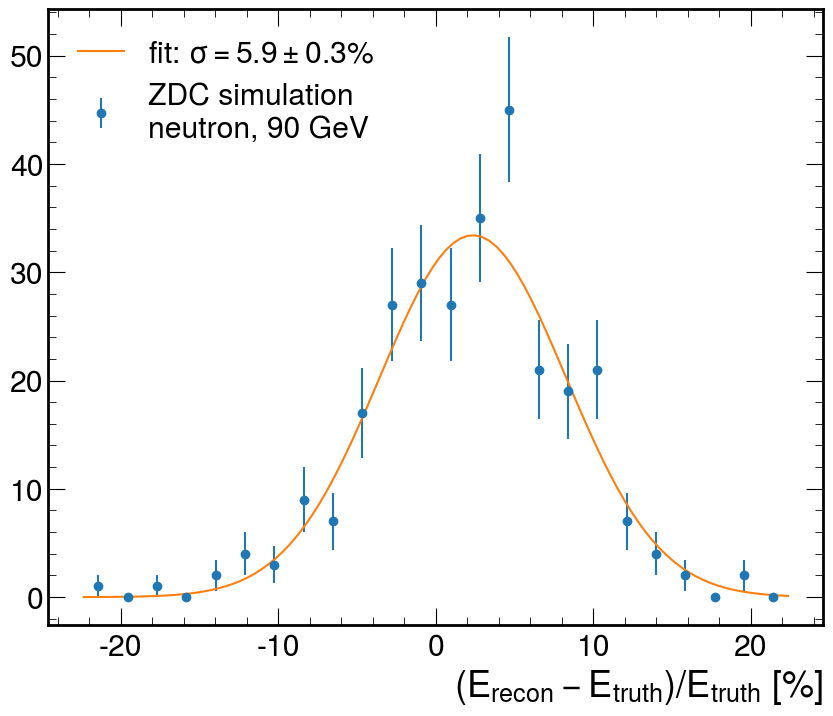

fit: $\sigma=4.4\pm0.2$ mm


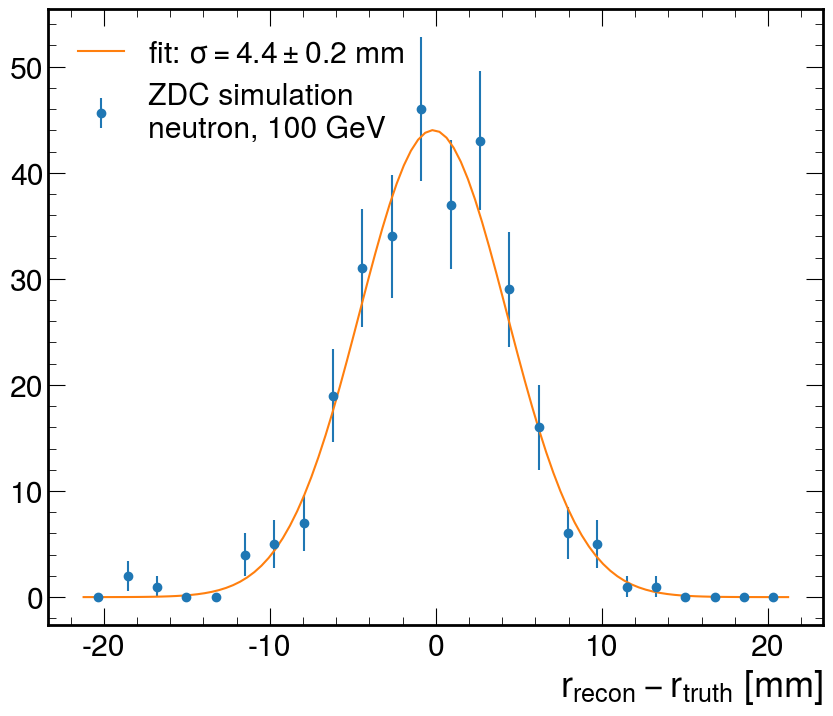

fit: $\sigma=4.9\pm0.2$ mm


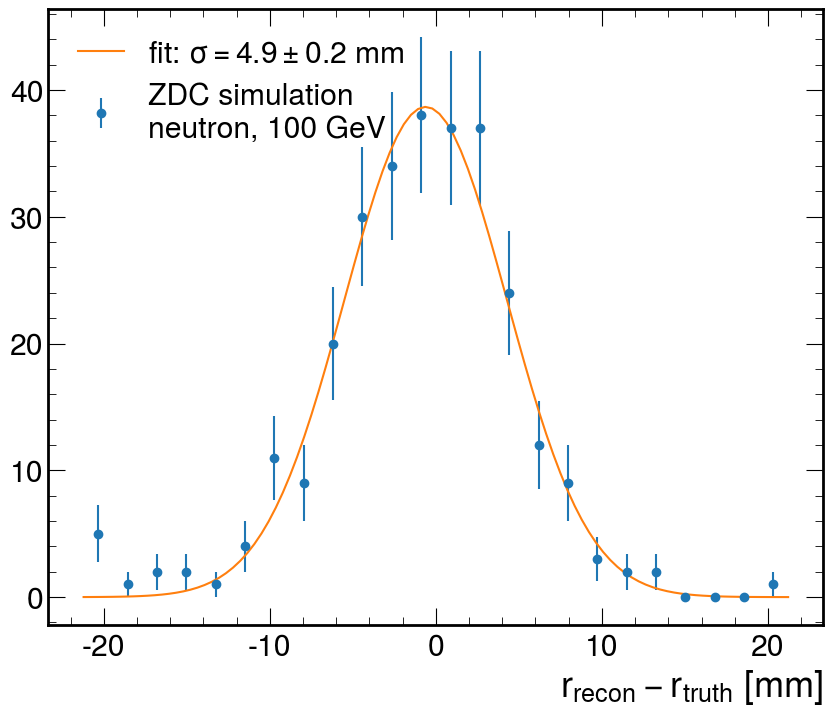

fit: $\sigma=5.3\pm0.3$%


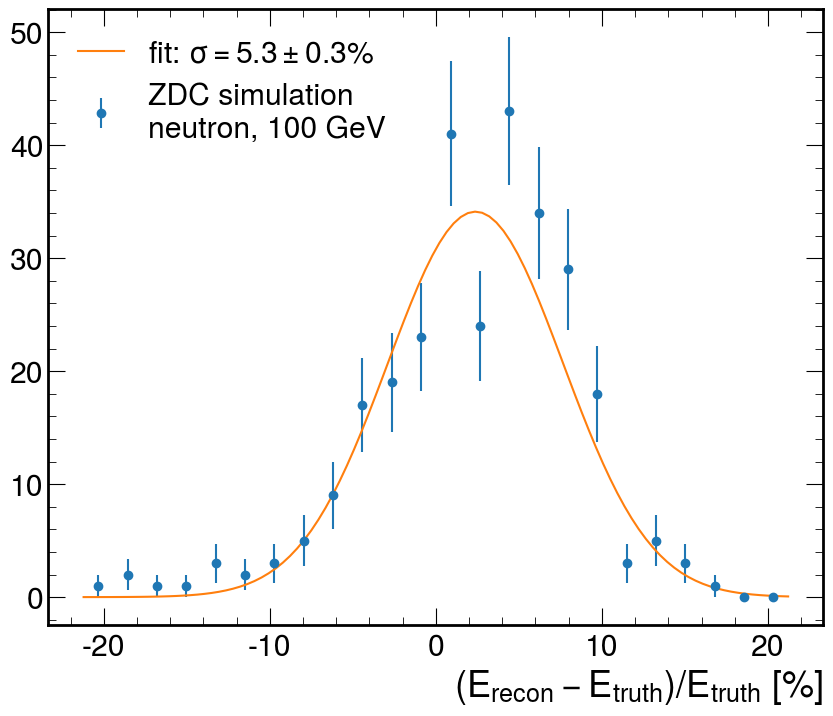

In [22]:
Ebeams=(1,2, 5, 10, 20, 30,40,50, 60, 70, 80, 90, 100)
r_res_vals_h3=[]
r_res_errs_h3=[]
r_res_vals_h3_no_rw=[]
r_res_errs_h3_no_rw=[]
E_res_vals_h3=[]
E_res_errs_h3=[]
for Ebeam in Ebeams:
    df = pd.read_csv(f'cache/staggered_h3_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb, curve= res_plot(df.dr_rw, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    plt.show()
    r_res_vals_h3.append(res)
    r_res_errs_h3.append(dres)
    
    res,dres, eb, curve= res_plot(df.dr, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    plt.show()
    r_res_vals_h3_no_rw.append(res)
    r_res_errs_h3_no_rw.append(dres)
    
    
    res,dres, eb, curve= res_plot(100*(np.array(df.E)/np.mean(df.E)-1), bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), 
                                  label=f"ZDC simulation\nneutron, {Ebeam} GeV", unit="%")
    plt.xlabel("$(E_{\\rm recon}-E_{\\rm truth})/E_{\\rm truth}$ [%]")
    E_res_vals_h3.append(res)
    E_res_errs_h3.append(dres)
    plt.show()

fit: $\sigma=43.3\pm3.0$ mm


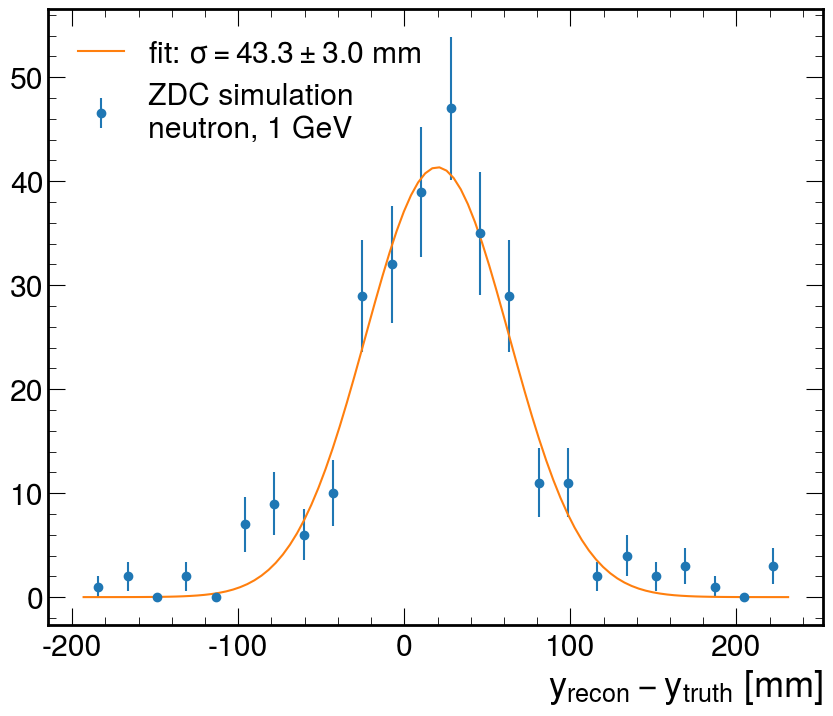

fit: $\sigma=62.7\pm7.2$%


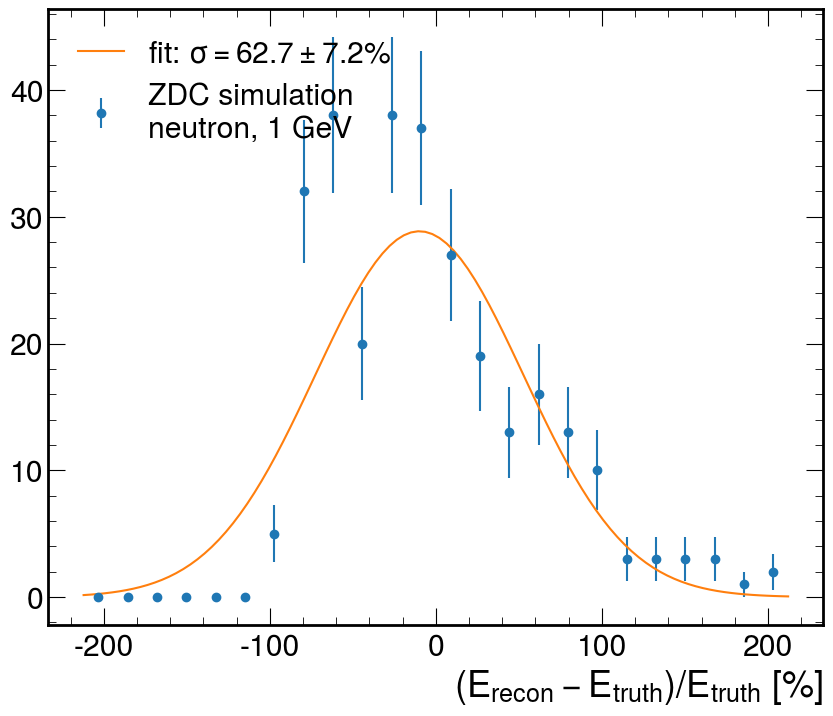

fit: $\sigma=39.7\pm2.5$ mm


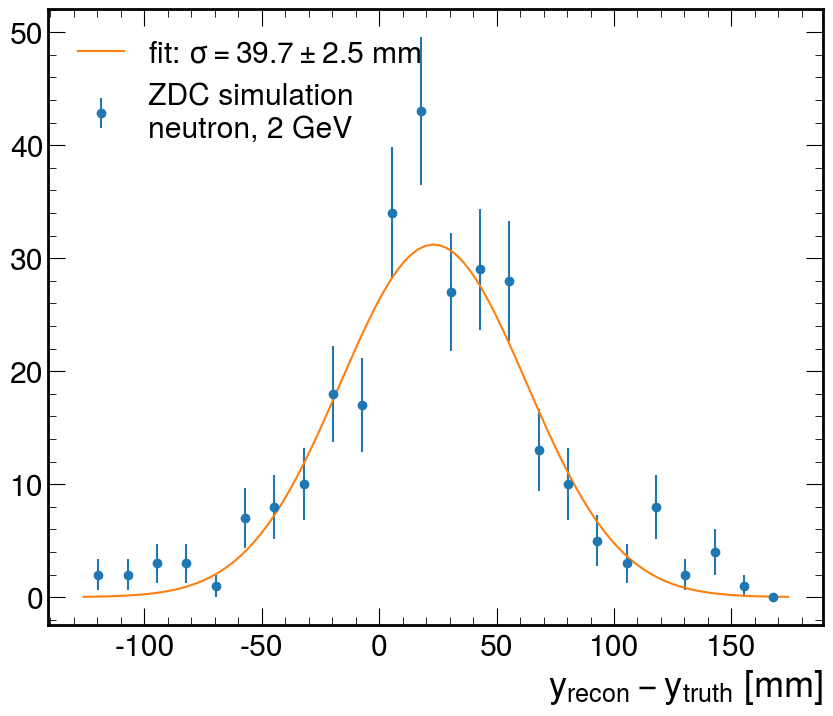

fit: $\sigma=36.9\pm2.1$%


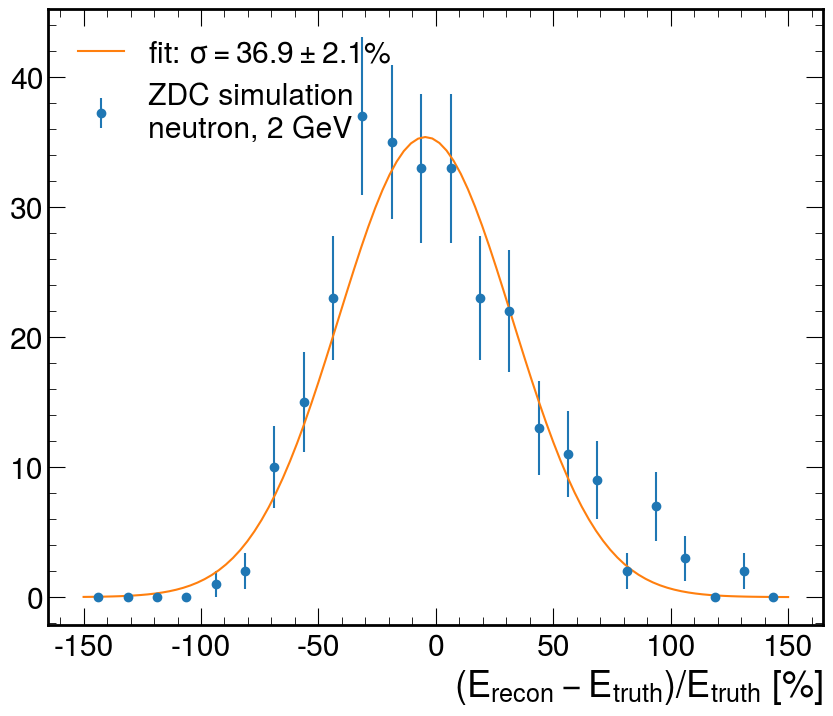

fit: $\sigma=28.6\pm1.4$ mm


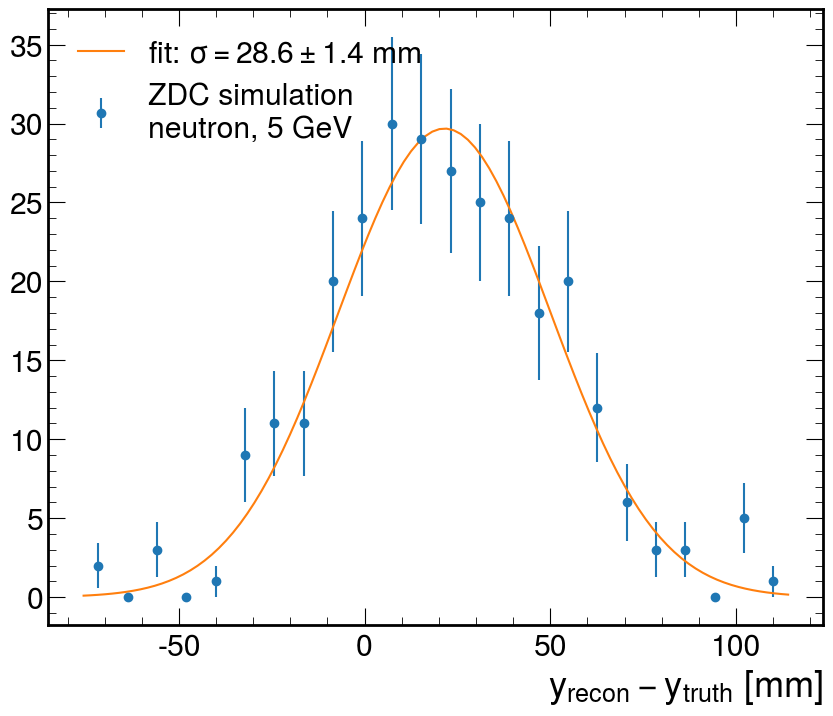

fit: $\sigma=24.4\pm1.0$%


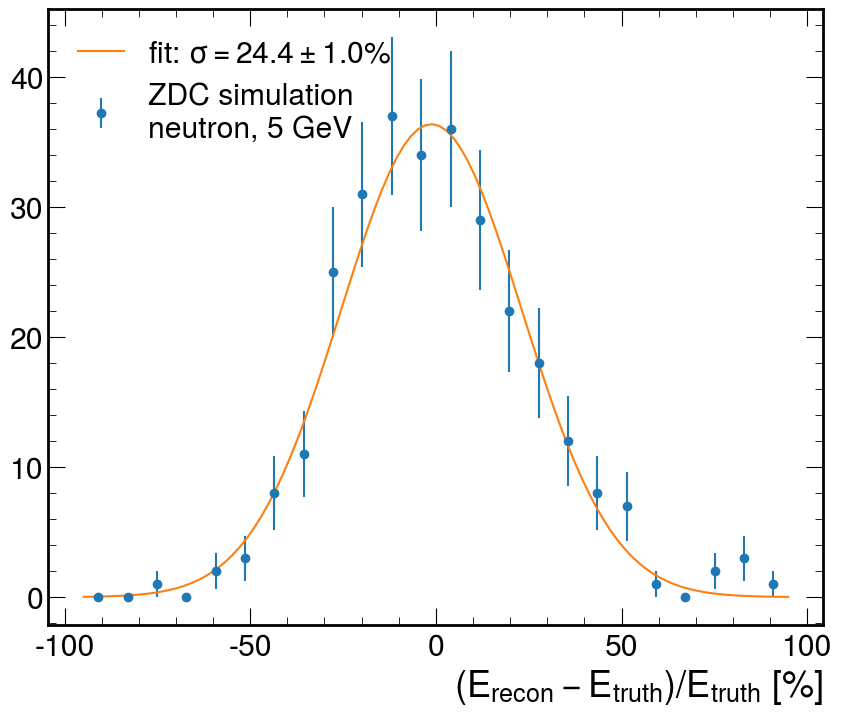

fit: $\sigma=23.0\pm1.0$ mm


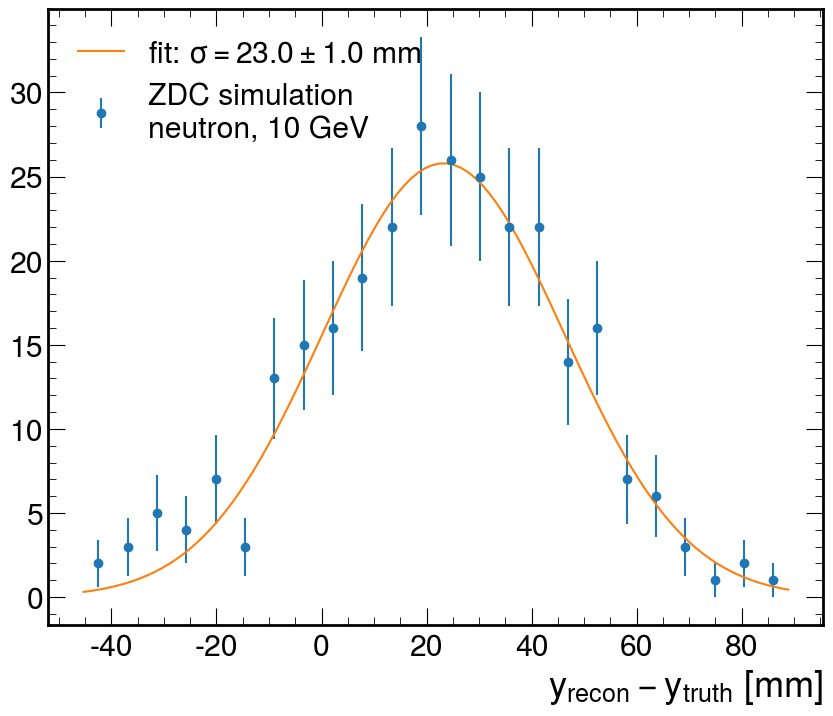

fit: $\sigma=16.2\pm0.6$%


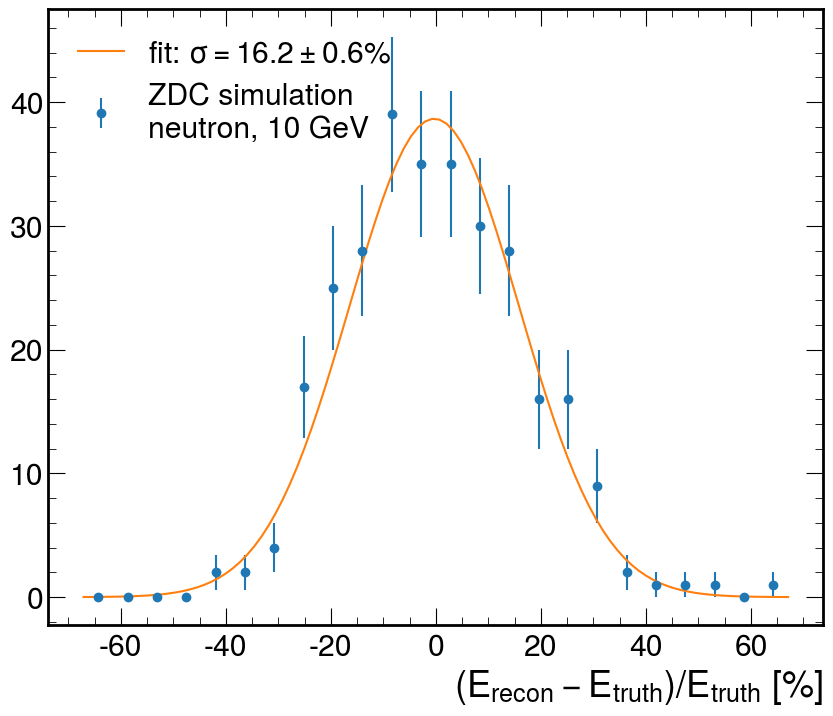

fit: $\sigma=22.0\pm1.8$ mm


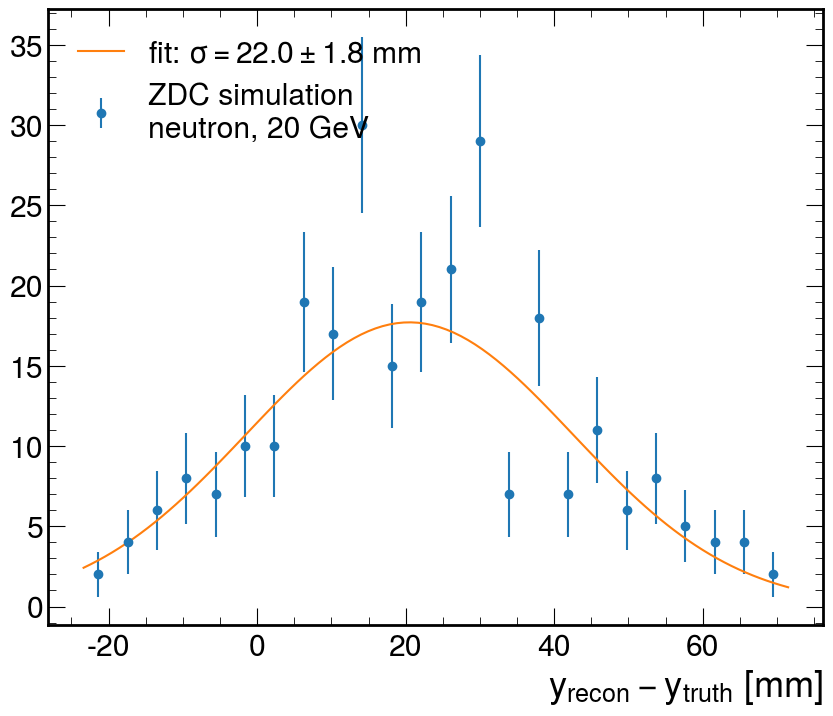

fit: $\sigma=10.9\pm0.5$%


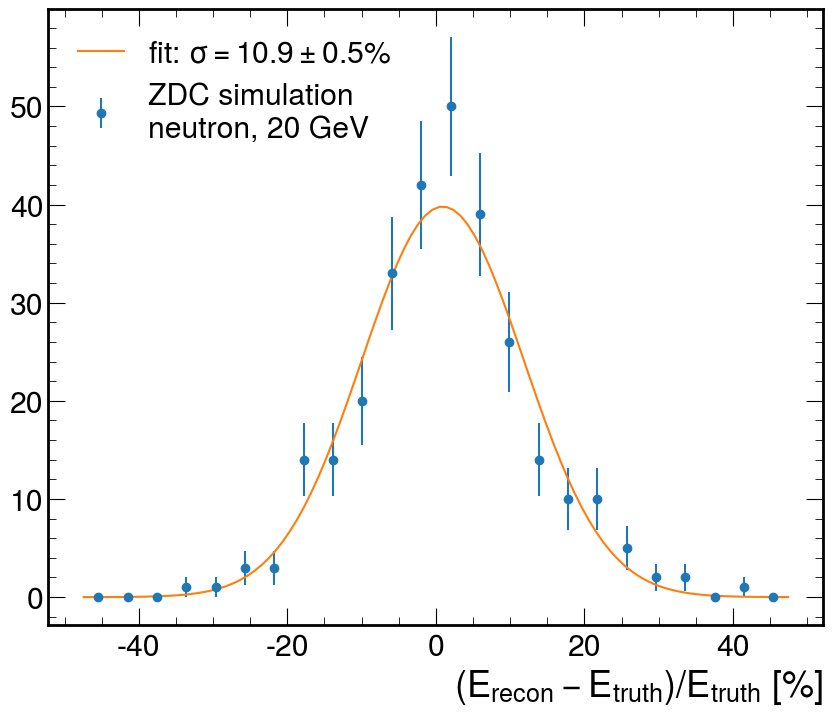

fit: $\sigma=-14.1\pm1.0$ mm


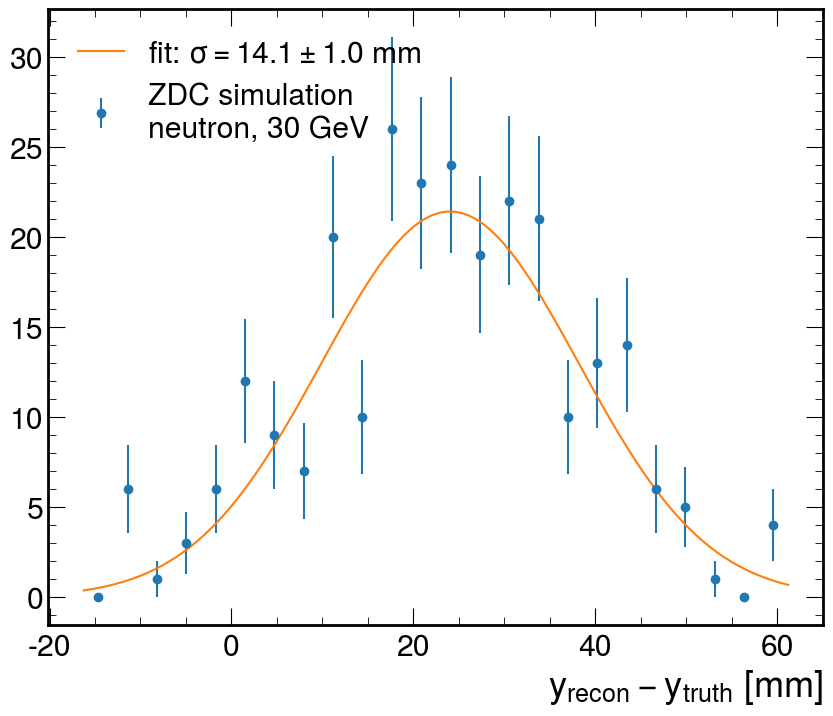

fit: $\sigma=9.2\pm0.5$%


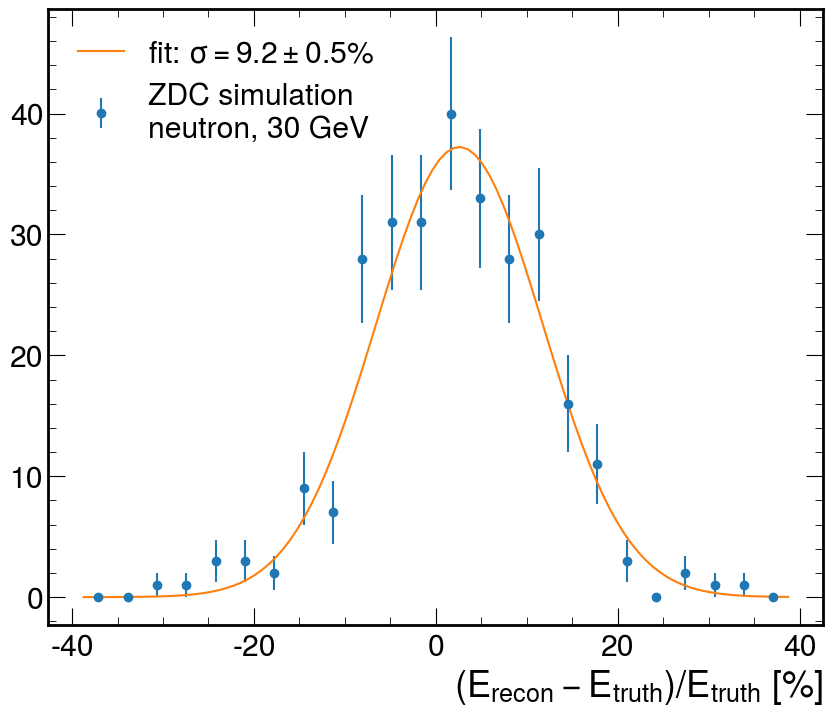

fit: $\sigma=11.2\pm0.7$ mm


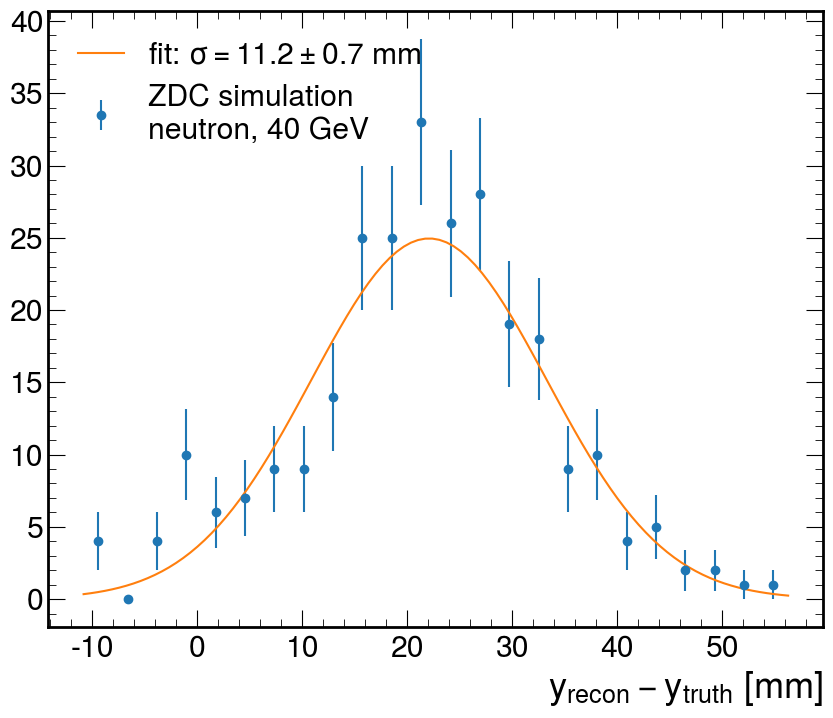

fit: $\sigma=8.6\pm0.4$%


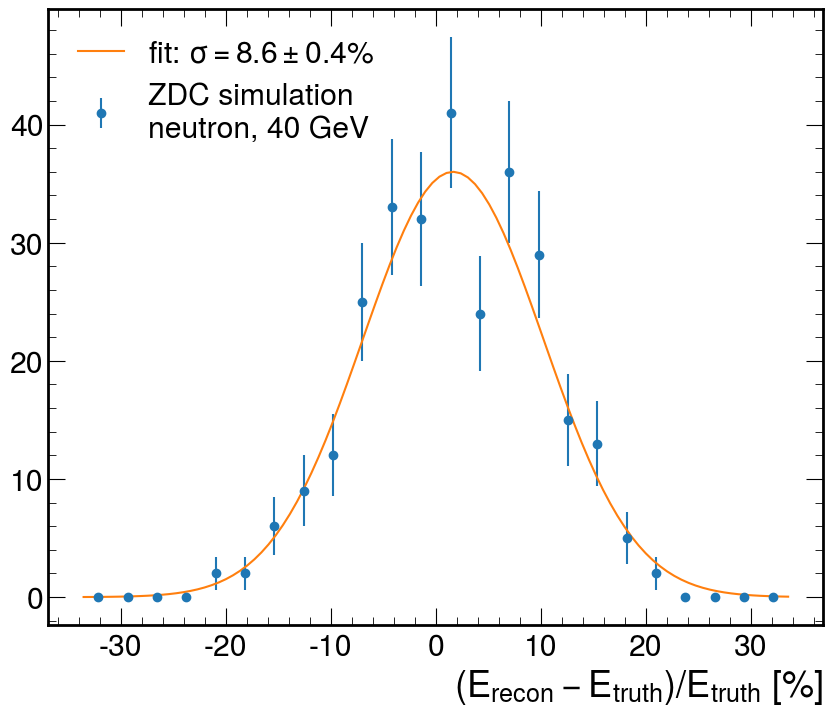

fit: $\sigma=9.5\pm0.7$ mm


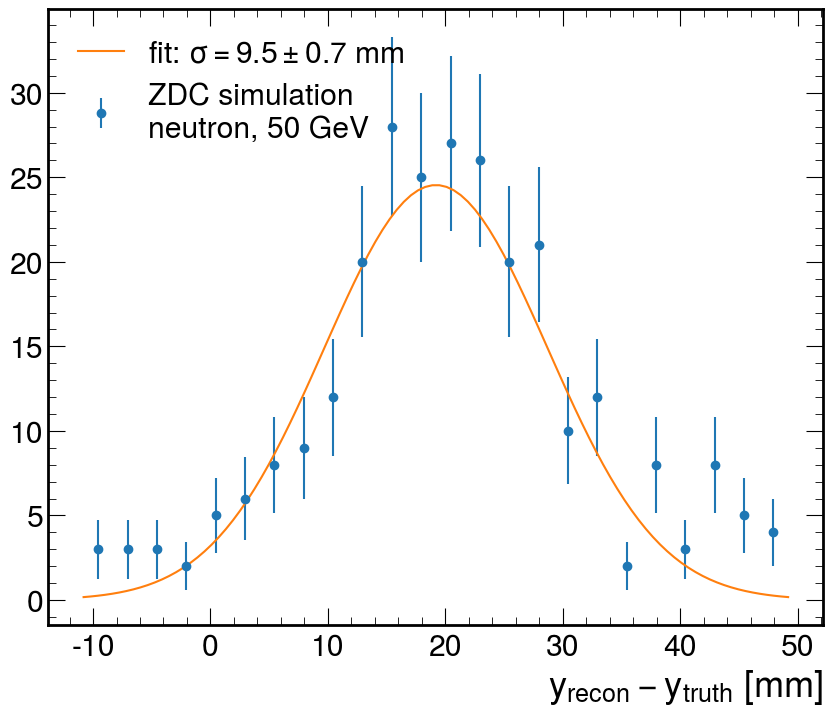

fit: $\sigma=6.9\pm0.4$%


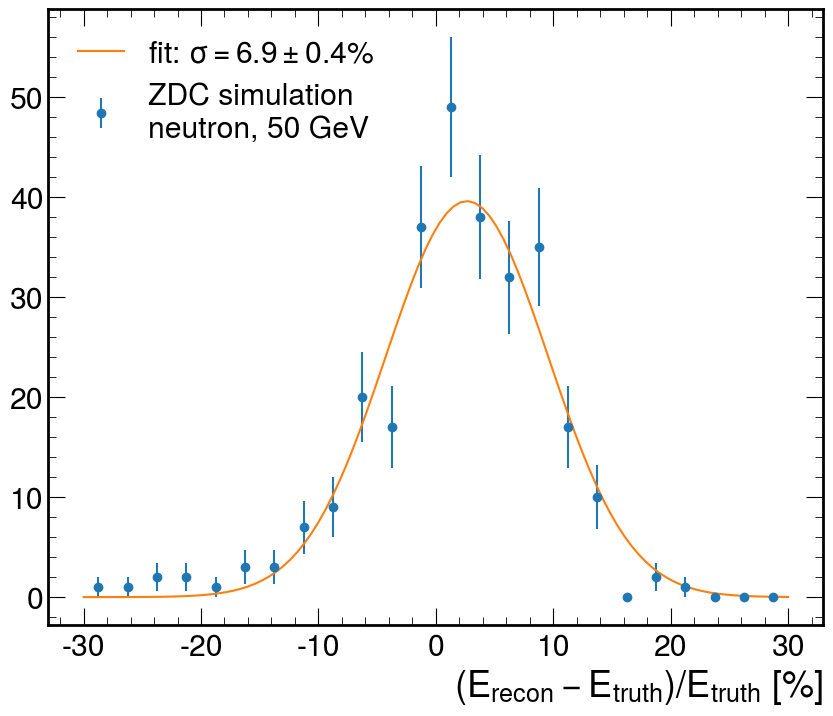

fit: $\sigma=8.5\pm0.6$ mm


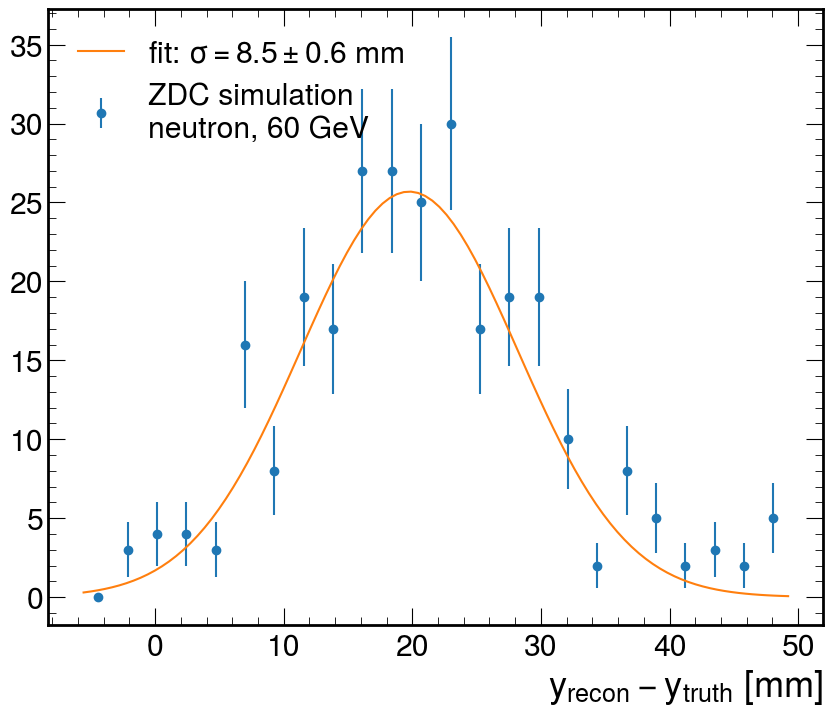

fit: $\sigma=6.3\pm0.3$%


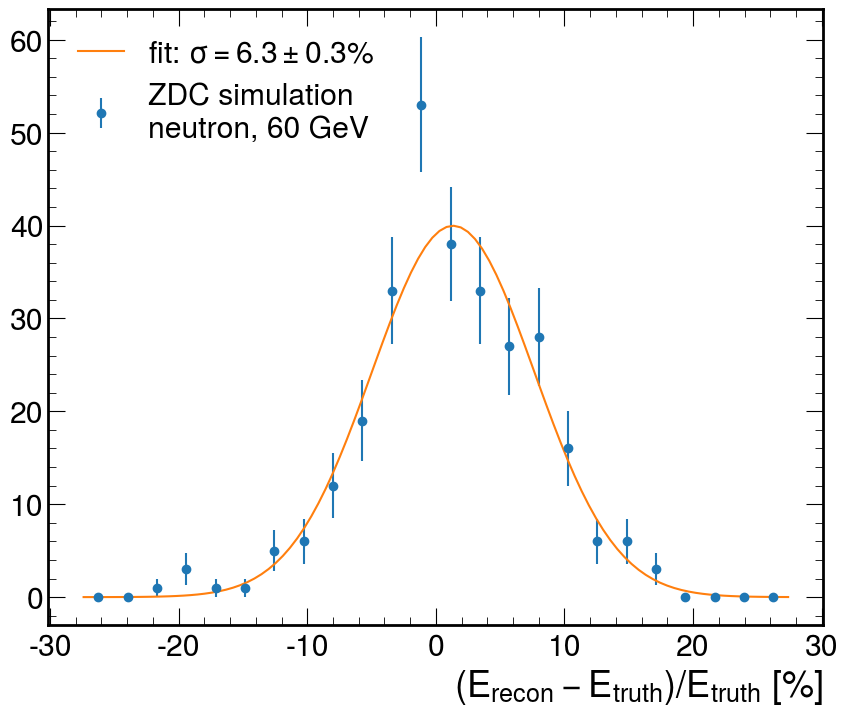

fit: $\sigma=9.6\pm0.9$ mm


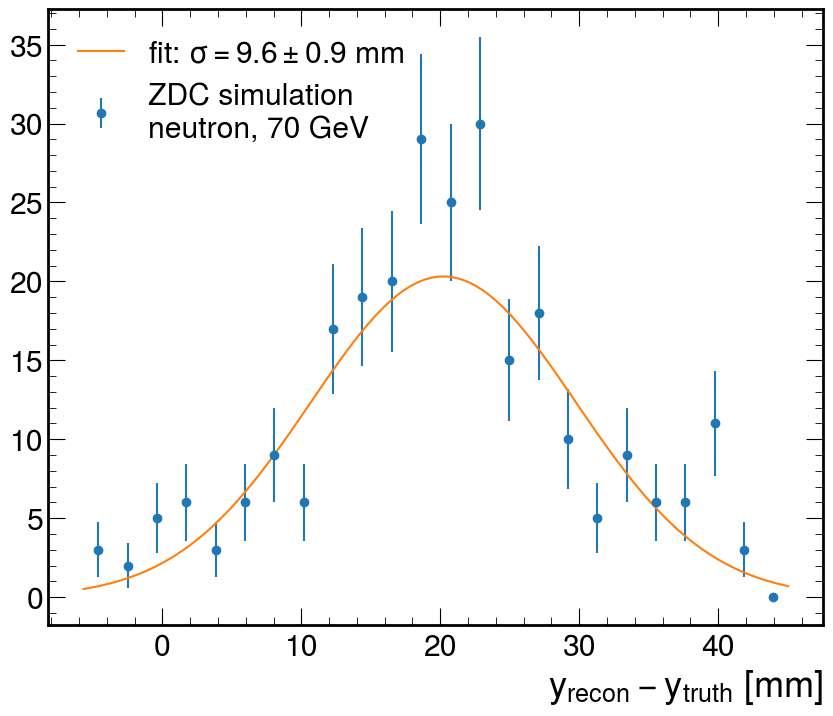

fit: $\sigma=5.5\pm0.3$%


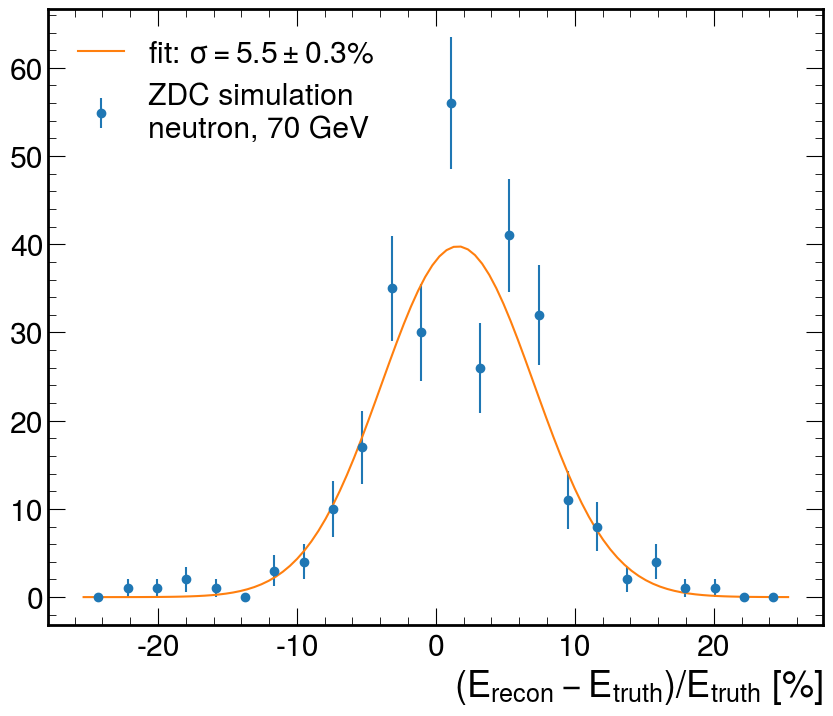

fit: $\sigma=-7.8\pm0.4$ mm


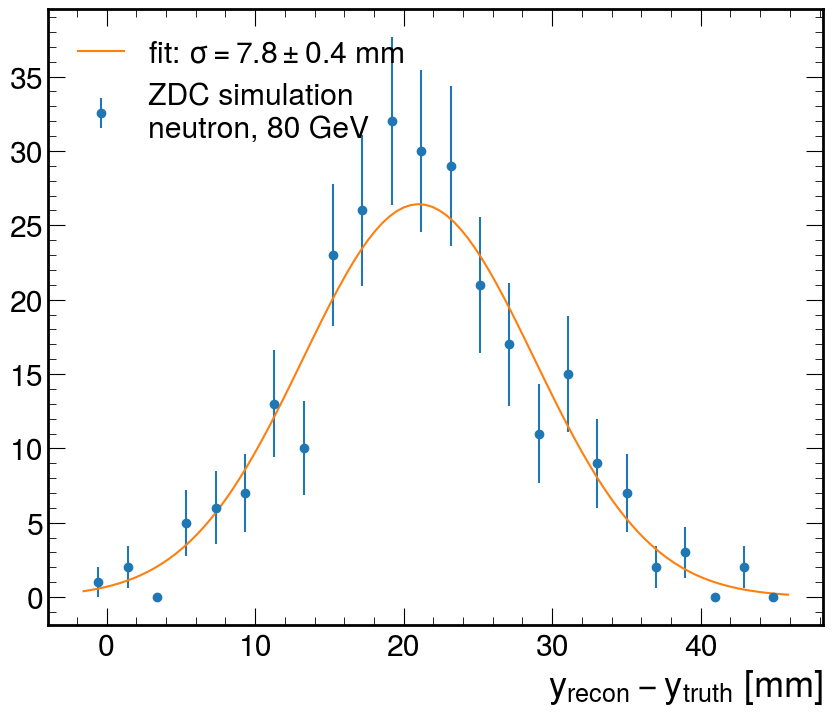

fit: $\sigma=5.9\pm0.3$%


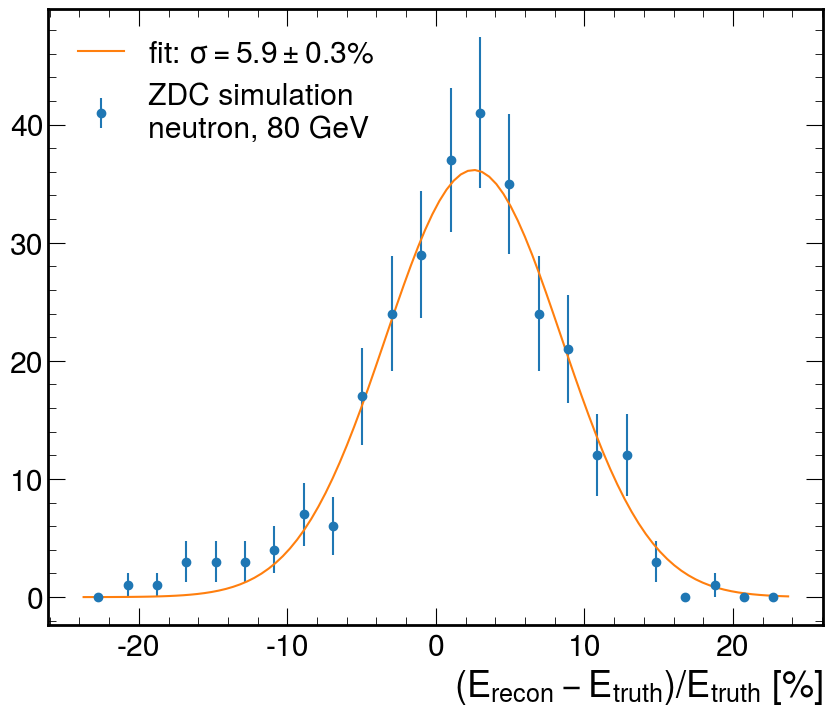

fit: $\sigma=7.6\pm0.4$ mm


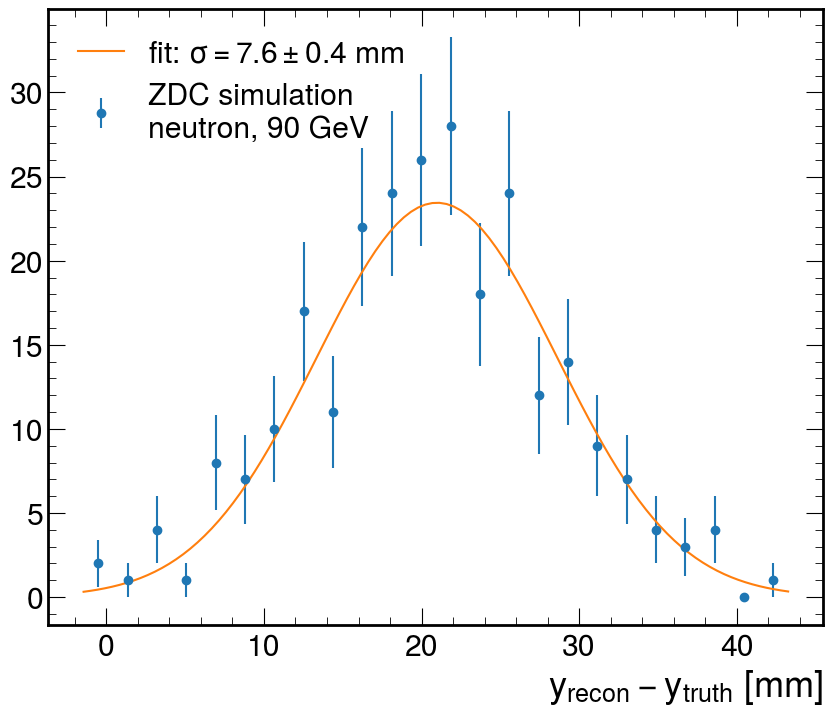

fit: $\sigma=6.0\pm0.3$%


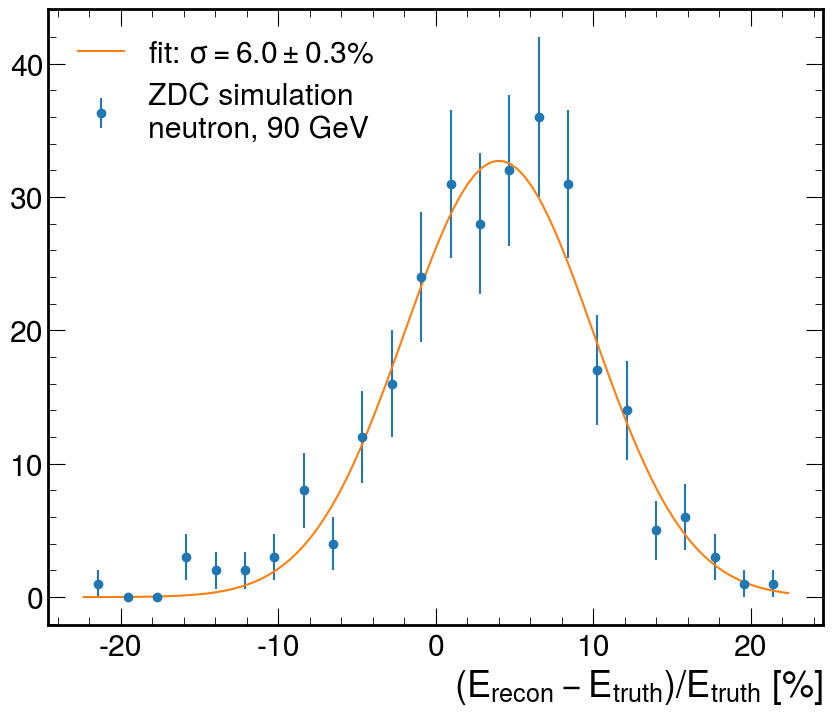

fit: $\sigma=-7.7\pm0.4$ mm


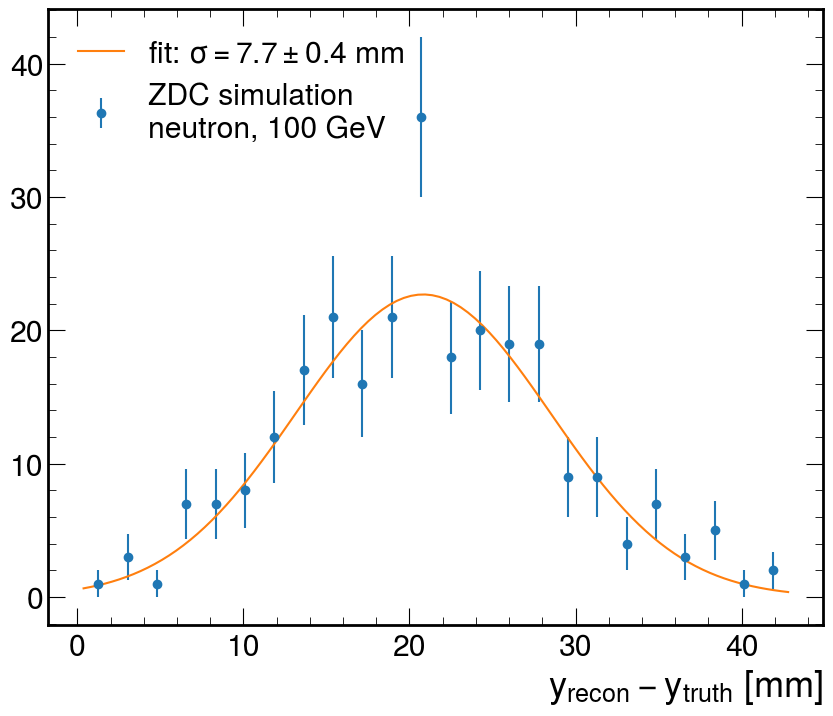

fit: $\sigma=6.0\pm0.3$%


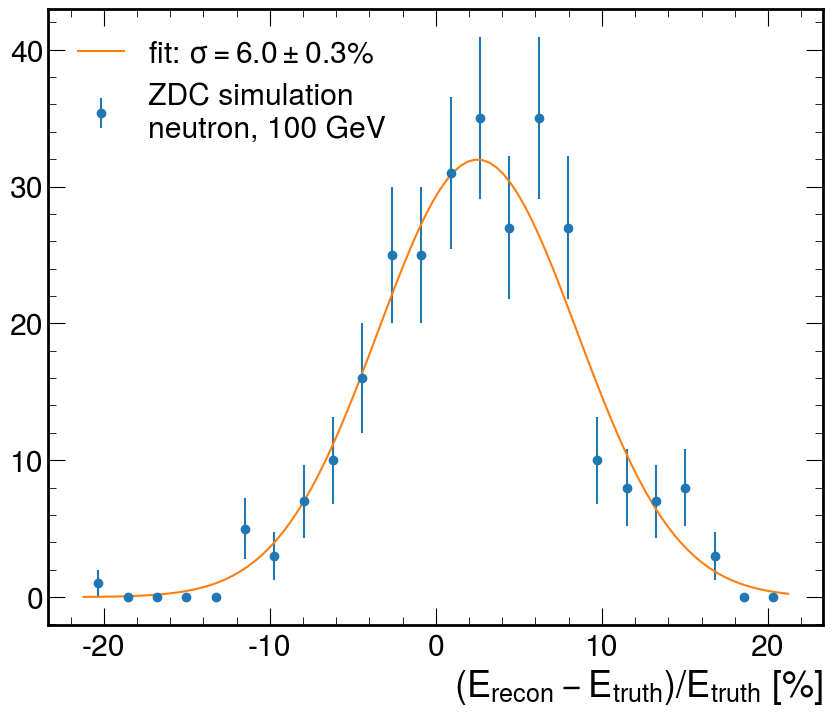

In [23]:
Ebeams=(1,2, 5, 10, 20, 30,40,50, 60, 70, 80, 90, 100)
#r_res_vals_h4=[]
#r_res_errs_h4=[]
r_res_vals_h4_no_rw=[]
r_res_errs_h4_no_rw=[]
E_res_vals_h4=[]
E_res_errs_h4=[]
for Ebeam in Ebeams:
    df = pd.read_csv(f'cache/staggered_h4_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
#     res,dres, eb, curve= res_plot(df.dr_rw, bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
#     plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
#     plt.show()
#     r_res_vals_h3.append(res)
#     r_res_errs_h3.append(dres)
    
    res,dres, eb, curve= res_plot(df.dx, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dx), 30*np.sqrt(50/Ebeam)+np.mean(df.dx), 25), label=f"ZDC simulation\nneutron, {Ebeam} GeV")
    plt.xlabel("$y_{\\rm recon}-y_{\\rm truth}$ [mm]")
    plt.show()
    r_res_vals_h4_no_rw.append(res)
    r_res_errs_h4_no_rw.append(dres)
    
    
    res,dres, eb, curve= res_plot(100*(np.array(df.E)/np.mean(df.E)-1), bins=np.linspace(-30*np.sqrt(50/Ebeam), 30*np.sqrt(50/Ebeam), 25), 
                                  label=f"ZDC simulation\nneutron, {Ebeam} GeV", unit="%")
    plt.xlabel("$(E_{\\rm recon}-E_{\\rm truth})/E_{\\rm truth}$ [%]")
    E_res_vals_h4.append(np.abs(res))
    E_res_errs_h4.append(dres)
    plt.show()

fit: $\sigma=12.5\pm1.1$ mm
fit: $\sigma=6.0\pm0.4$ mm
fit: $\sigma=10.8\pm0.8$ mm
fit: $\sigma=5.4\pm0.4$ mm
fit: $\sigma=10.8\pm0.8$ mm


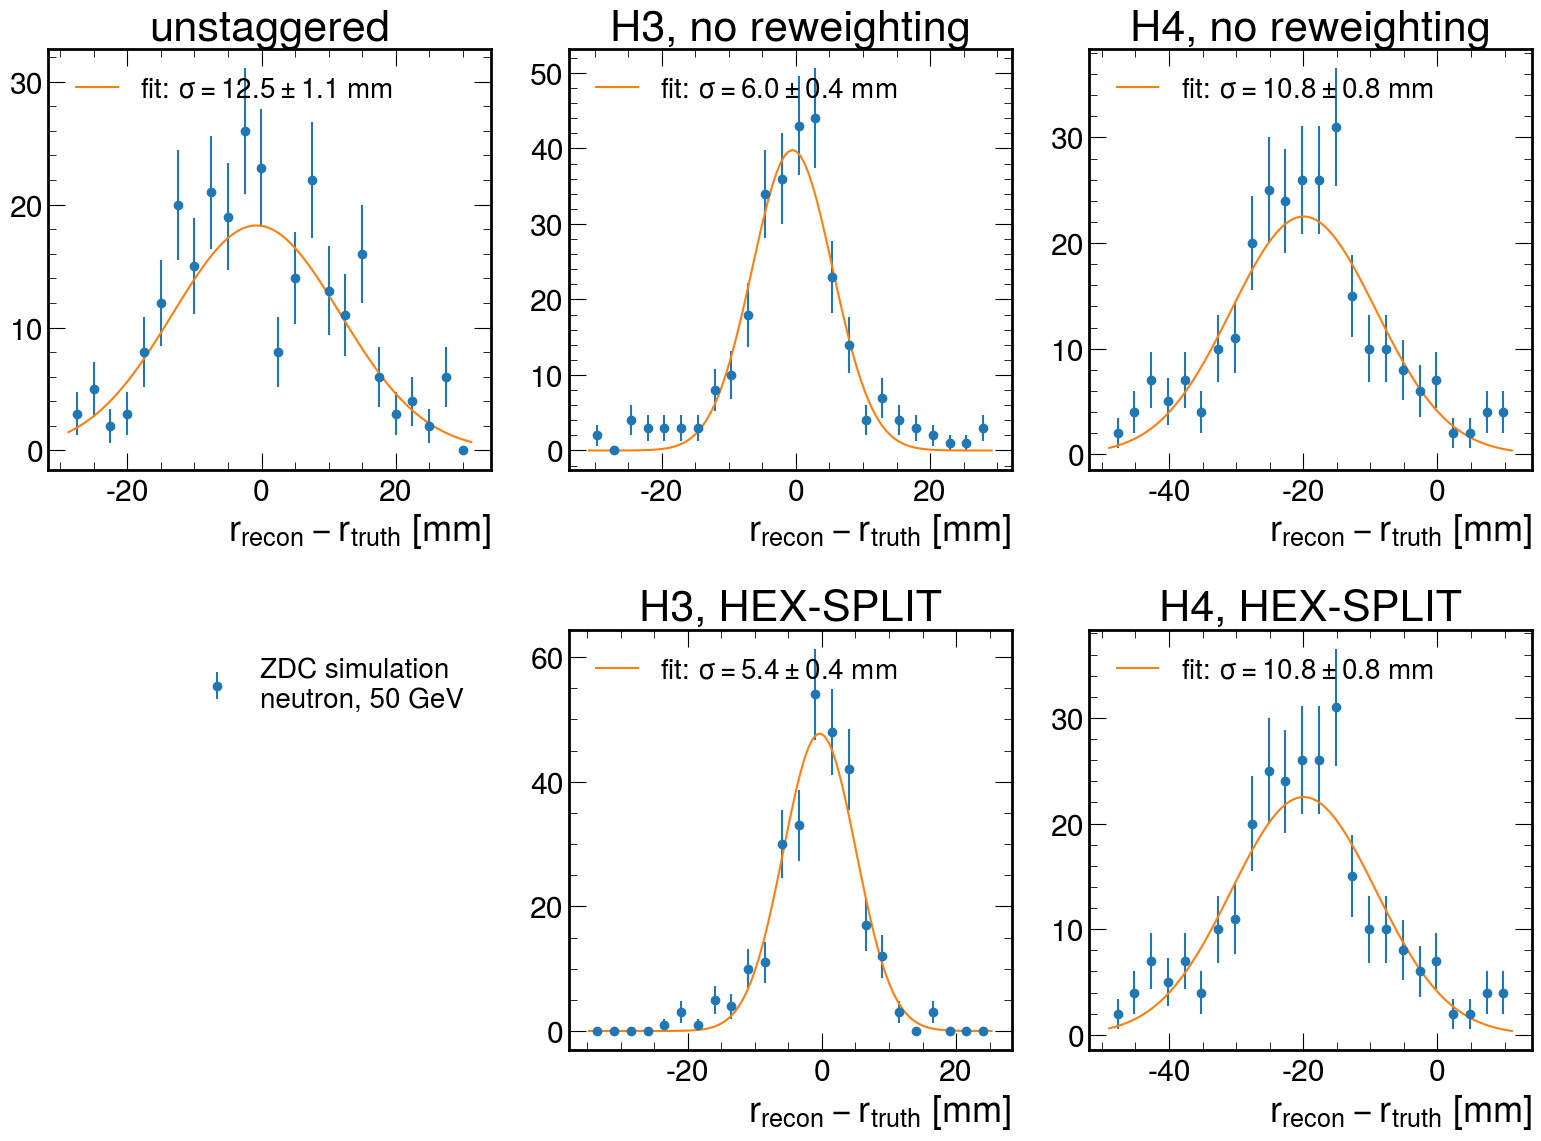

In [58]:
fig,axs=plt.subplots(2,3, figsize=(16,12))
Ebeam=50
plt.sca(axs[0][0])
plt.title("unstaggered")
df = pd.read_csv(f'zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep_h1.csv')
res,dres, eb, curve= res_plot(df.dx, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dr), 30*np.sqrt(50/Ebeam)+np.mean(df.dr), 25), 
                              label=None)
plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
plt.sca(axs[0][1])
plt.title("H3, no reweighting")
df = pd.read_csv(f'zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep_h3.csv')
res,dres, eb, curve= res_plot(df.dy, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dy), 30*np.sqrt(50/Ebeam)+np.mean(df.dy), 25), 
                              label=None)
plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
plt.sca(axs[0][2])
plt.title("H4, no reweighting")
df = pd.read_csv(f'cache/staggered_h4_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
res,dres, eb, curve= res_plot(df.dr, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dr), 30*np.sqrt(50/Ebeam)+np.mean(df.dr), 25), 
                              label=None)
plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
plt.sca(axs[1][1])
plt.title("H3, HEX-SPLIT")
df = pd.read_csv(f'cache/staggered_h3_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
res,dres, eb, curve= res_plot(df.dr_rw, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dr), 30*np.sqrt(50/Ebeam)+np.mean(df.dr), 25), 
                              label=None)
plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
plt.sca(axs[1][2])
plt.title("H4, HEX-SPLIT")
df = pd.read_csv(f'cache/staggered_h4_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
res,dres, eb, curve= res_plot(df.dr, bins=np.linspace(-30*np.sqrt(50/Ebeam)+np.mean(df.dr), 30*np.sqrt(50/Ebeam)+np.mean(df.dr), 25), 
                              label=None)
plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
axs[1][0].axis('off')
axs[1][0].errorbar([], [], [], label=f"ZDC simulation\nneutron, {Ebeam} GeV", ls='', marker='o')
axs[1][0].legend(fontsize=20)
plt.tight_layout()
plt.show()

In [149]:
path='cache/large_scale/h1'
import glob
df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
print(sorted(list(set(np.round(df.mc_pz[:1000])))))

[10.0, 11.0, 12.0, 13.0, 14.0, 16.0, 17.0, 19.0, 21.0, 24.0, 26.0, 29.0, 32.0, 35.0, 39.0, 43.0, 47.0, 52.0, 57.0, 63.0, 70.0, 77.0, 85.0, 93.0, 103.0, 114.0, 125.0, 138.0, 152.0, 168.0, 185.0, 204.0, 225.0, 248.0, 274.0, 302.0]


<ipython-input-149-31f3b0da9849>:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(sorted(list(set(np.round(df.mc_pz[:1000])))))


fit: $\sigma=-12.6\pm0.2$ mm
fit: $\sigma=7.1\pm0.3$ mm
fit: $\sigma=5.7\pm0.2$ mm
fit: $\sigma=-10.9\pm1.0$ mm
fit: $\sigma=-10.9\pm1.0$ mm
fit: $\sigma=12.4\pm0.3$ mm
fit: $\sigma=4.9\pm0.2$ mm
fit: $\sigma=4.2\pm0.1$ mm
fit: $\sigma=8.2\pm0.4$ mm
fit: $\sigma=8.2\pm0.4$ mm


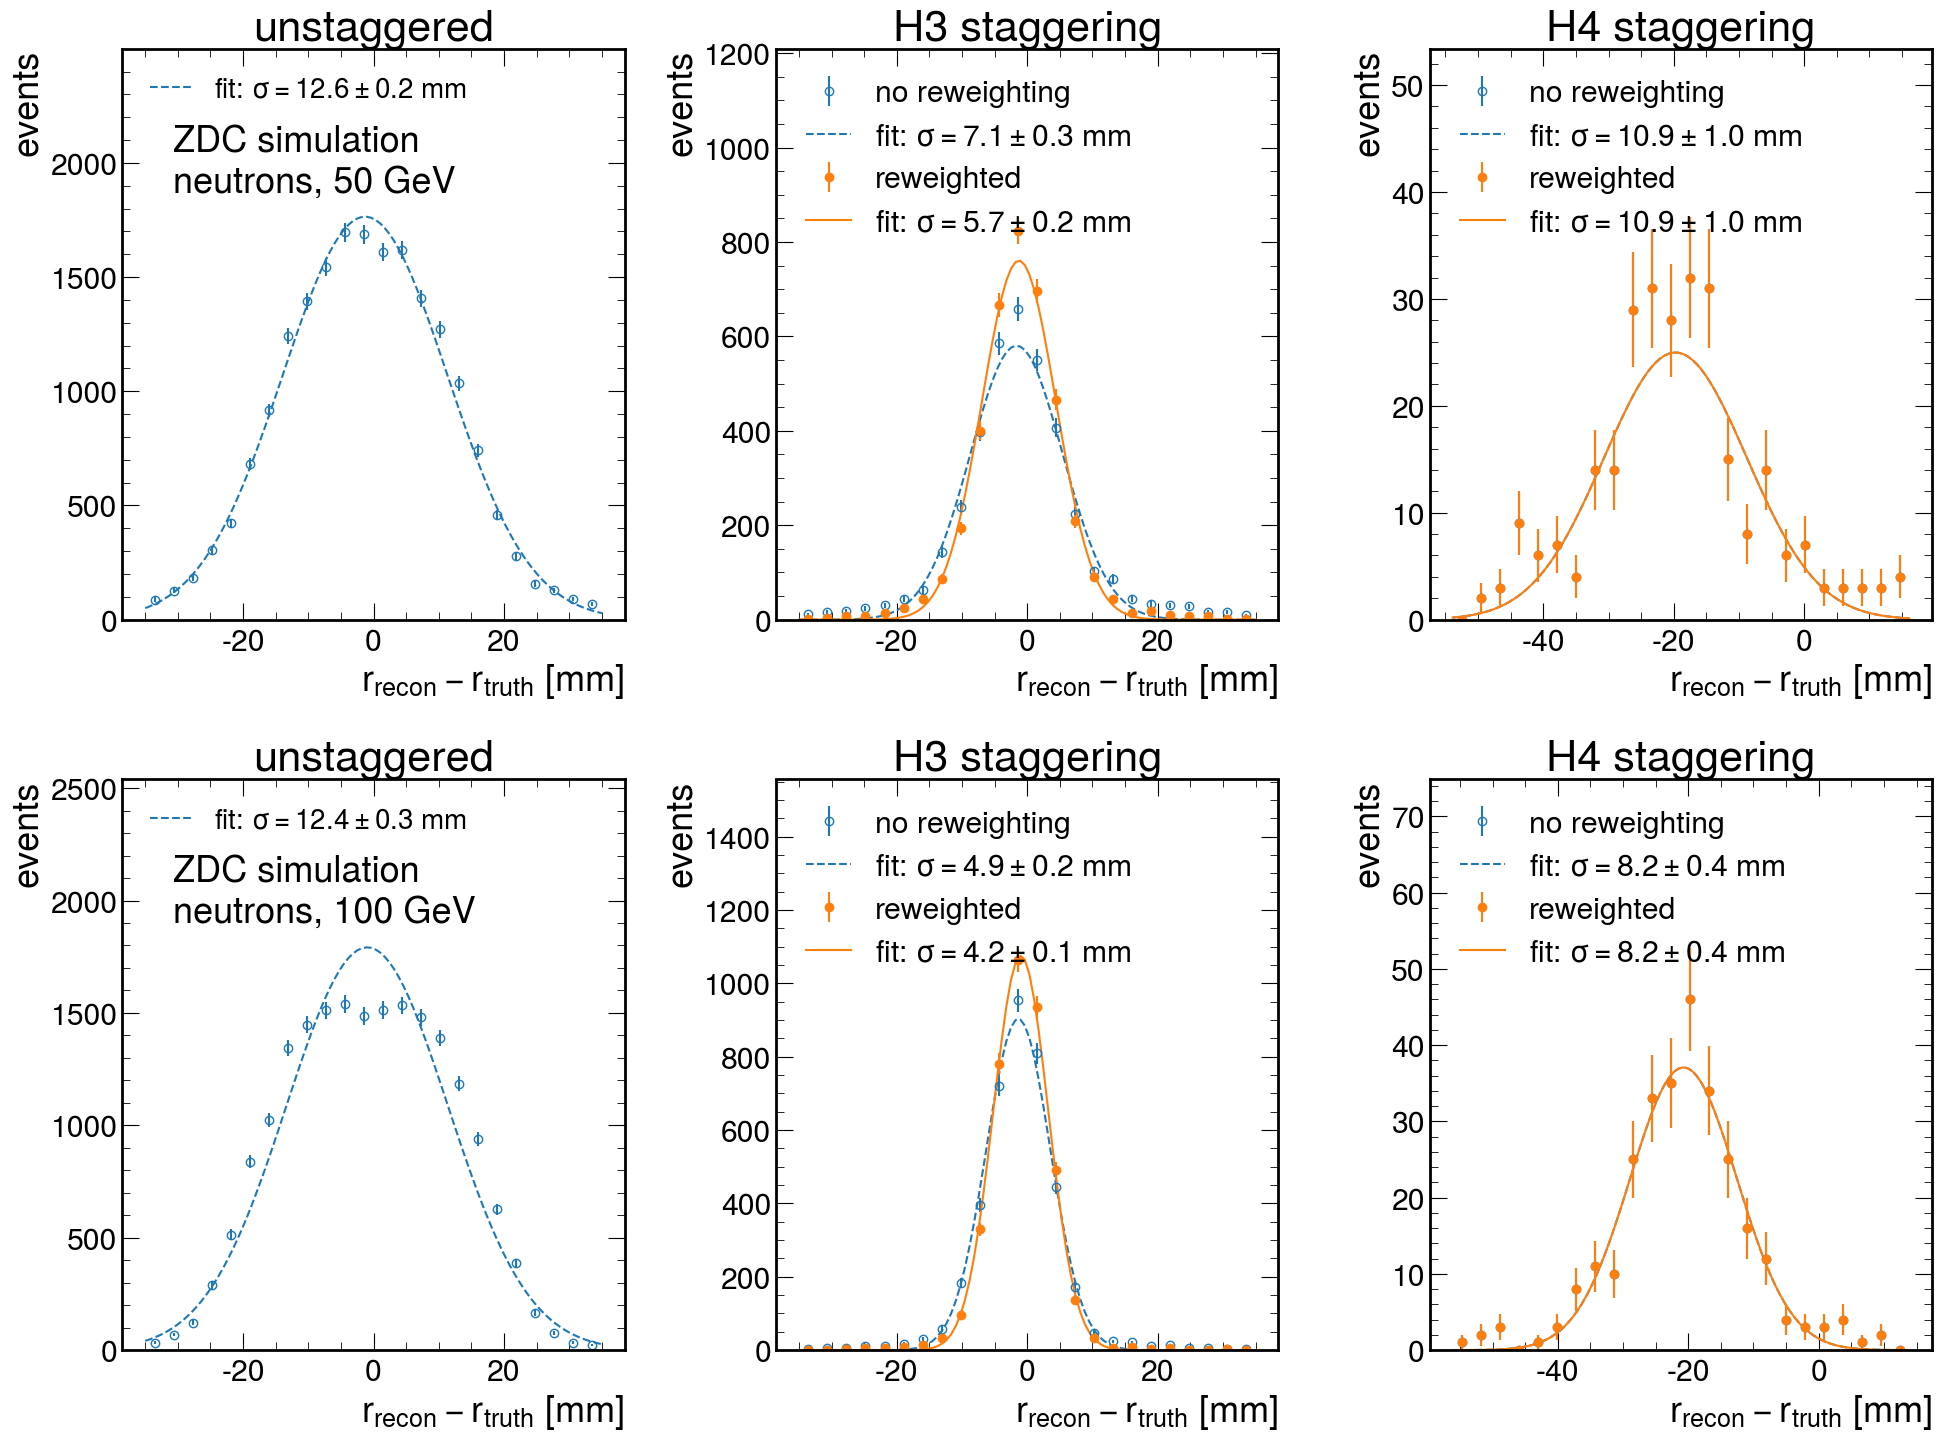

In [167]:
fig,axs=plt.subplots(2,3, figsize=(20,15))
for Ebeam, row in (50, 0), (100, 1):
    plt.sca(axs[row][0])
    plt.title("unstaggered")
    
    # Approach using map() function.
    path='cache/large_scale/h1'
    import glob
    df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
    df=df.query(f'abs(mc_pz/{Ebeam}-1)<.043')
    #df = pd.read_csv(f'cache/unstaggered_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb, curve= res_plot(df.dr, bins=np.linspace(-35, 35, 25), 
                                  label=None,eb_args=dict(color='tab:blue', fillstyle='none'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")


    plt.sca(axs[row][1])
    plt.title("H3 staggering")
    #df = pd.read_csv(f'cache/staggered_h3_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    path='cache/large_scale/h3'
    import glob
    df = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))
    df=df.query(f'abs(mc_pz/{Ebeam}-1)<.043')
    res,dres, eb1, curve1= res_plot(df.dr, bins=np.linspace(-35, 35, 25), 
                                  label="no reweighting", legend=False,eb_args=dict(color='tab:blue', fillstyle='none'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    #df = pd.read_csv(f'cache/staggered_h3_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb2, curve2= res_plot(df.dr_rw, bins=np.linspace(-35, 35, 25), 
                                  label="reweighted", legend=False, eb_args=dict(color='tab:orange', fillstyle='full'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'))

    plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    plt.sca(axs[row][2])
    plt.title("H4 staggering")
    df = pd.read_csv(f'cache/staggered_h4_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb1, curve1= res_plot(df.dr, bins=np.linspace(-35+np.mean(df.dr), 35+np.mean(df.dr), 25), 
                                  label="no reweighting", legend=False,eb_args=dict(color='tab:blue', fillstyle='none'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    df = pd.read_csv(f'cache/staggered_h4_zdc/zdc_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.csv')
    res,dres, eb2, curve2= res_plot(df.dr, bins=np.linspace(-35+np.mean(df.dr), 35+np.mean(df.dr), 25), 
                                  label="reweighted", legend=False, eb_args=dict(color='tab:orange', fillstyle='full'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'))

    plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    axs[row][0].text(0.1, 0.75, f"ZDC simulation\nneutrons, {Ebeam} GeV", transform=axs[row][0].transAxes)
for row in axs:
    for ax in row:
        ax.set_ylabel("events")
        ax.set_ylim(0, ax.get_ylim()[1]*1.35)


plt.tight_layout()
plt.savefig("../images/zdc_results_1d.pdf")
plt.show()

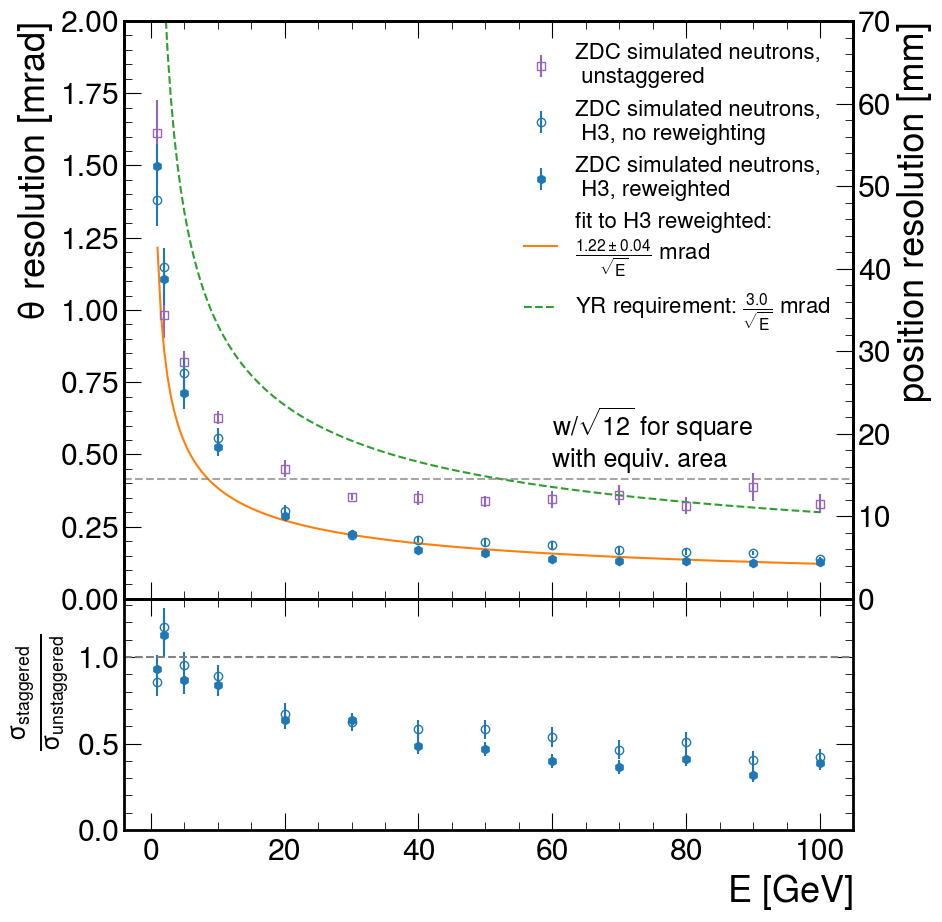

In [166]:
z_in_meters=35

labels="unstaggered", "H3, no reweighting", "H4, no reweighting", "H3, reweighted"
pos_res=[r_res_vals_h1, r_res_vals_h3_no_rw, r_res_vals_h4_no_rw, r_res_vals_h3]
dpos_res=[r_res_errs_h1, r_res_errs_h3_no_rw, r_res_errs_h4_no_rw, r_res_errs_h3]
colors=['tab:purple', 'tab:blue', 'tab:red', 'tab:blue', 'tab:red']
fillstyles=['none', 'none', 'none', 'full', 'full']
markers=['s', 'o', 'o', 'h', 'h']
a=0.4
fig, axs= plt.subplots(2,1, gridspec_kw=dict(height_ratios=(1,a)),sharex='all', figsize=(10, 7*(1+a)))
artists=[]
for i in range(4):
    if i== 2: #skip the H4
        continue
    y=np.abs(pos_res[i])/z_in_meters
    dy=np.array(dpos_res[i])/z_in_meters
    
    a=axs[0].errorbar(Ebeams, y, dy, marker=markers[i], label=f'ZDC simulated neutrons,\n {labels[i]}', ls='', fillstyle=fillstyles[i], color=colors[i])
    artists.append(a)
    if i==0:
        y_ref=y
        dy_ref=dy
    else:
        axs[1].errorbar(Ebeams, y/y_ref, y/y_ref*np.hypot(dy/y, dy_ref/y_ref), marker=markers[i], ls='', fillstyle=fillstyles[i], color=colors[i])
# y=np.array(r_res_vals_h3_no_rw)/z_in_meters
# dy=np.array(r_res_errs_h3_no_rw)/z_in_meters
# plt.errorbar(Ebeams, abs(y), dy, marker='o', label='ZDC simulation\nneutrons, staggered H3, no reweighting', ls='', fillstyle='none', color='tab:red')

# y=np.array(r_res_vals_h4_no_rw)/z_in_meters
# dy=np.array(r_res_errs_h4_no_rw)/35
# plt.errorbar(Ebeams, abs(y), dy, marker='o', label='ZDC simulation\nneutrons, staggered H4, no reweighting', ls='', fillstyle='none', color='tab:pink')

# y=np.array(r_res_vals_h3)/35
# dy=np.array(r_res_errs_h3)/35
# plt.errorbar(Ebeams, abs(y), dy, marker='o', label='ZDC simulation\nneutrons, staggered H3, reweighted', ls='')


fnc=lambda x, a: a/np.sqrt(x)
p0=[3]
coeff, var_matrix = curve_fit(fnc, Ebeams[:len(y)], y, p0=p0,
                             sigma=dy)

label=f"fit to H3 reweighted:  \n$\\frac{{{coeff[0]:.2f}\pm {np.sqrt(var_matrix[0][0]):.2f}}}{{\\sqrt{{E}}}}$ mrad"
        #+ f" \\oplus {coeff[1]:.1f}\pm {np.sqrt(var_matrix[1][1]):.1f}$ mm" 

x=np.linspace(1, 100, 200)
a=axs[0].plot(x, fnc(x, *coeff), label=label, color='tab:orange')
artists.append(a[0])

axs[0].set_ylabel("$\\theta$ resolution [mrad]")
axs[1].set_ylabel("$\\frac{\\sigma_{staggered}}{\\sigma_{\\rm unstaggered}}$    ")
axs[1].set_xlabel("$E$ [GeV]")

axs[0].set_ylim(0,2)

a=axs[0].plot(x, 3/np.sqrt(x), label="YR requirement: $\\frac{3.0}{\\sqrt{E}}$ mrad", ls='--', color='tab:green')
artists.append(a[0])

axs[1].axhline(1,color='0.5', alpha=1, ls='--')

axs[1].set_ylim(0)

s=31.3
A=s**2*np.sqrt(3)*3/2

axs[0].axhline(np.sqrt(A)/np.sqrt(12)/35,color='0.5', alpha=0.7, ls='--')
axs[0].text(60, 1.1*np.sqrt(A)/np.sqrt(12)/35, "w/$\\sqrt{12}$ for square\nwith equiv. area", fontsize=18)

axs[0].legend(handles=artists,fontsize=16, ncol=1)
maxy=axs[0].get_ylim()[1]
ax2=axs[0].twinx()
ax2.set_ylim(0, maxy*35)
ax2.set_ylabel("position resolution [mm]")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("../images/position_resolution.pdf")
plt.show()

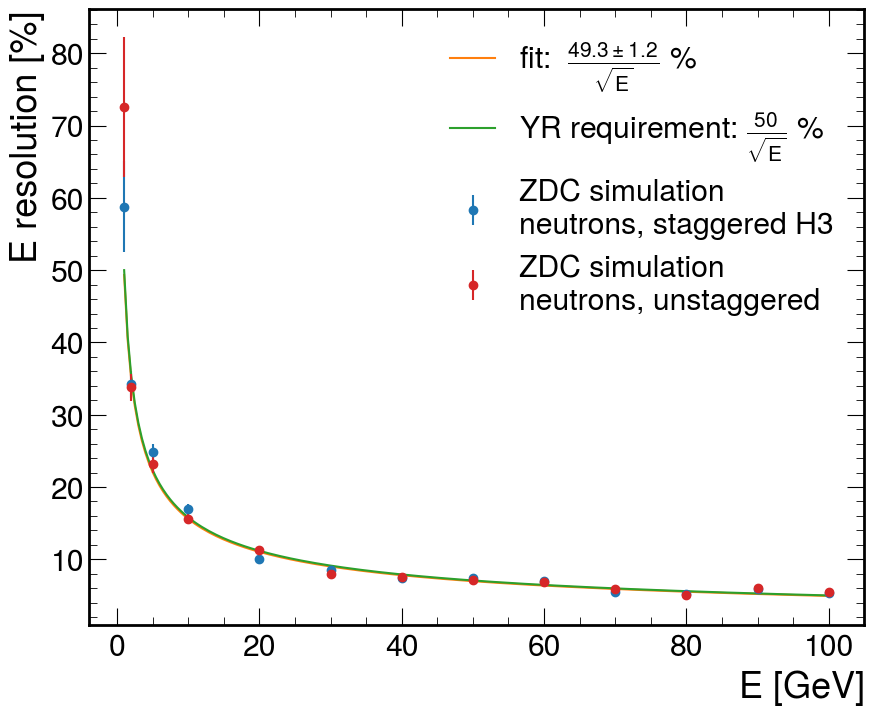

In [25]:
y=np.array(E_res_vals_h3)
dy=np.array(E_res_errs_h3)
plt.errorbar(Ebeams, y, dy, marker='o', label='ZDC simulation\nneutrons, staggered H3', ls='')

fnc=lambda x, a: a/np.sqrt(x)
p0=[3]
coeff, var_matrix = curve_fit(fnc, Ebeams, y, p0=p0,
                             sigma=dy)

label=f"fit:  $\\frac{{{coeff[0]:.1f}\pm {np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}$ %"
        #+ f" \\oplus {coeff[1]:.1f}\pm {np.sqrt(var_matrix[1][1]):.1f}$ mm" 

x=np.linspace(1, 100, 200)
plt.plot(x, fnc(x, *coeff), label=label)

plt.ylabel("E resolution [%]")
plt.xlabel("$E$ [GeV]")

plt.plot(x, 50/np.sqrt(x), label="YR requirement: $\\frac{50}{\\sqrt{E}}$ %", ls='-')

y=np.array(E_res_vals_h1)
dy=np.array(E_res_errs_h1)
plt.errorbar(Ebeams, y, dy, marker='o', label='ZDC simulation\nneutrons, unstaggered', ls='')


plt.legend()
plt.show()

In [138]:
import uproot as ur
fname="/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.5deg_unstaggered/reco/zdc_reco_neutron_discrete_1GeV-300GeV_theta_0deg-0.5deg_635443_100.edm4hep.root"

events = ur.open(fname+":events")
arrays = events.arrays()
print(arrays['MCParticles.momentum.z'])

[[10, 0, 103], [10, 0, 152], [10, 0, 125], ... [10, 0, 12], [10, 0, 47], [10, 0, 39]]


fit: $\sigma=6.8\pm0.6$ mm


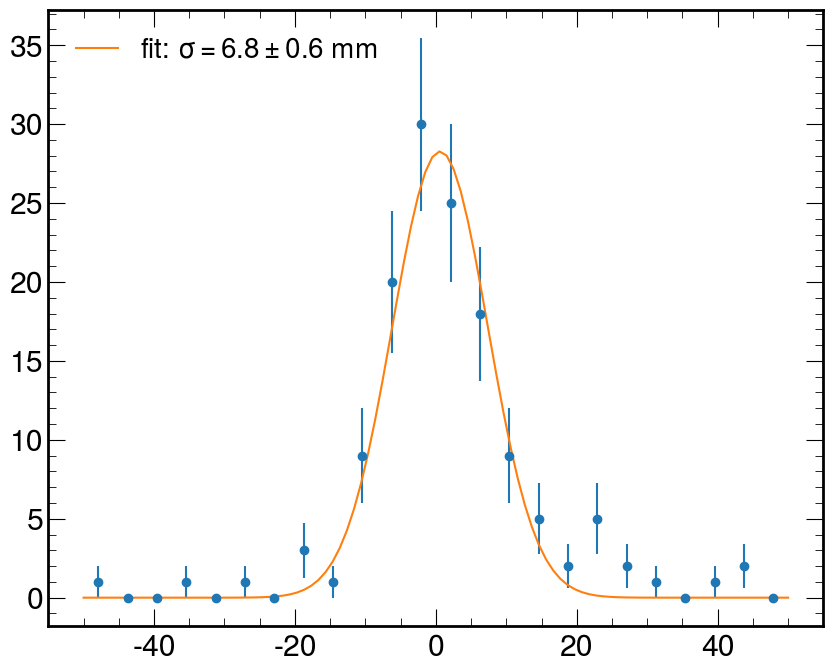

In [240]:
df = pd.read_csv(f'test_h4_nosplit.csv')
res_plot(df.dy_rw,bins=np.linspace(-50, 50, 25))
plt.show()

In [209]:
31*3/4

23.25